In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.13.0


Uninstalling tensorflow-2.13.0:


  Successfully uninstalled tensorflow-2.13.0


Found existing installation: keras 2.13.1


Uninstalling keras-2.13.1:
  Successfully uninstalled keras-2.13.1


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

  Obtaining dependency information for tensorflow_text from https://files.pythonhosted.org/packages/a9/48/7749e08961469a729a6c11a59265f648849e3f7fc69be93131389a9fe31d/tensorflow_text-2.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/d6/af/cb5ea6d1a9c83e715e29b45a598ebf542729cd216b43f5deefc27657bd38/tensorflow-2.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow-2.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)


  Obtaining dependency information for keras<2.14,>=2.13.1 from https://files.pythonhosted.org/packages/2e/f3/19da7511b45e80216cbbd9467137b2d28919c58ba1ccb971435cb631e470/keras-2.13.1-py3-none-any.whl.metadata
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)


Using cached tensorflow_text-2.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)


Using cached tensorflow-2.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)


Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)


In [ ]:
!pip install einops

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [ ]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

In [ ]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path

    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)

    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

In [ ]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

      8192/1115419746 [..............................] - ETA: 0s

   3620864/1115419746 [..............................] - ETA: 15s

   5586944/1115419746 [..............................] - ETA: 19s

   8413184/1115419746 [..............................] - ETA: 20s

  12623872/1115419746 [..............................] - ETA: 18s

  16850944/1115419746 [..............................] - ETA: 18s

  21061632/1115419746 [..............................] - ETA: 17s

  25272320/1115419746 [..............................] - ETA: 17s

  29491200/1115419746 [..............................] - ETA: 17s

  32022528/1115419746 [..............................] - ETA: 17s

  35258368/1115419746 [..............................] - ETA: 17s

  38535168/1115419746 [>.............................] - ETA: 17s

  41820160/1115419746 [>.............................] - ETA: 17s

  45113344/1115419746 [>.............................] - ETA: 17s

  48439296/1115419746 [>.............................] - ETA: 16s

  51724288/1115419746 [>.............................] - ETA: 16s

  54927360/1115419746 [>.............................] - ETA: 16s

  58220544/1115419746 [>.............................] - ETA: 16s

  61530112/1115419746 [>.............................] - ETA: 16s

  64782336/1115419746 [>.............................] - ETA: 16s

  68083712/1115419746 [>.............................] - ETA: 16s

  71360512/1115419746 [>.............................] - ETA: 16s

  74678272/1115419746 [=>............................] - ETA: 16s

  77946880/1115419746 [=>............................] - ETA: 16s

  81117184/1115419746 [=>............................] - ETA: 16s

  84557824/1115419746 [=>............................] - ETA: 16s

  87810048/1115419746 [=>............................] - ETA: 16s

  91119616/1115419746 [=>............................] - ETA: 15s

  94355456/1115419746 [=>............................] - ETA: 15s

  97492992/1115419746 [=>............................] - ETA: 15s

 100892672/1115419746 [=>............................] - ETA: 15s

 104202240/1115419746 [=>............................] - ETA: 15s

 107520000/1115419746 [=>............................] - ETA: 15s

 110297088/1115419746 [=>............................] - ETA: 15s

 114065408/1115419746 [==>...........................] - ETA: 15s

 117448704/1115419746 [==>...........................] - ETA: 15s

 120741888/1115419746 [==>...........................] - ETA: 15s

 123994112/1115419746 [==>...........................] - ETA: 15s

 127156224/1115419746 [==>...........................] - ETA: 15s

 130588672/1115419746 [==>...........................] - ETA: 15s

 133857280/1115419746 [==>...........................] - ETA: 15s

 137134080/1115419746 [==>...........................] - ETA: 15s

 140156928/1115419746 [==>...........................] - ETA: 15s

 143646720/1115419746 [==>...........................] - ETA: 15s

 146882560/1115419746 [==>...........................] - ETA: 14s

 150265856/1115419746 [===>..........................] - ETA: 14s

 153444352/1115419746 [===>..........................] - ETA: 14s

 156672000/1115419746 [===>..........................] - ETA: 14s

 160006144/1115419746 [===>..........................] - ETA: 14s

 163356672/1115419746 [===>..........................] - ETA: 14s

 166608896/1115419746 [===>..........................] - ETA: 14s

 169713664/1115419746 [===>..........................] - ETA: 14s

 173154304/1115419746 [===>..........................] - ETA: 14s

 174579712/1115419746 [===>..........................] - ETA: 15s

 183263232/1115419746 [===>..........................] - ETA: 14s

 186892288/1115419746 [====>.........................] - ETA: 14s

 190218240/1115419746 [====>.........................] - ETA: 14s

 193454080/1115419746 [====>.........................] - ETA: 14s

 197025792/1115419746 [====>.........................] - ETA: 14s

 200245248/1115419746 [====>.........................] - ETA: 14s

 203374592/1115419746 [====>.........................] - ETA: 14s

 206823424/1115419746 [====>.........................] - ETA: 14s

 210132992/1115419746 [====>.........................] - ETA: 13s

 213499904/1115419746 [====>.........................] - ETA: 13s

 216670208/1115419746 [====>.........................] - ETA: 13s

 219791360/1115419746 [====>.........................] - ETA: 13s

 223289344/1115419746 [=====>........................] - ETA: 13s

 226664448/1115419746 [=====>........................] - ETA: 13s

 229761024/1115419746 [=====>........................] - ETA: 13s

 232898560/1115419746 [=====>........................] - ETA: 13s

 236527616/1115419746 [=====>........................] - ETA: 13s

 239771648/1115419746 [=====>........................] - ETA: 13s

 242810880/1115419746 [=====>........................] - ETA: 13s

 246153216/1115419746 [=====>........................] - ETA: 13s

 249495552/1115419746 [=====>........................] - ETA: 13s

 253001728/1115419746 [=====>........................] - ETA: 13s

 256008192/1115419746 [=====>........................] - ETA: 13s

 259170304/1115419746 [=====>........................] - ETA: 13s

 262594560/1115419746 [======>.......................] - ETA: 13s

 266100736/1115419746 [======>.......................] - ETA: 13s

 269418496/1115419746 [======>.......................] - ETA: 13s

 272523264/1115419746 [======>.......................] - ETA: 12s

 275570688/1115419746 [======>.......................] - ETA: 12s

 279207936/1115419746 [======>.......................] - ETA: 12s

 282574848/1115419746 [======>.......................] - ETA: 12s

 285761536/1115419746 [======>.......................] - ETA: 12s

 288841728/1115419746 [======>.......................] - ETA: 12s

 292200448/1115419746 [======>.......................] - ETA: 12s

 295616512/1115419746 [======>.......................] - ETA: 12s

 298950656/1115419746 [=======>......................] - ETA: 12s

 302030848/1115419746 [=======>......................] - ETA: 12s

 305209344/1115419746 [=======>......................] - ETA: 12s

 308723712/1115419746 [=======>......................] - ETA: 12s

 312066048/1115419746 [=======>......................] - ETA: 12s

 314703872/1115419746 [=======>......................] - ETA: 12s

 319004672/1115419746 [=======>......................] - ETA: 12s

 321880064/1115419746 [=======>......................] - ETA: 12s

 325795840/1115419746 [=======>......................] - ETA: 12s

 329613312/1115419746 [=======>......................] - ETA: 12s

 332980224/1115419746 [=======>......................] - ETA: 12s

 336117760/1115419746 [========>.....................] - ETA: 11s

 339263488/1115419746 [========>.....................] - ETA: 11s

 342106112/1115419746 [========>.....................] - ETA: 11s

 345325568/1115419746 [========>.....................] - ETA: 11s

 349569024/1115419746 [========>.....................] - ETA: 11s

 353337344/1115419746 [========>.....................] - ETA: 11s

 357097472/1115419746 [========>.....................] - ETA: 11s

 360235008/1115419746 [========>.....................] - ETA: 11s

 363593728/1115419746 [========>.....................] - ETA: 11s

 367116288/1115419746 [========>.....................] - ETA: 11s

 370286592/1115419746 [========>.....................] - ETA: 11s

 373342208/1115419746 [=========>....................] - ETA: 11s

 376569856/1115419746 [=========>....................] - ETA: 11s

 379994112/1115419746 [=========>....................] - ETA: 11s

 382287872/1115419746 [=========>....................] - ETA: 11s

 385884160/1115419746 [=========>....................] - ETA: 11s

 389595136/1115419746 [=========>....................] - ETA: 11s

 392962048/1115419746 [=========>....................] - ETA: 11s

 396402688/1115419746 [=========>....................] - ETA: 11s

 399581184/1115419746 [=========>....................] - ETA: 11s

 402726912/1115419746 [=========>....................] - ETA: 10s

 405946368/1115419746 [=========>....................] - ETA: 10s

 409632768/1115419746 [==========>...................] - ETA: 10s

 413851648/1115419746 [==========>...................] - ETA: 10s

 417169408/1115419746 [==========>...................] - ETA: 10s

 420388864/1115419746 [==========>...................] - ETA: 10s

 423444480/1115419746 [==========>...................] - ETA: 10s

 426893312/1115419746 [==========>...................] - ETA: 10s

 430424064/1115419746 [==========>...................] - ETA: 10s

 433504256/1115419746 [==========>...................] - ETA: 10s

 436699136/1115419746 [==========>...................] - ETA: 10s

 439672832/1115419746 [==========>...................] - ETA: 10s

 443424768/1115419746 [==========>...................] - ETA: 10s

 446734336/1115419746 [===========>..................] - ETA: 10s

 449929216/1115419746 [===========>..................] - ETA: 10s

 453001216/1115419746 [===========>..................] - ETA: 10s

 456409088/1115419746 [===========>..................] - ETA: 10s

 459849728/1115419746 [===========>..................] - ETA: 10s

 463085568/1115419746 [===========>..................] - ETA: 10s

 466206720/1115419746 [===========>..................] - ETA: 9s 

 469311488/1115419746 [===========>..................] - ETA: 9s

 472899584/1115419746 [===========>..................] - ETA: 9s

 476127232/1115419746 [===========>..................] - ETA: 9s

 479420416/1115419746 [===========>..................] - ETA: 9s

 482426880/1115419746 [===========>..................] - ETA: 9s

 485924864/1115419746 [============>.................] - ETA: 9s

 489062400/1115419746 [============>.................] - ETA: 9s

 492535808/1115419746 [============>.................] - ETA: 9s

 495640576/1115419746 [============>.................] - ETA: 9s

 498835456/1115419746 [============>.................] - ETA: 9s

 502456320/1115419746 [============>.................] - ETA: 9s

 505044992/1115419746 [============>.................] - ETA: 9s

 508887040/1115419746 [============>.................] - ETA: 9s

 511991808/1115419746 [============>.................] - ETA: 9s

 515432448/1115419746 [============>.................] - ETA: 9s

 518848512/1115419746 [============>.................] - ETA: 9s

 522051584/1115419746 [=============>................] - ETA: 9s

 525164544/1115419746 [=============>................] - ETA: 9s

 528334848/1115419746 [=============>................] - ETA: 9s

 531947520/1115419746 [=============>................] - ETA: 8s

 535085056/1115419746 [=============>................] - ETA: 8s

 538443776/1115419746 [=============>................] - ETA: 8s

 541499392/1115419746 [=============>................] - ETA: 8s

 544620544/1115419746 [=============>................] - ETA: 8s

 548421632/1115419746 [=============>................] - ETA: 8s

 551624704/1115419746 [=============>................] - ETA: 8s

 554737664/1115419746 [=============>................] - ETA: 8s

 557924352/1115419746 [==============>...............] - ETA: 8s

 561553408/1115419746 [==============>...............] - ETA: 8s

 564789248/1115419746 [==============>...............] - ETA: 8s

 568082432/1115419746 [==============>...............] - ETA: 8s

 571129856/1115419746 [==============>...............] - ETA: 8s

 574529536/1115419746 [==============>...............] - ETA: 8s

 577953792/1115419746 [==============>...............] - ETA: 8s

 581206016/1115419746 [==============>...............] - ETA: 8s

 584310784/1115419746 [==============>...............] - ETA: 8s

 587489280/1115419746 [==============>...............] - ETA: 8s

 591060992/1115419746 [==============>...............] - ETA: 8s

 594231296/1115419746 [==============>...............] - ETA: 8s

 597606400/1115419746 [===============>..............] - ETA: 7s

 599474176/1115419746 [===============>..............] - ETA: 7s

 599998464/1115419746 [===============>..............] - ETA: 7s

 607830016/1115419746 [===============>..............] - ETA: 7s

 611229696/1115419746 [===============>..............] - ETA: 7s

 614604800/1115419746 [===============>..............] - ETA: 7s

 617684992/1115419746 [===============>..............] - ETA: 7s

 620969984/1115419746 [===============>..............] - ETA: 7s

 624590848/1115419746 [===============>..............] - ETA: 7s

 627785728/1115419746 [===============>..............] - ETA: 7s

 630939648/1115419746 [===============>..............] - ETA: 7s

 634134528/1115419746 [================>.............] - ETA: 7s

 637698048/1115419746 [================>.............] - ETA: 7s

 640868352/1115419746 [================>.............] - ETA: 7s

 643932160/1115419746 [================>.............] - ETA: 7s

 646914048/1115419746 [================>.............] - ETA: 7s

 650551296/1115419746 [================>.............] - ETA: 7s

 653975552/1115419746 [================>.............] - ETA: 7s

 657063936/1115419746 [================>.............] - ETA: 7s

 660094976/1115419746 [================>.............] - ETA: 6s

 663724032/1115419746 [================>.............] - ETA: 6s

 667033600/1115419746 [================>.............] - ETA: 6s

 670195712/1115419746 [=================>............] - ETA: 6s

 673431552/1115419746 [=================>............] - ETA: 6s

 676544512/1115419746 [=================>............] - ETA: 6s

 680058880/1115419746 [=================>............] - ETA: 6s

 684195840/1115419746 [=================>............] - ETA: 6s

 687374336/1115419746 [=================>............] - ETA: 6s

 691068928/1115419746 [=================>............] - ETA: 6s

 694124544/1115419746 [=================>............] - ETA: 6s

 696393728/1115419746 [=================>............] - ETA: 6s

 696410112/1115419746 [=================>............] - ETA: 6s

 696426496/1115419746 [=================>............] - ETA: 6s

 699703296/1115419746 [=================>............] - ETA: 6s

 702955520/1115419746 [=================>............] - ETA: 6s

 706183168/1115419746 [=================>............] - ETA: 6s

 709443584/1115419746 [==================>...........] - ETA: 6s

 712679424/1115419746 [==================>...........] - ETA: 6s

 715988992/1115419746 [==================>...........] - ETA: 6s

 719298560/1115419746 [==================>...........] - ETA: 6s

 722608128/1115419746 [==================>...........] - ETA: 6s

 725852160/1115419746 [==================>...........] - ETA: 6s

 729137152/1115419746 [==================>...........] - ETA: 6s

 732397568/1115419746 [==================>...........] - ETA: 6s

 735707136/1115419746 [==================>...........] - ETA: 6s

 738951168/1115419746 [==================>...........] - ETA: 5s

 742203392/1115419746 [==================>...........] - ETA: 5s

 745512960/1115419746 [===================>..........] - ETA: 5s

 748797952/1115419746 [===================>..........] - ETA: 5s

 752091136/1115419746 [===================>..........] - ETA: 5s

 755359744/1115419746 [===================>..........] - ETA: 5s

 758595584/1115419746 [===================>..........] - ETA: 5s

 761905152/1115419746 [===================>..........] - ETA: 5s

 765214720/1115419746 [===================>..........] - ETA: 5s

 768458752/1115419746 [===================>..........] - ETA: 5s

 771702784/1115419746 [===================>..........] - ETA: 5s

 775036928/1115419746 [===================>..........] - ETA: 5s

 778313728/1115419746 [===================>..........] - ETA: 5s

 781746176/1115419746 [====================>.........] - ETA: 5s

 785006592/1115419746 [====================>.........] - ETA: 5s

 788234240/1115419746 [====================>.........] - ETA: 5s

 791502848/1115419746 [====================>.........] - ETA: 5s

 794836992/1115419746 [====================>.........] - ETA: 5s

 798105600/1115419746 [====================>.........] - ETA: 5s

 801374208/1115419746 [====================>.........] - ETA: 4s

 804651008/1115419746 [====================>.........] - ETA: 4s

 808476672/1115419746 [====================>.........] - ETA: 4s

 811786240/1115419746 [====================>.........] - ETA: 4s

 815087616/1115419746 [====================>.........] - ETA: 4s

 818339840/1115419746 [=====================>........] - ETA: 4s

 821649408/1115419746 [=====================>........] - ETA: 4s

 825090048/1115419746 [=====================>........] - ETA: 4s

 828006400/1115419746 [=====================>........] - ETA: 4s

 831700992/1115419746 [=====================>........] - ETA: 4s

 834961408/1115419746 [=====================>........] - ETA: 4s

 838254592/1115419746 [=====================>........] - ETA: 4s

 841629696/1115419746 [=====================>........] - ETA: 4s

 844931072/1115419746 [=====================>........] - ETA: 4s

 848216064/1115419746 [=====================>........] - ETA: 4s

 851361792/1115419746 [=====================>........] - ETA: 4s

 854720512/1115419746 [=====================>........] - ETA: 4s

 858030080/1115419746 [======================>.......] - ETA: 4s

 861208576/1115419746 [======================>.......] - ETA: 3s

 864509952/1115419746 [======================>.......] - ETA: 3s

 867852288/1115419746 [======================>.......] - ETA: 3s

 871145472/1115419746 [======================>.......] - ETA: 3s

 874397696/1115419746 [======================>.......] - ETA: 3s

 877682688/1115419746 [======================>.......] - ETA: 3s

 880836608/1115419746 [======================>.......] - ETA: 3s

 884244480/1115419746 [======================>.......] - ETA: 3s

 887545856/1115419746 [======================>.......] - ETA: 3s

 890781696/1115419746 [======================>.......] - ETA: 3s

 893968384/1115419746 [=======================>......] - ETA: 3s

 897433600/1115419746 [=======================>......] - ETA: 3s

 900710400/1115419746 [=======================>......] - ETA: 3s

 903962624/1115419746 [=======================>......] - ETA: 3s

 907239424/1115419746 [=======================>......] - ETA: 3s

 910499840/1115419746 [=======================>......] - ETA: 3s

 914014208/1115419746 [=======================>......] - ETA: 3s

 917184512/1115419746 [=======================>......] - ETA: 3s

 920412160/1115419746 [=======================>......] - ETA: 3s

 923803648/1115419746 [=======================>......] - ETA: 3s

 924590080/1115419746 [=======================>......] - ETA: 3s

 928612352/1115419746 [=======================>......] - ETA: 2s

 931577856/1115419746 [========================>.....] - ETA: 2s

 934641664/1115419746 [========================>.....] - ETA: 2s

 937689088/1115419746 [========================>.....] - ETA: 2s

 941441024/1115419746 [========================>.....] - ETA: 2s

 945340416/1115419746 [========================>.....] - ETA: 2s

 948396032/1115419746 [========================>.....] - ETA: 2s

 951427072/1115419746 [========================>.....] - ETA: 2s

 954490880/1115419746 [========================>.....] - ETA: 2s

 958308352/1115419746 [========================>.....] - ETA: 2s

 962183168/1115419746 [========================>.....] - ETA: 2s

 965214208/1115419746 [========================>.....] - ETA: 2s

 968245248/1115419746 [=========================>....] - ETA: 2s

 971292672/1115419746 [=========================>....] - ETA: 2s

 975175680/1115419746 [=========================>....] - ETA: 2s

 979066880/1115419746 [=========================>....] - ETA: 2s

 982147072/1115419746 [=========================>....] - ETA: 2s

 985169920/1115419746 [=========================>....] - ETA: 2s

 988209152/1115419746 [=========================>....] - ETA: 2s

 992034816/1115419746 [=========================>....] - ETA: 1s

 995901440/1115419746 [=========================>....] - ETA: 1s

 998957056/1115419746 [=========================>....] - ETA: 1s

1002004480/1115419746 [=========================>....] - ETA: 1s

1005035520/1115419746 [==========================>...] - ETA: 1s

1008910336/1115419746 [==========================>...] - ETA: 1s

1012801536/1115419746 [==========================>...] - ETA: 1s

1015848960/1115419746 [==========================>...] - ETA: 1s

1018953728/1115419746 [==========================>...] - ETA: 1s

1022001152/1115419746 [==========================>...] - ETA: 1s

1025769472/1115419746 [==========================>...] - ETA: 1s

1029668864/1115419746 [==========================>...] - ETA: 1s

1032699904/1115419746 [==========================>...] - ETA: 1s

1035821056/1115419746 [==========================>...] - ETA: 1s

1038876672/1115419746 [==========================>...] - ETA: 1s

1042628608/1115419746 [===========================>..] - ETA: 1s

1046470656/1115419746 [===========================>..] - ETA: 1s

1049575424/1115419746 [===========================>..] - ETA: 1s

1052680192/1115419746 [===========================>..] - ETA: 0s

1055735808/1115419746 [===========================>..] - ETA: 0s

1059504128/1115419746 [===========================>..] - ETA: 0s

1063419904/1115419746 [===========================>..] - ETA: 0s

1066467328/1115419746 [===========================>..] - ETA: 0s

1069555712/1115419746 [===========================>..] - ETA: 0s

1072611328/1115419746 [===========================>..] - ETA: 0s

1076371456/1115419746 [===========================>..] - ETA: 0s

1080188928/1115419746 [============================>.] - ETA: 0s

1083367424/1115419746 [============================>.] - ETA: 0s

1086472192/1115419746 [============================>.] - ETA: 0s

1089527808/1115419746 [============================>.] - ETA: 0s

1093230592/1115419746 [============================>.] - ETA: 0s

1097097216/1115419746 [============================>.] - ETA: 0s

1100095488/1115419746 [============================>.] - ETA: 0s

1103331328/1115419746 [============================>.] - ETA: 0s

1106362368/1115419746 [============================>.] - ETA: 0s

1110081536/1115419746 [============================>.] - ETA: 0s

1113989120/1115419746 [============================>.] - ETA: 0s

1115414528/1115419746 [============================>.] - ETA: 0s

1115419746/1115419746 [==============================] - 18s 0us/step


   8192/2340801 [..............................] - ETA: 0s

2340801/2340801 [==============================] - 0s 0us/step


In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [ ]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

   8192/4334752 [..............................] - ETA: 0s

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)


(1, 7, 7, 576)


In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

0it [00:00, ?it/s]

1it [00:01,  1.58s/it]

2it [00:01,  1.34it/s]

3it [00:01,  2.10it/s]

4it [00:02,  2.82it/s]

5it [00:02,  3.51it/s]

6it [00:02,  4.25it/s]

7it [00:02,  4.76it/s]

8it [00:02,  5.18it/s]

9it [00:02,  5.63it/s]

10it [00:02,  5.79it/s]

11it [00:03,  5.90it/s]

12it [00:03,  6.24it/s]

13it [00:03,  6.27it/s]

14it [00:03,  6.49it/s]

15it [00:03,  6.74it/s]

16it [00:03,  6.92it/s]

17it [00:03,  7.05it/s]

18it [00:04,  7.07it/s]

19it [00:04,  7.03it/s]

20it [00:04,  7.02it/s]

21it [00:04,  6.97it/s]

22it [00:04,  7.00it/s]

23it [00:04,  7.03it/s]

24it [00:04,  7.12it/s]

25it [00:05,  6.86it/s]

26it [00:05,  6.96it/s]

27it [00:05,  7.00it/s]

28it [00:05,  7.07it/s]

29it [00:05,  7.04it/s]

30it [00:05,  7.04it/s]

31it [00:05,  7.00it/s]

32it [00:06,  7.00it/s]

33it [00:06,  7.08it/s]

34it [00:06,  7.12it/s]

35it [00:06,  7.07it/s]

36it [00:06,  7.12it/s]

37it [00:06,  7.16it/s]

38it [00:06,  7.08it/s]

39it [00:07,  7.01it/s]

40it [00:07,  7.00it/s]

41it [00:07,  6.96it/s]

42it [00:07,  6.89it/s]

43it [00:07,  6.94it/s]

44it [00:07,  7.01it/s]

45it [00:07,  7.09it/s]

46it [00:08,  7.04it/s]

47it [00:08,  7.01it/s]

48it [00:08,  7.03it/s]

49it [00:08,  7.06it/s]

50it [00:08,  6.85it/s]

51it [00:08,  6.93it/s]

52it [00:08,  7.01it/s]

53it [00:09,  7.00it/s]

54it [00:09,  7.01it/s]

55it [00:09,  7.07it/s]

56it [00:09,  7.04it/s]

57it [00:09,  7.11it/s]

58it [00:09,  7.11it/s]

59it [00:09,  7.17it/s]

60it [00:10,  7.22it/s]

61it [00:10,  7.20it/s]

62it [00:10,  7.11it/s]

63it [00:10,  7.02it/s]

64it [00:10,  7.03it/s]

65it [00:10,  7.09it/s]

66it [00:10,  7.18it/s]

67it [00:11,  7.11it/s]

68it [00:11,  7.09it/s]

69it [00:11,  7.05it/s]

70it [00:11,  7.03it/s]

71it [00:11,  7.03it/s]

72it [00:11,  7.02it/s]

73it [00:11,  7.07it/s]

74it [00:12,  7.05it/s]

75it [00:12,  7.01it/s]

76it [00:12,  7.05it/s]

77it [00:12,  7.14it/s]

78it [00:12,  7.18it/s]

79it [00:12,  7.18it/s]

80it [00:12,  7.08it/s]

81it [00:13,  7.08it/s]

82it [00:13,  7.13it/s]

83it [00:13,  7.12it/s]

84it [00:13,  7.10it/s]

85it [00:13,  7.08it/s]

86it [00:13,  7.15it/s]

87it [00:13,  7.13it/s]

88it [00:14,  7.08it/s]

89it [00:14,  7.06it/s]

90it [00:14,  7.09it/s]

91it [00:14,  7.13it/s]

92it [00:14,  7.21it/s]

93it [00:14,  7.13it/s]

94it [00:14,  7.18it/s]

95it [00:15,  7.21it/s]

96it [00:15,  7.18it/s]

97it [00:15,  7.13it/s]

98it [00:15,  6.91it/s]

99it [00:15,  7.02it/s]

100it [00:15,  7.09it/s]

101it [00:15,  7.06it/s]

102it [00:16,  7.10it/s]

103it [00:16,  7.18it/s]

104it [00:16,  7.20it/s]

105it [00:16,  7.22it/s]

106it [00:16,  7.15it/s]

107it [00:16,  7.06it/s]

108it [00:16,  7.07it/s]

109it [00:17,  7.12it/s]

110it [00:17,  7.19it/s]

111it [00:17,  7.15it/s]

112it [00:17,  7.23it/s]

113it [00:17,  7.20it/s]

114it [00:17,  7.31it/s]

115it [00:17,  7.28it/s]

116it [00:17,  7.05it/s]

117it [00:18,  7.10it/s]

118it [00:18,  7.10it/s]

119it [00:18,  7.12it/s]

120it [00:18,  7.10it/s]

121it [00:18,  7.11it/s]

122it [00:18,  7.17it/s]

123it [00:18,  7.16it/s]

124it [00:19,  7.16it/s]

125it [00:19,  7.15it/s]

126it [00:19,  7.12it/s]

127it [00:19,  7.07it/s]

128it [00:19,  7.01it/s]

129it [00:19,  7.08it/s]

130it [00:19,  7.13it/s]

131it [00:20,  7.16it/s]

132it [00:20,  7.04it/s]

133it [00:20,  6.92it/s]

134it [00:20,  6.78it/s]

135it [00:20,  6.82it/s]

136it [00:20,  6.77it/s]

137it [00:20,  6.86it/s]

138it [00:21,  6.91it/s]

139it [00:21,  6.95it/s]

140it [00:21,  6.94it/s]

141it [00:21,  7.04it/s]

142it [00:21,  7.12it/s]

143it [00:21,  7.20it/s]

144it [00:21,  7.18it/s]

145it [00:22,  7.16it/s]

146it [00:22,  7.18it/s]

147it [00:22,  7.21it/s]

148it [00:22,  7.13it/s]

149it [00:22,  7.13it/s]

150it [00:22,  7.11it/s]

151it [00:22,  7.11it/s]

152it [00:23,  7.13it/s]

153it [00:23,  7.08it/s]

154it [00:23,  7.02it/s]

155it [00:23,  6.99it/s]

156it [00:23,  7.07it/s]

157it [00:23,  7.17it/s]

158it [00:23,  7.11it/s]

159it [00:24,  7.14it/s]

160it [00:24,  7.18it/s]

161it [00:24,  7.13it/s]

162it [00:24,  6.86it/s]

163it [00:24,  6.91it/s]

164it [00:24,  6.93it/s]

165it [00:24,  6.96it/s]

166it [00:25,  7.02it/s]

167it [00:25,  7.10it/s]

168it [00:25,  7.09it/s]

169it [00:25,  7.05it/s]

170it [00:25,  7.12it/s]

171it [00:25,  7.16it/s]

172it [00:25,  7.23it/s]

173it [00:26,  7.17it/s]

174it [00:26,  7.08it/s]

175it [00:26,  7.10it/s]

176it [00:26,  7.10it/s]

177it [00:26,  7.12it/s]

178it [00:26,  7.03it/s]

179it [00:26,  7.05it/s]

180it [00:27,  7.11it/s]

181it [00:27,  7.18it/s]

182it [00:27,  7.11it/s]

183it [00:27,  7.09it/s]

184it [00:27,  7.14it/s]

185it [00:27,  7.14it/s]

186it [00:27,  6.96it/s]

187it [00:28,  6.99it/s]

188it [00:28,  6.88it/s]

188it [00:28,  6.67it/s]

0it [00:00, ?it/s]

1it [00:00,  2.59it/s]

2it [00:00,  4.12it/s]

3it [00:00,  5.12it/s]

4it [00:00,  5.81it/s]

5it [00:00,  6.30it/s]

6it [00:01,  6.32it/s]

7it [00:01,  6.56it/s]

8it [00:01,  6.52it/s]

9it [00:01,  6.49it/s]

10it [00:01,  6.62it/s]

11it [00:01,  6.75it/s]

12it [00:01,  6.62it/s]

13it [00:02,  6.76it/s]

14it [00:02,  6.63it/s]

15it [00:02,  6.80it/s]

16it [00:02,  6.92it/s]

17it [00:02,  7.00it/s]

18it [00:02,  7.08it/s]

19it [00:02,  7.15it/s]

20it [00:03,  7.19it/s]

21it [00:03,  7.24it/s]

22it [00:03,  7.26it/s]

23it [00:03,  7.29it/s]

24it [00:03,  7.33it/s]

25it [00:03,  7.32it/s]

26it [00:03,  6.87it/s]

27it [00:04,  6.88it/s]

28it [00:04,  6.92it/s]

29it [00:04,  6.66it/s]

30it [00:04,  6.58it/s]

31it [00:04,  6.84it/s]

32it [00:04,  6.73it/s]

32it [00:04,  6.58it/s]

 </section>


In [ ]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4771200532153600167
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8062394198849137179


In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4771200532153600167


(32, 7, 7, 576)
(32, 22)
(32, 22)


The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    6  638  108 2645    6 2310    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[   6  638  108 2645    6 2310    4    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/938 [00:00<?, ?it/s]

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4771200532153600167


  0%|          | 1/938 [00:00<04:12,  3.71it/s]

  2%|▏         | 22/938 [00:00<00:12, 74.69it/s]

  5%|▌         | 48/938 [00:00<00:06, 134.55it/s]

  8%|▊         | 74/938 [00:00<00:04, 173.59it/s]

 11%|█         | 101/938 [00:00<00:04, 202.78it/s]

 14%|█▎        | 127/938 [00:00<00:03, 218.23it/s]

 16%|█▌        | 152/938 [00:00<00:03, 227.33it/s]

 19%|█▉        | 178/938 [00:00<00:03, 237.17it/s]

 22%|██▏       | 206/938 [00:01<00:02, 249.56it/s]

 25%|██▌       | 235/938 [00:01<00:02, 260.69it/s]

 28%|██▊       | 264/938 [00:01<00:02, 267.24it/s]

 31%|███       | 293/938 [00:01<00:02, 272.35it/s]

 34%|███▍      | 322/938 [00:01<00:02, 274.86it/s]

 37%|███▋      | 350/938 [00:01<00:02, 275.47it/s]

 40%|████      | 378/938 [00:01<00:02, 272.89it/s]

 43%|████▎     | 406/938 [00:01<00:01, 273.20it/s]

 46%|████▋     | 434/938 [00:01<00:01, 274.89it/s]

 49%|████▉     | 462/938 [00:02<00:01, 274.79it/s]

 52%|█████▏    | 490/938 [00:02<00:01, 275.28it/s]

 55%|█████▌    | 518/938 [00:02<00:01, 273.84it/s]

 58%|█████▊    | 546/938 [00:02<00:01, 273.69it/s]

 61%|██████    | 574/938 [00:02<00:01, 274.10it/s]

 64%|██████▍   | 602/938 [00:02<00:01, 273.16it/s]

 67%|██████▋   | 631/938 [00:02<00:01, 276.02it/s]

 70%|███████   | 660/938 [00:02<00:00, 278.84it/s]

 73%|███████▎  | 689/938 [00:02<00:00, 280.76it/s]

 77%|███████▋  | 718/938 [00:02<00:00, 281.80it/s]

 80%|███████▉  | 747/938 [00:03<00:00, 277.78it/s]

 83%|████████▎ | 776/938 [00:03<00:00, 279.13it/s]

 86%|████████▌ | 805/938 [00:03<00:00, 280.51it/s]

 89%|████████▉ | 834/938 [00:03<00:00, 282.55it/s]

 92%|█████████▏| 863/938 [00:03<00:00, 283.52it/s]

 95%|█████████▌| 892/938 [00:03<00:00, 284.12it/s]

100%|██████████| 938/938 [00:03<00:00, 259.45it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

 8192/64400 [==>...........................] - ETA: 0s

64400/64400 [==============================] - 0s 1us/step


In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


in sits


In [ ]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


in in a a a a the


wall beach jumping person in dirty dogs pacifier play art just a a and



In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4771200532153600167


  1/100 [..............................] - ETA: 20:25 - loss: 5.3541 - masked_acc: 0.0877

  2/100 [..............................] - ETA: 27s - loss: 5.4355 - masked_acc: 0.0961  

  3/100 [..............................] - ETA: 36s - loss: 5.3642 - masked_acc: 0.1104

  4/100 [>.............................] - ETA: 33s - loss: 5.3602 - masked_acc: 0.1189

  6/100 [>.............................] - ETA: 28s - loss: 5.3199 - masked_acc: 0.1230

  7/100 [=>............................] - ETA: 27s - loss: 5.2979 - masked_acc: 0.1260

  8/100 [=>............................] - ETA: 29s - loss: 5.2915 - masked_acc: 0.1286

  9/100 [=>............................] - ETA: 29s - loss: 5.2968 - masked_acc: 0.1303

 10/100 [==>...........................] - ETA: 30s - loss: 5.2881 - masked_acc: 0.1314

 11/100 [==>...........................] - ETA: 30s - loss: 5.2910 - masked_acc: 0.1322

 12/100 [==>...........................] - ETA: 30s - loss: 5.2958 - masked_acc: 0.1328

 13/100 [==>...........................] - ETA: 29s - loss: 5.2846 - masked_acc: 0.1343

 14/100 [===>..........................] - ETA: 29s - loss: 5.2821 - masked_acc: 0.1354

 16/100 [===>..........................] - ETA: 27s - loss: 5.2758 - masked_acc: 0.1357

 17/100 [====>.........................] - ETA: 26s - loss: 5.2671 - masked_acc: 0.1369

 18/100 [====>.........................] - ETA: 26s - loss: 5.2677 - masked_acc: 0.1379

 19/100 [====>.........................] - ETA: 25s - loss: 5.2534 - masked_acc: 0.1398

 20/100 [=====>........................] - ETA: 26s - loss: 5.2387 - masked_acc: 0.1408

 21/100 [=====>........................] - ETA: 25s - loss: 5.2317 - masked_acc: 0.1416

 22/100 [=====>........................] - ETA: 24s - loss: 5.2273 - masked_acc: 0.1423

 24/100 [======>.......................] - ETA: 22s - loss: 5.2263 - masked_acc: 0.1443

 25/100 [======>.......................] - ETA: 23s - loss: 5.2131 - masked_acc: 0.1464

 27/100 [=======>......................] - ETA: 21s - loss: 5.2065 - masked_acc: 0.1491

 28/100 [=======>......................] - ETA: 21s - loss: 5.2095 - masked_acc: 0.1500

 30/100 [========>.....................] - ETA: 19s - loss: 5.1996 - masked_acc: 0.1508

 31/100 [========>.....................] - ETA: 19s - loss: 5.1931 - masked_acc: 0.1512

 32/100 [========>.....................] - ETA: 19s - loss: 5.1907 - masked_acc: 0.1520

 33/100 [========>.....................] - ETA: 19s - loss: 5.1927 - masked_acc: 0.1528

 34/100 [=========>....................] - ETA: 18s - loss: 5.1917 - masked_acc: 0.1537

 35/100 [=========>....................] - ETA: 18s - loss: 5.1849 - masked_acc: 0.1548

 36/100 [=========>....................] - ETA: 18s - loss: 5.1820 - masked_acc: 0.1554

 38/100 [==========>...................] - ETA: 17s - loss: 5.1679 - masked_acc: 0.1581

 40/100 [===========>..................] - ETA: 15s - loss: 5.1661 - masked_acc: 0.1600

 42/100 [===========>..................] - ETA: 14s - loss: 5.1537 - masked_acc: 0.1616

 44/100 [============>.................] - ETA: 13s - loss: 5.1439 - masked_acc: 0.1644

 45/100 [============>.................] - ETA: 13s - loss: 5.1470 - masked_acc: 0.1649

 47/100 [=============>................] - ETA: 12s - loss: 5.1432 - masked_acc: 0.1669

 49/100 [=============>................] - ETA: 11s - loss: 5.1363 - masked_acc: 0.1687

 50/100 [==============>...............] - ETA: 11s - loss: 5.1305 - masked_acc: 0.1699

 52/100 [==============>...............] - ETA: 10s - loss: 5.1264 - masked_acc: 0.1710

 54/100 [===============>..............] - ETA: 10s - loss: 5.1128 - masked_acc: 0.1728

 56/100 [===============>..............] - ETA: 9s - loss: 5.1090 - masked_acc: 0.1741 

 58/100 [================>.............] - ETA: 8s - loss: 5.1009 - masked_acc: 0.1756

 60/100 [=================>............] - ETA: 8s - loss: 5.0948 - masked_acc: 0.1770

 62/100 [=================>............] - ETA: 7s - loss: 5.0903 - masked_acc: 0.1780

 63/100 [=================>............] - ETA: 7s - loss: 5.0874 - masked_acc: 0.1786

 65/100 [==================>...........] - ETA: 6s - loss: 5.0841 - masked_acc: 0.1798

 67/100 [===================>..........] - ETA: 6s - loss: 5.0824 - masked_acc: 0.1807

 69/100 [===================>..........] - ETA: 5s - loss: 5.0800 - masked_acc: 0.1815

 71/100 [====================>.........] - ETA: 5s - loss: 5.0764 - masked_acc: 0.1824

 73/100 [====================>.........] - ETA: 4s - loss: 5.0722 - masked_acc: 0.1837

 74/100 [=====================>........] - ETA: 4s - loss: 5.0704 - masked_acc: 0.1846

 76/100 [=====================>........] - ETA: 4s - loss: 5.0652 - masked_acc: 0.1852

 77/100 [======================>.......] - ETA: 4s - loss: 5.0586 - masked_acc: 0.1861

 79/100 [======================>.......] - ETA: 3s - loss: 5.0539 - masked_acc: 0.1870

 81/100 [=======================>......] - ETA: 3s - loss: 5.0513 - masked_acc: 0.1877

 82/100 [=======================>......] - ETA: 3s - loss: 5.0506 - masked_acc: 0.1881

 84/100 [========================>.....] - ETA: 2s - loss: 5.0462 - masked_acc: 0.1889

 86/100 [========================>.....] - ETA: 2s - loss: 5.0445 - masked_acc: 0.1899

 88/100 [=========================>....] - ETA: 1s - loss: 5.0383 - masked_acc: 0.1909

 90/100 [==========================>...] - ETA: 1s - loss: 5.0311 - masked_acc: 0.1921

 92/100 [==========================>...] - ETA: 1s - loss: 5.0265 - masked_acc: 0.1929

 94/100 [===========================>..] - ETA: 0s - loss: 5.0209 - masked_acc: 0.1937

 96/100 [===========================>..] - ETA: 0s - loss: 5.0174 - masked_acc: 0.1946

 98/100 [============================>.] - ETA: 0s - loss: 5.0103 - masked_acc: 0.1955

100/100 [==============================] - ETA: 0s - loss: 5.0033 - masked_acc: 0.1962

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8062394198849137179


a man in a man in a man


a man in a man on a dog field


a man are outside a team plate muddy logs and the while face



100/100 [==============================] - 32s 199ms/step - loss: 5.0033 - masked_acc: 0.1962 - val_loss: 4.6044 - val_masked_acc: 0.2465


Epoch 2/100


  1/100 [..............................] - ETA: 2s - loss: 4.5274 - masked_acc: 0.2623

  2/100 [..............................] - ETA: 26s - loss: 4.7130 - masked_acc: 0.2485

  4/100 [>.............................] - ETA: 10s - loss: 4.7441 - masked_acc: 0.2519

  6/100 [>.............................] - ETA: 11s - loss: 4.7999 - masked_acc: 0.2384

  8/100 [=>............................] - ETA: 9s - loss: 4.7392 - masked_acc: 0.2479 

 10/100 [==>...........................] - ETA: 7s - loss: 4.7055 - masked_acc: 0.2528

 12/100 [==>...........................] - ETA: 6s - loss: 4.7038 - masked_acc: 0.2523

 13/100 [==>...........................] - ETA: 7s - loss: 4.6900 - masked_acc: 0.2519

 15/100 [===>..........................] - ETA: 6s - loss: 4.6958 - masked_acc: 0.2530

 17/100 [====>.........................] - ETA: 7s - loss: 4.6975 - masked_acc: 0.2496

 19/100 [====>.........................] - ETA: 6s - loss: 4.7070 - masked_acc: 0.2507

 21/100 [=====>........................] - ETA: 6s - loss: 4.7157 - masked_acc: 0.2521

 23/100 [=====>........................] - ETA: 5s - loss: 4.7094 - masked_acc: 0.2524

 25/100 [======>.......................] - ETA: 5s - loss: 4.7048 - masked_acc: 0.2526

 27/100 [=======>......................] - ETA: 4s - loss: 4.7083 - masked_acc: 0.2518

 29/100 [=======>......................] - ETA: 4s - loss: 4.7118 - masked_acc: 0.2512

 31/100 [========>.....................] - ETA: 4s - loss: 4.7151 - masked_acc: 0.2501

 33/100 [========>.....................] - ETA: 3s - loss: 4.7142 - masked_acc: 0.2496

 35/100 [=========>....................] - ETA: 4s - loss: 4.7040 - masked_acc: 0.2506

 37/100 [==========>...................] - ETA: 3s - loss: 4.7105 - masked_acc: 0.2499

 39/100 [==========>...................] - ETA: 3s - loss: 4.7151 - masked_acc: 0.2496

 41/100 [===========>..................] - ETA: 3s - loss: 4.7182 - masked_acc: 0.2492

 43/100 [===========>..................] - ETA: 3s - loss: 4.7131 - masked_acc: 0.2502

 45/100 [============>.................] - ETA: 3s - loss: 4.7156 - masked_acc: 0.2497

 47/100 [=============>................] - ETA: 2s - loss: 4.7103 - masked_acc: 0.2501

 49/100 [=============>................] - ETA: 2s - loss: 4.6994 - masked_acc: 0.2502

 51/100 [==============>...............] - ETA: 2s - loss: 4.6965 - masked_acc: 0.2498

 53/100 [==============>...............] - ETA: 2s - loss: 4.6935 - masked_acc: 0.2497

 55/100 [===============>..............] - ETA: 2s - loss: 4.6889 - masked_acc: 0.2507

 57/100 [================>.............] - ETA: 2s - loss: 4.6799 - masked_acc: 0.2512

 59/100 [================>.............] - ETA: 2s - loss: 4.6741 - masked_acc: 0.2515

 61/100 [=================>............] - ETA: 2s - loss: 4.6749 - masked_acc: 0.2512

 63/100 [=================>............] - ETA: 1s - loss: 4.6729 - masked_acc: 0.2517

 65/100 [==================>...........] - ETA: 1s - loss: 4.6690 - masked_acc: 0.2524

 67/100 [===================>..........] - ETA: 1s - loss: 4.6663 - masked_acc: 0.2528

 69/100 [===================>..........] - ETA: 1s - loss: 4.6616 - masked_acc: 0.2531

 71/100 [====================>.........] - ETA: 1s - loss: 4.6610 - masked_acc: 0.2530

 73/100 [====================>.........] - ETA: 1s - loss: 4.6578 - masked_acc: 0.2535

 75/100 [=====================>........] - ETA: 1s - loss: 4.6581 - masked_acc: 0.2540

 77/100 [======================>.......] - ETA: 1s - loss: 4.6557 - masked_acc: 0.2544

 79/100 [======================>.......] - ETA: 0s - loss: 4.6522 - masked_acc: 0.2546

 80/100 [=======================>......] - ETA: 0s - loss: 4.6529 - masked_acc: 0.2544

 82/100 [=======================>......] - ETA: 0s - loss: 4.6520 - masked_acc: 0.2545

 84/100 [========================>.....] - ETA: 0s - loss: 4.6485 - masked_acc: 0.2545

 86/100 [========================>.....] - ETA: 0s - loss: 4.6449 - masked_acc: 0.2551

 88/100 [=========================>....] - ETA: 0s - loss: 4.6467 - masked_acc: 0.2547

 90/100 [==========================>...] - ETA: 0s - loss: 4.6450 - masked_acc: 0.2547

 92/100 [==========================>...] - ETA: 0s - loss: 4.6421 - masked_acc: 0.2548

 94/100 [===========================>..] - ETA: 0s - loss: 4.6426 - masked_acc: 0.2545

 96/100 [===========================>..] - ETA: 0s - loss: 4.6384 - masked_acc: 0.2546

 98/100 [============================>.] - ETA: 0s - loss: 4.6368 - masked_acc: 0.2548

100/100 [==============================] - ETA: 0s - loss: 4.6332 - masked_acc: 0.2552

a man in a man in the water


two and white dog in the water


a bright girl is running a

100/100 [==============================] - 8s 80ms/step - loss: 4.6332 - masked_acc: 0.2552 - val_loss: 4.3487 - val_masked_acc: 0.2735


Epoch 3/100


  1/100 [..............................] - ETA: 3s - loss: 4.3044 - masked_acc: 0.2590

  3/100 [..............................] - ETA: 2s - loss: 4.3714 - masked_acc: 0.2700

  5/100 [>.............................] - ETA: 2s - loss: 4.4174 - masked_acc: 0.2757

  7/100 [=>............................] - ETA: 2s - loss: 4.3952 - masked_acc: 0.2734

  9/100 [=>............................] - ETA: 2s - loss: 4.4423 - masked_acc: 0.2698

 11/100 [==>...........................] - ETA: 2s - loss: 4.4478 - masked_acc: 0.2708

 12/100 [==>...........................] - ETA: 4s - loss: 4.4659 - masked_acc: 0.2668

 14/100 [===>..........................] - ETA: 4s - loss: 4.4567 - masked_acc: 0.2702

 16/100 [===>..........................] - ETA: 3s - loss: 4.4739 - masked_acc: 0.2681

 18/100 [====>.........................] - ETA: 3s - loss: 4.4551 - masked_acc: 0.2719

 20/100 [=====>........................] - ETA: 3s - loss: 4.4421 - masked_acc: 0.2717

 21/100 [=====>........................] - ETA: 4s - loss: 4.4605 - masked_acc: 0.2692

 22/100 [=====>........................] - ETA: 4s - loss: 4.4463 - masked_acc: 0.2714

 24/100 [======>.......................] - ETA: 4s - loss: 4.4531 - masked_acc: 0.2695

 26/100 [======>.......................] - ETA: 4s - loss: 4.4613 - masked_acc: 0.2691

 28/100 [=======>......................] - ETA: 3s - loss: 4.4620 - masked_acc: 0.2685

 30/100 [========>.....................] - ETA: 3s - loss: 4.4607 - masked_acc: 0.2694

 32/100 [========>.....................] - ETA: 3s - loss: 4.4579 - masked_acc: 0.2695

 34/100 [=========>....................] - ETA: 3s - loss: 4.4487 - masked_acc: 0.2698

 36/100 [=========>....................] - ETA: 3s - loss: 4.4515 - masked_acc: 0.2692

 38/100 [==========>...................] - ETA: 2s - loss: 4.4438 - masked_acc: 0.2699

 40/100 [===========>..................] - ETA: 2s - loss: 4.4451 - masked_acc: 0.2697

 41/100 [===========>..................] - ETA: 3s - loss: 4.4471 - masked_acc: 0.2695

 43/100 [===========>..................] - ETA: 2s - loss: 4.4511 - masked_acc: 0.2699

 45/100 [============>.................] - ETA: 2s - loss: 4.4503 - masked_acc: 0.2696

 47/100 [=============>................] - ETA: 2s - loss: 4.4457 - masked_acc: 0.2706

 49/100 [=============>................] - ETA: 2s - loss: 4.4440 - masked_acc: 0.2707

 51/100 [==============>...............] - ETA: 2s - loss: 4.4428 - masked_acc: 0.2717

 53/100 [==============>...............] - ETA: 2s - loss: 4.4362 - masked_acc: 0.2725

 55/100 [===============>..............] - ETA: 2s - loss: 4.4332 - masked_acc: 0.2731

 57/100 [================>.............] - ETA: 1s - loss: 4.4326 - masked_acc: 0.2739

 59/100 [================>.............] - ETA: 1s - loss: 4.4304 - masked_acc: 0.2742

 61/100 [=================>............] - ETA: 1s - loss: 4.4241 - masked_acc: 0.2747

 63/100 [=================>............] - ETA: 1s - loss: 4.4226 - masked_acc: 0.2752

 65/100 [==================>...........] - ETA: 1s - loss: 4.4155 - masked_acc: 0.2755

 67/100 [===================>..........] - ETA: 1s - loss: 4.4114 - masked_acc: 0.2751

 69/100 [===================>..........] - ETA: 1s - loss: 4.4061 - masked_acc: 0.2752

 71/100 [====================>.........] - ETA: 1s - loss: 4.4076 - masked_acc: 0.2753

 72/100 [====================>.........] - ETA: 1s - loss: 4.4067 - masked_acc: 0.2754

 74/100 [=====================>........] - ETA: 1s - loss: 4.4020 - masked_acc: 0.2761

 76/100 [=====================>........] - ETA: 1s - loss: 4.3990 - masked_acc: 0.2766

 78/100 [======================>.......] - ETA: 0s - loss: 4.3979 - masked_acc: 0.2776

 80/100 [=======================>......] - ETA: 0s - loss: 4.4021 - masked_acc: 0.2771

 82/100 [=======================>......] - ETA: 0s - loss: 4.3943 - masked_acc: 0.2778

 84/100 [========================>.....] - ETA: 0s - loss: 4.3971 - masked_acc: 0.2777

 86/100 [========================>.....] - ETA: 0s - loss: 4.3956 - masked_acc: 0.2775

 88/100 [=========================>....] - ETA: 0s - loss: 4.4017 - masked_acc: 0.2768

 90/100 [==========================>...] - ETA: 0s - loss: 4.3987 - masked_acc: 0.2775

 92/100 [==========================>...] - ETA: 0s - loss: 4.3968 - masked_acc: 0.2776

 94/100 [===========================>..] - ETA: 0s - loss: 4.3961 - masked_acc: 0.2778

 96/100 [===========================>..] - ETA: 0s - loss: 4.3933 - masked_acc: 0.2783

 98/100 [============================>.] - ETA: 0s - loss: 4.3883 - masked_acc: 0.2791

100/100 [==============================] - ETA: 0s - loss: 4.3851 - masked_acc: 0.2787

a man in a red and white and white dog is in the water


a man in a red is of the beach


blanket

100/100 [==============================] - 7s 74ms/step - loss: 4.3851 - masked_acc: 0.2787 - val_loss: 4.1681 - val_masked_acc: 0.2936


Epoch 4/100


  1/100 [..............................] - ETA: 2s - loss: 4.4547 - masked_acc: 0.2660

  3/100 [..............................] - ETA: 2s - loss: 4.2791 - masked_acc: 0.2964

  5/100 [>.............................] - ETA: 2s - loss: 4.2542 - masked_acc: 0.2962

  6/100 [>.............................] - ETA: 7s - loss: 4.2919 - masked_acc: 0.2910

  8/100 [=>............................] - ETA: 5s - loss: 4.2656 - masked_acc: 0.2899

 10/100 [==>...........................] - ETA: 4s - loss: 4.2830 - masked_acc: 0.2841

 12/100 [==>...........................] - ETA: 4s - loss: 4.2835 - masked_acc: 0.2824

 14/100 [===>..........................] - ETA: 4s - loss: 4.2530 - masked_acc: 0.2864

 16/100 [===>..........................] - ETA: 3s - loss: 4.2673 - masked_acc: 0.2852

 18/100 [====>.........................] - ETA: 3s - loss: 4.2717 - masked_acc: 0.2864

 20/100 [=====>........................] - ETA: 3s - loss: 4.2614 - masked_acc: 0.2884

 22/100 [=====>........................] - ETA: 3s - loss: 4.2638 - masked_acc: 0.2897

 24/100 [======>.......................] - ETA: 2s - loss: 4.2510 - masked_acc: 0.2894

 26/100 [======>.......................] - ETA: 2s - loss: 4.2412 - masked_acc: 0.2894

 28/100 [=======>......................] - ETA: 2s - loss: 4.2374 - masked_acc: 0.2900

 30/100 [========>.....................] - ETA: 2s - loss: 4.2374 - masked_acc: 0.2907

 32/100 [========>.....................] - ETA: 2s - loss: 4.2466 - masked_acc: 0.2911

 34/100 [=========>....................] - ETA: 2s - loss: 4.2467 - masked_acc: 0.2912

 36/100 [=========>....................] - ETA: 2s - loss: 4.2470 - masked_acc: 0.2914

 38/100 [==========>...................] - ETA: 2s - loss: 4.2394 - masked_acc: 0.2923

 40/100 [===========>..................] - ETA: 2s - loss: 4.2451 - masked_acc: 0.2916

 42/100 [===========>..................] - ETA: 1s - loss: 4.2433 - masked_acc: 0.2919

 44/100 [============>.................] - ETA: 1s - loss: 4.2388 - masked_acc: 0.2933

 46/100 [============>.................] - ETA: 1s - loss: 4.2394 - masked_acc: 0.2944

 48/100 [=============>................] - ETA: 1s - loss: 4.2367 - masked_acc: 0.2949

 50/100 [==============>...............] - ETA: 1s - loss: 4.2396 - masked_acc: 0.2939

 52/100 [==============>...............] - ETA: 1s - loss: 4.2388 - masked_acc: 0.2942

 54/100 [===============>..............] - ETA: 1s - loss: 4.2366 - masked_acc: 0.2945

 56/100 [===============>..............] - ETA: 1s - loss: 4.2289 - masked_acc: 0.2953

 58/100 [================>.............] - ETA: 1s - loss: 4.2253 - masked_acc: 0.2956

 60/100 [=================>............] - ETA: 1s - loss: 4.2288 - masked_acc: 0.2958

 62/100 [=================>............] - ETA: 1s - loss: 4.2231 - masked_acc: 0.2968

 64/100 [==================>...........] - ETA: 1s - loss: 4.2208 - masked_acc: 0.2974

 66/100 [==================>...........] - ETA: 1s - loss: 4.2198 - masked_acc: 0.2972

 68/100 [===================>..........] - ETA: 0s - loss: 4.2181 - masked_acc: 0.2975

 70/100 [====================>.........] - ETA: 0s - loss: 4.2243 - masked_acc: 0.2974

 72/100 [====================>.........] - ETA: 0s - loss: 4.2174 - masked_acc: 0.2986

 73/100 [====================>.........] - ETA: 0s - loss: 4.2153 - masked_acc: 0.2987

 75/100 [=====================>........] - ETA: 0s - loss: 4.2101 - masked_acc: 0.2988

 77/100 [======================>.......] - ETA: 0s - loss: 4.2095 - masked_acc: 0.2987

 79/100 [======================>.......] - ETA: 0s - loss: 4.2103 - masked_acc: 0.2990

 81/100 [=======================>......] - ETA: 0s - loss: 4.2134 - masked_acc: 0.2989

 83/100 [=======================>......] - ETA: 0s - loss: 4.2157 - masked_acc: 0.2991

 85/100 [========================>.....] - ETA: 0s - loss: 4.2173 - masked_acc: 0.2989

 87/100 [=========================>....] - ETA: 0s - loss: 4.2137 - masked_acc: 0.2996

 89/100 [=========================>....] - ETA: 0s - loss: 4.2111 - masked_acc: 0.3002

 91/100 [==========================>...] - ETA: 0s - loss: 4.2091 - masked_acc: 0.3004

 93/100 [==========================>...] - ETA: 0s - loss: 4.2121 - masked_acc: 0.3002

 95/100 [===========================>..] - ETA: 0s - loss: 4.2124 - masked_acc: 0.3000

 97/100 [============================>.] - ETA: 0s - loss: 4.2106 - masked_acc: 0.2999

 99/100 [============================>.] - ETA: 0s - loss: 4.2094 - masked_acc: 0.3002

a man in a red shirt is in the water


a man is in a blue is on a in a pool


a little girl stands is swimming on and white rock church

100/100 [==============================] - 7s 74ms/step - loss: 4.2084 - masked_acc: 0.3004 - val_loss: 3.9979 - val_masked_acc: 0.3126


Epoch 5/100


  1/100 [..............................] - ETA: 2s - loss: 3.9500 - masked_acc: 0.3067

  3/100 [..............................] - ETA: 2s - loss: 4.1271 - masked_acc: 0.3136

  5/100 [>.............................] - ETA: 2s - loss: 4.1646 - masked_acc: 0.3118

  7/100 [=>............................] - ETA: 2s - loss: 4.1919 - masked_acc: 0.3051

  9/100 [=>............................] - ETA: 2s - loss: 4.1858 - masked_acc: 0.3012

 11/100 [==>...........................] - ETA: 2s - loss: 4.1788 - masked_acc: 0.3014

 13/100 [==>...........................] - ETA: 2s - loss: 4.1611 - masked_acc: 0.3047

 15/100 [===>..........................] - ETA: 2s - loss: 4.1595 - masked_acc: 0.3044

 17/100 [====>.........................] - ETA: 2s - loss: 4.1605 - masked_acc: 0.3030

 19/100 [====>.........................] - ETA: 2s - loss: 4.1362 - masked_acc: 0.3057

 21/100 [=====>........................] - ETA: 2s - loss: 4.1188 - masked_acc: 0.3061

 23/100 [=====>........................] - ETA: 2s - loss: 4.1288 - masked_acc: 0.3064

 25/100 [======>.......................] - ETA: 2s - loss: 4.1331 - masked_acc: 0.3066

 27/100 [=======>......................] - ETA: 2s - loss: 4.1402 - masked_acc: 0.3060

 29/100 [=======>......................] - ETA: 1s - loss: 4.1310 - masked_acc: 0.3057

 31/100 [========>.....................] - ETA: 1s - loss: 4.1290 - masked_acc: 0.3056

 33/100 [========>.....................] - ETA: 1s - loss: 4.1268 - masked_acc: 0.3063

 35/100 [=========>....................] - ETA: 1s - loss: 4.1236 - masked_acc: 0.3073

 37/100 [==========>...................] - ETA: 1s - loss: 4.1322 - masked_acc: 0.3065

 39/100 [==========>...................] - ETA: 1s - loss: 4.1336 - masked_acc: 0.3061

 41/100 [===========>..................] - ETA: 1s - loss: 4.1332 - masked_acc: 0.3057

 43/100 [===========>..................] - ETA: 1s - loss: 4.1398 - masked_acc: 0.3042

 45/100 [============>.................] - ETA: 1s - loss: 4.1322 - masked_acc: 0.3045

 47/100 [=============>................] - ETA: 1s - loss: 4.1307 - masked_acc: 0.3046

 49/100 [=============>................] - ETA: 1s - loss: 4.1295 - masked_acc: 0.3044

 51/100 [==============>...............] - ETA: 1s - loss: 4.1312 - masked_acc: 0.3048

 53/100 [==============>...............] - ETA: 1s - loss: 4.1261 - masked_acc: 0.3045

 55/100 [===============>..............] - ETA: 1s - loss: 4.1233 - masked_acc: 0.3049

 57/100 [================>.............] - ETA: 1s - loss: 4.1209 - masked_acc: 0.3055

 59/100 [================>.............] - ETA: 1s - loss: 4.1150 - masked_acc: 0.3061

 61/100 [=================>............] - ETA: 1s - loss: 4.1141 - masked_acc: 0.3063

 63/100 [=================>............] - ETA: 1s - loss: 4.1126 - masked_acc: 0.3069

 65/100 [==================>...........] - ETA: 1s - loss: 4.1175 - masked_acc: 0.3072

 67/100 [===================>..........] - ETA: 1s - loss: 4.1083 - masked_acc: 0.3079

 69/100 [===================>..........] - ETA: 0s - loss: 4.1147 - masked_acc: 0.3074

 71/100 [====================>.........] - ETA: 0s - loss: 4.1171 - masked_acc: 0.3070

 73/100 [====================>.........] - ETA: 0s - loss: 4.1164 - masked_acc: 0.3071

 75/100 [=====================>........] - ETA: 0s - loss: 4.1179 - masked_acc: 0.3067

 77/100 [======================>.......] - ETA: 0s - loss: 4.1133 - masked_acc: 0.3070

 79/100 [======================>.......] - ETA: 0s - loss: 4.1172 - masked_acc: 0.3066

 81/100 [=======================>......] - ETA: 0s - loss: 4.1171 - masked_acc: 0.3064

 83/100 [=======================>......] - ETA: 0s - loss: 4.1150 - masked_acc: 0.3064

 85/100 [========================>.....] - ETA: 0s - loss: 4.1126 - masked_acc: 0.3067

 87/100 [=========================>....] - ETA: 0s - loss: 4.1075 - masked_acc: 0.3072

 89/100 [=========================>....] - ETA: 0s - loss: 4.1038 - masked_acc: 0.3077

 91/100 [==========================>...] - ETA: 0s - loss: 4.1070 - masked_acc: 0.3081

 93/100 [==========================>...] - ETA: 0s - loss: 4.1079 - masked_acc: 0.3086

 95/100 [===========================>..] - ETA: 0s - loss: 4.1091 - masked_acc: 0.3087

 97/100 [============================>.] - ETA: 0s - loss: 4.1084 - masked_acc: 0.3085

 99/100 [============================>.] - ETA: 0s - loss: 4.1069 - masked_acc: 0.3088

a man in a red shirt is running in the water


a man is in a red girl in the water


a wooded hats picture in the ground high over a neon head with a swimming dirt

100/100 [==============================] - 7s 73ms/step - loss: 4.1084 - masked_acc: 0.3088 - val_loss: 3.8942 - val_masked_acc: 0.3252


Epoch 6/100


  1/100 [..............................] - ETA: 2s - loss: 4.0961 - masked_acc: 0.3031

  3/100 [..............................] - ETA: 2s - loss: 4.2138 - masked_acc: 0.2891

  5/100 [>.............................] - ETA: 2s - loss: 4.1821 - masked_acc: 0.2980

  7/100 [=>............................] - ETA: 2s - loss: 4.1581 - masked_acc: 0.3034

  9/100 [=>............................] - ETA: 2s - loss: 4.1244 - masked_acc: 0.3049

 11/100 [==>...........................] - ETA: 2s - loss: 4.1203 - masked_acc: 0.3043

 13/100 [==>...........................] - ETA: 2s - loss: 4.1049 - masked_acc: 0.3044

 15/100 [===>..........................] - ETA: 2s - loss: 4.1050 - masked_acc: 0.3082

 17/100 [====>.........................] - ETA: 2s - loss: 4.1094 - masked_acc: 0.3076

 19/100 [====>.........................] - ETA: 2s - loss: 4.0918 - masked_acc: 0.3104

 21/100 [=====>........................] - ETA: 2s - loss: 4.0719 - masked_acc: 0.3120

 23/100 [=====>........................] - ETA: 2s - loss: 4.0748 - masked_acc: 0.3117

 25/100 [======>.......................] - ETA: 2s - loss: 4.0709 - masked_acc: 0.3118

 27/100 [=======>......................] - ETA: 2s - loss: 4.0867 - masked_acc: 0.3109

 29/100 [=======>......................] - ETA: 2s - loss: 4.0921 - masked_acc: 0.3100

 31/100 [========>.....................] - ETA: 1s - loss: 4.0889 - masked_acc: 0.3100

 33/100 [========>.....................] - ETA: 1s - loss: 4.0768 - masked_acc: 0.3114

 35/100 [=========>....................] - ETA: 1s - loss: 4.0827 - masked_acc: 0.3116

 37/100 [==========>...................] - ETA: 1s - loss: 4.0713 - masked_acc: 0.3122

 39/100 [==========>...................] - ETA: 1s - loss: 4.0714 - masked_acc: 0.3121

 41/100 [===========>..................] - ETA: 1s - loss: 4.0721 - masked_acc: 0.3115

 43/100 [===========>..................] - ETA: 1s - loss: 4.0736 - masked_acc: 0.3121

 45/100 [============>.................] - ETA: 1s - loss: 4.0790 - masked_acc: 0.3114

 47/100 [=============>................] - ETA: 1s - loss: 4.0765 - masked_acc: 0.3113

 49/100 [=============>................] - ETA: 1s - loss: 4.0720 - masked_acc: 0.3113

 51/100 [==============>...............] - ETA: 1s - loss: 4.0753 - masked_acc: 0.3109

 53/100 [==============>...............] - ETA: 1s - loss: 4.0711 - masked_acc: 0.3109

 55/100 [===============>..............] - ETA: 1s - loss: 4.0652 - masked_acc: 0.3115

 57/100 [================>.............] - ETA: 1s - loss: 4.0605 - masked_acc: 0.3122

 59/100 [================>.............] - ETA: 1s - loss: 4.0643 - masked_acc: 0.3122

 61/100 [=================>............] - ETA: 1s - loss: 4.0633 - masked_acc: 0.3122

 63/100 [=================>............] - ETA: 1s - loss: 4.0649 - masked_acc: 0.3122

 65/100 [==================>...........] - ETA: 0s - loss: 4.0653 - masked_acc: 0.3121

 67/100 [===================>..........] - ETA: 0s - loss: 4.0657 - masked_acc: 0.3116

 69/100 [===================>..........] - ETA: 0s - loss: 4.0642 - masked_acc: 0.3117

 71/100 [====================>.........] - ETA: 0s - loss: 4.0616 - masked_acc: 0.3118

 73/100 [====================>.........] - ETA: 0s - loss: 4.0621 - masked_acc: 0.3117

 75/100 [=====================>........] - ETA: 0s - loss: 4.0596 - masked_acc: 0.3121

 77/100 [======================>.......] - ETA: 0s - loss: 4.0640 - masked_acc: 0.3120

 79/100 [======================>.......] - ETA: 0s - loss: 4.0670 - masked_acc: 0.3115

 81/100 [=======================>......] - ETA: 0s - loss: 4.0616 - masked_acc: 0.3116

 83/100 [=======================>......] - ETA: 0s - loss: 4.0572 - masked_acc: 0.3123

 85/100 [========================>.....] - ETA: 0s - loss: 4.0619 - masked_acc: 0.3115

 87/100 [=========================>....] - ETA: 0s - loss: 4.0606 - masked_acc: 0.3118

 89/100 [=========================>....] - ETA: 0s - loss: 4.0626 - masked_acc: 0.3115

 91/100 [==========================>...] - ETA: 0s - loss: 4.0622 - masked_acc: 0.3112

 93/100 [==========================>...] - ETA: 0s - loss: 4.0580 - masked_acc: 0.3120

 95/100 [===========================>..] - ETA: 0s - loss: 4.0564 - masked_acc: 0.3123

 97/100 [============================>.] - ETA: 0s - loss: 4.0510 - masked_acc: 0.3129

 99/100 [============================>.] - ETA: 0s - loss: 4.0548 - masked_acc: 0.3124

a man is jumping in the water


a man in a blue shirt is jumping


a young girl wearing a traverse

100/100 [==============================] - 6s 58ms/step - loss: 4.0557 - masked_acc: 0.3123 - val_loss: 3.7970 - val_masked_acc: 0.3266


Epoch 7/100


  1/100 [..............................] - ETA: 3s - loss: 3.9775 - masked_acc: 0.3091

  3/100 [..............................] - ETA: 2s - loss: 4.0358 - masked_acc: 0.3264

  5/100 [>.............................] - ETA: 2s - loss: 3.9352 - masked_acc: 0.3335

  7/100 [=>............................] - ETA: 2s - loss: 3.9146 - masked_acc: 0.3274

  9/100 [=>............................] - ETA: 2s - loss: 3.9209 - masked_acc: 0.3239

 11/100 [==>...........................] - ETA: 2s - loss: 3.9092 - masked_acc: 0.3241

 13/100 [==>...........................] - ETA: 2s - loss: 3.9138 - masked_acc: 0.3263

 15/100 [===>..........................] - ETA: 2s - loss: 3.9171 - masked_acc: 0.3259

 17/100 [====>.........................] - ETA: 2s - loss: 3.9086 - masked_acc: 0.3280

 19/100 [====>.........................] - ETA: 2s - loss: 3.9283 - masked_acc: 0.3254

 21/100 [=====>........................] - ETA: 2s - loss: 3.9126 - masked_acc: 0.3261

 23/100 [=====>........................] - ETA: 2s - loss: 3.9213 - masked_acc: 0.3268

 25/100 [======>.......................] - ETA: 2s - loss: 3.9299 - masked_acc: 0.3247

 27/100 [=======>......................] - ETA: 2s - loss: 3.9316 - masked_acc: 0.3249

 29/100 [=======>......................] - ETA: 1s - loss: 3.9341 - masked_acc: 0.3253

 31/100 [========>.....................] - ETA: 1s - loss: 3.9340 - masked_acc: 0.3243

 33/100 [========>.....................] - ETA: 1s - loss: 3.9308 - masked_acc: 0.3248

 35/100 [=========>....................] - ETA: 1s - loss: 3.9251 - masked_acc: 0.3254

 37/100 [==========>...................] - ETA: 1s - loss: 3.9323 - masked_acc: 0.3249

 39/100 [==========>...................] - ETA: 1s - loss: 3.9349 - masked_acc: 0.3237

 41/100 [===========>..................] - ETA: 1s - loss: 3.9321 - masked_acc: 0.3244

 43/100 [===========>..................] - ETA: 1s - loss: 3.9356 - masked_acc: 0.3239

 45/100 [============>.................] - ETA: 1s - loss: 3.9257 - masked_acc: 0.3250

 47/100 [=============>................] - ETA: 1s - loss: 3.9316 - masked_acc: 0.3245

 49/100 [=============>................] - ETA: 1s - loss: 3.9346 - masked_acc: 0.3237

 51/100 [==============>...............] - ETA: 1s - loss: 3.9360 - masked_acc: 0.3235

 53/100 [==============>...............] - ETA: 1s - loss: 3.9348 - masked_acc: 0.3227

 55/100 [===============>..............] - ETA: 1s - loss: 3.9331 - masked_acc: 0.3226

 57/100 [================>.............] - ETA: 1s - loss: 3.9316 - masked_acc: 0.3236

 59/100 [================>.............] - ETA: 1s - loss: 3.9265 - masked_acc: 0.3246

 61/100 [=================>............] - ETA: 1s - loss: 3.9226 - masked_acc: 0.3248

 63/100 [=================>............] - ETA: 1s - loss: 3.9253 - masked_acc: 0.3247

 65/100 [==================>...........] - ETA: 1s - loss: 3.9291 - masked_acc: 0.3243

 67/100 [===================>..........] - ETA: 1s - loss: 3.9289 - masked_acc: 0.3248

 69/100 [===================>..........] - ETA: 0s - loss: 3.9229 - masked_acc: 0.3259

 71/100 [====================>.........] - ETA: 0s - loss: 3.9233 - masked_acc: 0.3261

 73/100 [====================>.........] - ETA: 0s - loss: 3.9264 - masked_acc: 0.3254

 75/100 [=====================>........] - ETA: 0s - loss: 3.9231 - masked_acc: 0.3258

 77/100 [======================>.......] - ETA: 0s - loss: 3.9260 - masked_acc: 0.3252

 79/100 [======================>.......] - ETA: 0s - loss: 3.9229 - masked_acc: 0.3256

 81/100 [=======================>......] - ETA: 0s - loss: 3.9176 - masked_acc: 0.3265

 83/100 [=======================>......] - ETA: 0s - loss: 3.9196 - masked_acc: 0.3265

 85/100 [========================>.....] - ETA: 0s - loss: 3.9210 - masked_acc: 0.3263

 87/100 [=========================>....] - ETA: 0s - loss: 3.9164 - masked_acc: 0.3270

 89/100 [=========================>....] - ETA: 0s - loss: 3.9165 - masked_acc: 0.3278

 91/100 [==========================>...] - ETA: 0s - loss: 3.9171 - masked_acc: 0.3274

 93/100 [==========================>...] - ETA: 0s - loss: 3.9150 - masked_acc: 0.3275

 95/100 [===========================>..] - ETA: 0s - loss: 3.9148 - masked_acc: 0.3276

 97/100 [============================>.] - ETA: 0s - loss: 3.9102 - masked_acc: 0.3282

 99/100 [============================>.] - ETA: 0s - loss: 3.9158 - masked_acc: 0.3274

a man in a blue shirt is running in the water


a man is jumping down a blue water


five people playing air across the river

100/100 [==============================] - 6s 64ms/step - loss: 3.9184 - masked_acc: 0.3271 - val_loss: 3.7825 - val_masked_acc: 0.3363


Epoch 8/100


  1/100 [..............................] - ETA: 2s - loss: 3.8355 - masked_acc: 0.3403

  3/100 [..............................] - ETA: 2s - loss: 3.9609 - masked_acc: 0.3256

  5/100 [>.............................] - ETA: 2s - loss: 3.9231 - masked_acc: 0.3359

  7/100 [=>............................] - ETA: 2s - loss: 3.9284 - masked_acc: 0.3281

  9/100 [=>............................] - ETA: 2s - loss: 3.8942 - masked_acc: 0.3319

 11/100 [==>...........................] - ETA: 2s - loss: 3.8963 - masked_acc: 0.3294

 13/100 [==>...........................] - ETA: 2s - loss: 3.8963 - masked_acc: 0.3288

 15/100 [===>..........................] - ETA: 2s - loss: 3.8910 - masked_acc: 0.3302

 17/100 [====>.........................] - ETA: 2s - loss: 3.9197 - masked_acc: 0.3283

 19/100 [====>.........................] - ETA: 2s - loss: 3.9204 - masked_acc: 0.3269

 21/100 [=====>........................] - ETA: 2s - loss: 3.9127 - masked_acc: 0.3273

 23/100 [=====>........................] - ETA: 2s - loss: 3.9311 - masked_acc: 0.3250

 25/100 [======>.......................] - ETA: 2s - loss: 3.9146 - masked_acc: 0.3260

 27/100 [=======>......................] - ETA: 2s - loss: 3.9033 - masked_acc: 0.3276

 29/100 [=======>......................] - ETA: 2s - loss: 3.9061 - masked_acc: 0.3273

 31/100 [========>.....................] - ETA: 2s - loss: 3.9035 - masked_acc: 0.3274

 33/100 [========>.....................] - ETA: 2s - loss: 3.8969 - masked_acc: 0.3278

 35/100 [=========>....................] - ETA: 2s - loss: 3.8928 - masked_acc: 0.3287

 37/100 [==========>...................] - ETA: 2s - loss: 3.8917 - masked_acc: 0.3299

 39/100 [==========>...................] - ETA: 2s - loss: 3.8874 - masked_acc: 0.3310

 41/100 [===========>..................] - ETA: 1s - loss: 3.8883 - masked_acc: 0.3303

 43/100 [===========>..................] - ETA: 1s - loss: 3.8867 - masked_acc: 0.3308

 45/100 [============>.................] - ETA: 1s - loss: 3.8872 - masked_acc: 0.3300

 47/100 [=============>................] - ETA: 1s - loss: 3.8859 - masked_acc: 0.3289

 49/100 [=============>................] - ETA: 1s - loss: 3.8791 - masked_acc: 0.3301

 51/100 [==============>...............] - ETA: 1s - loss: 3.8692 - masked_acc: 0.3313

 53/100 [==============>...............] - ETA: 1s - loss: 3.8723 - masked_acc: 0.3297

 55/100 [===============>..............] - ETA: 1s - loss: 3.8772 - masked_acc: 0.3290

 57/100 [================>.............] - ETA: 1s - loss: 3.8756 - masked_acc: 0.3299

 59/100 [================>.............] - ETA: 1s - loss: 3.8779 - masked_acc: 0.3300

 61/100 [=================>............] - ETA: 1s - loss: 3.8807 - masked_acc: 0.3297

 63/100 [=================>............] - ETA: 1s - loss: 3.8799 - masked_acc: 0.3291

 65/100 [==================>...........] - ETA: 1s - loss: 3.8757 - masked_acc: 0.3288

 66/100 [==================>...........] - ETA: 1s - loss: 3.8725 - masked_acc: 0.3294

 68/100 [===================>..........] - ETA: 1s - loss: 3.8790 - masked_acc: 0.3291

 70/100 [====================>.........] - ETA: 1s - loss: 3.8771 - masked_acc: 0.3290

 72/100 [====================>.........] - ETA: 0s - loss: 3.8692 - masked_acc: 0.3300

 74/100 [=====================>........] - ETA: 0s - loss: 3.8683 - masked_acc: 0.3302

 76/100 [=====================>........] - ETA: 0s - loss: 3.8685 - masked_acc: 0.3300

 78/100 [======================>.......] - ETA: 0s - loss: 3.8701 - masked_acc: 0.3297

 80/100 [=======================>......] - ETA: 0s - loss: 3.8707 - masked_acc: 0.3296

 82/100 [=======================>......] - ETA: 0s - loss: 3.8712 - masked_acc: 0.3297

 84/100 [========================>.....] - ETA: 0s - loss: 3.8674 - masked_acc: 0.3304

 86/100 [========================>.....] - ETA: 0s - loss: 3.8651 - masked_acc: 0.3305

 88/100 [=========================>....] - ETA: 0s - loss: 3.8643 - masked_acc: 0.3305

 90/100 [==========================>...] - ETA: 0s - loss: 3.8629 - masked_acc: 0.3303

 92/100 [==========================>...] - ETA: 0s - loss: 3.8618 - masked_acc: 0.3303

 94/100 [===========================>..] - ETA: 0s - loss: 3.8639 - masked_acc: 0.3297

 96/100 [===========================>..] - ETA: 0s - loss: 3.8605 - masked_acc: 0.3301

 98/100 [============================>.] - ETA: 0s - loss: 3.8594 - masked_acc: 0.3299

100/100 [==============================] - ETA: 0s - loss: 3.8581 - masked_acc: 0.3302

a man in a red shirt is jumping in the water


a boy in a blue water


boy in the rides through the water that runs

100/100 [==============================] - 7s 68ms/step - loss: 3.8581 - masked_acc: 0.3302 - val_loss: 3.6629 - val_masked_acc: 0.3360


Epoch 9/100


  1/100 [..............................] - ETA: 2s - loss: 3.6372 - masked_acc: 0.3660

  3/100 [..............................] - ETA: 2s - loss: 3.9328 - masked_acc: 0.3356

  5/100 [>.............................] - ETA: 2s - loss: 3.9117 - masked_acc: 0.3283

  7/100 [=>............................] - ETA: 2s - loss: 3.8947 - masked_acc: 0.3246

  9/100 [=>............................] - ETA: 2s - loss: 3.9074 - masked_acc: 0.3242

 11/100 [==>...........................] - ETA: 2s - loss: 3.8682 - masked_acc: 0.3263

 13/100 [==>...........................] - ETA: 2s - loss: 3.8979 - masked_acc: 0.3244

 15/100 [===>..........................] - ETA: 2s - loss: 3.9008 - masked_acc: 0.3247

 17/100 [====>.........................] - ETA: 2s - loss: 3.8887 - masked_acc: 0.3246

 19/100 [====>.........................] - ETA: 2s - loss: 3.8634 - masked_acc: 0.3267

 21/100 [=====>........................] - ETA: 2s - loss: 3.8661 - masked_acc: 0.3279

 23/100 [=====>........................] - ETA: 2s - loss: 3.8691 - masked_acc: 0.3286

 25/100 [======>.......................] - ETA: 2s - loss: 3.8579 - masked_acc: 0.3300

 27/100 [=======>......................] - ETA: 2s - loss: 3.8526 - masked_acc: 0.3313

 29/100 [=======>......................] - ETA: 1s - loss: 3.8659 - masked_acc: 0.3307

 31/100 [========>.....................] - ETA: 1s - loss: 3.8621 - masked_acc: 0.3313

 33/100 [========>.....................] - ETA: 1s - loss: 3.8721 - masked_acc: 0.3302

 35/100 [=========>....................] - ETA: 1s - loss: 3.8614 - masked_acc: 0.3309

 37/100 [==========>...................] - ETA: 1s - loss: 3.8568 - masked_acc: 0.3310

 39/100 [==========>...................] - ETA: 1s - loss: 3.8669 - masked_acc: 0.3306

 41/100 [===========>..................] - ETA: 1s - loss: 3.8732 - masked_acc: 0.3298

 43/100 [===========>..................] - ETA: 1s - loss: 3.8670 - masked_acc: 0.3303

 45/100 [============>.................] - ETA: 1s - loss: 3.8648 - masked_acc: 0.3309

 47/100 [=============>................] - ETA: 1s - loss: 3.8657 - masked_acc: 0.3309

 49/100 [=============>................] - ETA: 1s - loss: 3.8648 - masked_acc: 0.3303

 51/100 [==============>...............] - ETA: 1s - loss: 3.8635 - masked_acc: 0.3300

 53/100 [==============>...............] - ETA: 1s - loss: 3.8591 - masked_acc: 0.3299

 55/100 [===============>..............] - ETA: 1s - loss: 3.8533 - masked_acc: 0.3304

 57/100 [================>.............] - ETA: 1s - loss: 3.8508 - masked_acc: 0.3308

 59/100 [================>.............] - ETA: 1s - loss: 3.8462 - masked_acc: 0.3312

 61/100 [=================>............] - ETA: 1s - loss: 3.8442 - masked_acc: 0.3316

 63/100 [=================>............] - ETA: 1s - loss: 3.8349 - masked_acc: 0.3333

 65/100 [==================>...........] - ETA: 0s - loss: 3.8325 - masked_acc: 0.3335

 67/100 [===================>..........] - ETA: 0s - loss: 3.8336 - masked_acc: 0.3328

 69/100 [===================>..........] - ETA: 0s - loss: 3.8351 - masked_acc: 0.3329

 71/100 [====================>.........] - ETA: 0s - loss: 3.8330 - masked_acc: 0.3329

 73/100 [====================>.........] - ETA: 0s - loss: 3.8353 - masked_acc: 0.3328

 75/100 [=====================>........] - ETA: 0s - loss: 3.8371 - masked_acc: 0.3322

 76/100 [=====================>........] - ETA: 0s - loss: 3.8356 - masked_acc: 0.3324

 78/100 [======================>.......] - ETA: 0s - loss: 3.8374 - masked_acc: 0.3322

 80/100 [=======================>......] - ETA: 0s - loss: 3.8370 - masked_acc: 0.3325

 82/100 [=======================>......] - ETA: 0s - loss: 3.8350 - masked_acc: 0.3326

 84/100 [========================>.....] - ETA: 0s - loss: 3.8336 - masked_acc: 0.3330

 86/100 [========================>.....] - ETA: 0s - loss: 3.8354 - masked_acc: 0.3329

 88/100 [=========================>....] - ETA: 0s - loss: 3.8324 - masked_acc: 0.3336

 90/100 [==========================>...] - ETA: 0s - loss: 3.8323 - masked_acc: 0.3335

 92/100 [==========================>...] - ETA: 0s - loss: 3.8305 - masked_acc: 0.3336

 94/100 [===========================>..] - ETA: 0s - loss: 3.8304 - masked_acc: 0.3334

 96/100 [===========================>..] - ETA: 0s - loss: 3.8276 - masked_acc: 0.3339

 98/100 [============================>.] - ETA: 0s - loss: 3.8237 - masked_acc: 0.3340

100/100 [==============================] - ETA: 0s - loss: 3.8192 - masked_acc: 0.3343

a man in a blue shirt is in a pool


a man is wearing a yellow shirt is in the water


a couple a pool

100/100 [==============================] - 6s 64ms/step - loss: 3.8192 - masked_acc: 0.3343 - val_loss: 3.5895 - val_masked_acc: 0.3502


Epoch 10/100


  1/100 [..............................] - ETA: 2s - loss: 3.9523 - masked_acc: 0.3169

  3/100 [..............................] - ETA: 2s - loss: 3.8705 - masked_acc: 0.3290

  5/100 [>.............................] - ETA: 2s - loss: 3.8622 - masked_acc: 0.3228

  7/100 [=>............................] - ETA: 2s - loss: 3.8057 - masked_acc: 0.3331

  9/100 [=>............................] - ETA: 2s - loss: 3.8243 - masked_acc: 0.3330

 11/100 [==>...........................] - ETA: 2s - loss: 3.8185 - masked_acc: 0.3305

 13/100 [==>...........................] - ETA: 4s - loss: 3.8202 - masked_acc: 0.3337

 15/100 [===>..........................] - ETA: 3s - loss: 3.8030 - masked_acc: 0.3346

 17/100 [====>.........................] - ETA: 3s - loss: 3.7879 - masked_acc: 0.3350

 19/100 [====>.........................] - ETA: 3s - loss: 3.8050 - masked_acc: 0.3324

 21/100 [=====>........................] - ETA: 3s - loss: 3.8108 - masked_acc: 0.3318

 23/100 [=====>........................] - ETA: 2s - loss: 3.8051 - masked_acc: 0.3344

 25/100 [======>.......................] - ETA: 2s - loss: 3.7999 - masked_acc: 0.3357

 27/100 [=======>......................] - ETA: 2s - loss: 3.8058 - masked_acc: 0.3363

 29/100 [=======>......................] - ETA: 2s - loss: 3.8117 - masked_acc: 0.3364

 31/100 [========>.....................] - ETA: 2s - loss: 3.8148 - masked_acc: 0.3354

 33/100 [========>.....................] - ETA: 2s - loss: 3.8113 - masked_acc: 0.3353

 35/100 [=========>....................] - ETA: 2s - loss: 3.8027 - masked_acc: 0.3358

 37/100 [==========>...................] - ETA: 2s - loss: 3.8094 - masked_acc: 0.3351

 38/100 [==========>...................] - ETA: 2s - loss: 3.8103 - masked_acc: 0.3343

 40/100 [===========>..................] - ETA: 2s - loss: 3.8074 - masked_acc: 0.3338

 42/100 [===========>..................] - ETA: 2s - loss: 3.8025 - masked_acc: 0.3332

 44/100 [============>.................] - ETA: 2s - loss: 3.8054 - masked_acc: 0.3326

 46/100 [============>.................] - ETA: 2s - loss: 3.7984 - masked_acc: 0.3331

 48/100 [=============>................] - ETA: 2s - loss: 3.7928 - masked_acc: 0.3338

 50/100 [==============>...............] - ETA: 2s - loss: 3.7861 - masked_acc: 0.3355

 52/100 [==============>...............] - ETA: 1s - loss: 3.7852 - masked_acc: 0.3348

 54/100 [===============>..............] - ETA: 1s - loss: 3.7828 - masked_acc: 0.3355

 56/100 [===============>..............] - ETA: 1s - loss: 3.7825 - masked_acc: 0.3356

 58/100 [================>.............] - ETA: 1s - loss: 3.7804 - masked_acc: 0.3353

 60/100 [=================>............] - ETA: 1s - loss: 3.7710 - masked_acc: 0.3358

 62/100 [=================>............] - ETA: 1s - loss: 3.7692 - masked_acc: 0.3366

 64/100 [==================>...........] - ETA: 1s - loss: 3.7666 - masked_acc: 0.3376

 66/100 [==================>...........] - ETA: 1s - loss: 3.7675 - masked_acc: 0.3375

 68/100 [===================>..........] - ETA: 1s - loss: 3.7628 - masked_acc: 0.3380

 70/100 [====================>.........] - ETA: 1s - loss: 3.7653 - masked_acc: 0.3376

 72/100 [====================>.........] - ETA: 1s - loss: 3.7709 - masked_acc: 0.3370

 74/100 [=====================>........] - ETA: 0s - loss: 3.7663 - masked_acc: 0.3372

 76/100 [=====================>........] - ETA: 0s - loss: 3.7621 - masked_acc: 0.3378

 78/100 [======================>.......] - ETA: 0s - loss: 3.7533 - masked_acc: 0.3395

 80/100 [=======================>......] - ETA: 0s - loss: 3.7493 - masked_acc: 0.3399

 82/100 [=======================>......] - ETA: 0s - loss: 3.7457 - masked_acc: 0.3400

 84/100 [========================>.....] - ETA: 0s - loss: 3.7438 - masked_acc: 0.3397

 86/100 [========================>.....] - ETA: 0s - loss: 3.7396 - masked_acc: 0.3402

 88/100 [=========================>....] - ETA: 0s - loss: 3.7395 - masked_acc: 0.3398

 90/100 [==========================>...] - ETA: 0s - loss: 3.7351 - masked_acc: 0.3406

 92/100 [==========================>...] - ETA: 0s - loss: 3.7355 - masked_acc: 0.3403

 93/100 [==========================>...] - ETA: 0s - loss: 3.7369 - masked_acc: 0.3399

 95/100 [===========================>..] - ETA: 0s - loss: 3.7425 - masked_acc: 0.3394

 97/100 [============================>.] - ETA: 0s - loss: 3.7393 - masked_acc: 0.3395

 99/100 [============================>.] - ETA: 0s - loss: 3.7347 - masked_acc: 0.3399

a man in a blue shirt is jumping in the water


a man in a blue jacket and a red kayak in the water


a boy in a black jacket is wears her tree stands in beach

100/100 [==============================] - 8s 80ms/step - loss: 3.7326 - masked_acc: 0.3402 - val_loss: 3.5817 - val_masked_acc: 0.3474


Epoch 11/100


  1/100 [..............................] - ETA: 2s - loss: 3.6200 - masked_acc: 0.3592

  3/100 [..............................] - ETA: 2s - loss: 3.5644 - masked_acc: 0.3536

  5/100 [>.............................] - ETA: 2s - loss: 3.5779 - masked_acc: 0.3524

  7/100 [=>............................] - ETA: 2s - loss: 3.6536 - masked_acc: 0.3401

  9/100 [=>............................] - ETA: 2s - loss: 3.6549 - masked_acc: 0.3412

 11/100 [==>...........................] - ETA: 2s - loss: 3.6384 - masked_acc: 0.3446

 13/100 [==>...........................] - ETA: 2s - loss: 3.6415 - masked_acc: 0.3450

 15/100 [===>..........................] - ETA: 2s - loss: 3.6439 - masked_acc: 0.3466

 17/100 [====>.........................] - ETA: 2s - loss: 3.6432 - masked_acc: 0.3454

 19/100 [====>.........................] - ETA: 2s - loss: 3.6439 - masked_acc: 0.3439

 21/100 [=====>........................] - ETA: 2s - loss: 3.6469 - masked_acc: 0.3437

 23/100 [=====>........................] - ETA: 2s - loss: 3.6349 - masked_acc: 0.3452

 25/100 [======>.......................] - ETA: 2s - loss: 3.6380 - masked_acc: 0.3439

 27/100 [=======>......................] - ETA: 2s - loss: 3.6446 - masked_acc: 0.3436

 29/100 [=======>......................] - ETA: 1s - loss: 3.6579 - masked_acc: 0.3437

 31/100 [========>.....................] - ETA: 1s - loss: 3.6690 - masked_acc: 0.3422

 33/100 [========>.....................] - ETA: 1s - loss: 3.6700 - masked_acc: 0.3433

 35/100 [=========>....................] - ETA: 1s - loss: 3.6613 - masked_acc: 0.3446

 37/100 [==========>...................] - ETA: 1s - loss: 3.6652 - masked_acc: 0.3461

 39/100 [==========>...................] - ETA: 1s - loss: 3.6527 - masked_acc: 0.3481

 41/100 [===========>..................] - ETA: 1s - loss: 3.6502 - masked_acc: 0.3485

 43/100 [===========>..................] - ETA: 1s - loss: 3.6529 - masked_acc: 0.3487

 45/100 [============>.................] - ETA: 1s - loss: 3.6553 - masked_acc: 0.3489

 47/100 [=============>................] - ETA: 1s - loss: 3.6541 - masked_acc: 0.3482

 49/100 [=============>................] - ETA: 1s - loss: 3.6497 - masked_acc: 0.3485

 51/100 [==============>...............] - ETA: 1s - loss: 3.6482 - masked_acc: 0.3484

 53/100 [==============>...............] - ETA: 1s - loss: 3.6463 - masked_acc: 0.3479

 55/100 [===============>..............] - ETA: 1s - loss: 3.6424 - masked_acc: 0.3481

 57/100 [================>.............] - ETA: 1s - loss: 3.6558 - masked_acc: 0.3465

 59/100 [================>.............] - ETA: 1s - loss: 3.6569 - masked_acc: 0.3457

 61/100 [=================>............] - ETA: 1s - loss: 3.6577 - masked_acc: 0.3449

 63/100 [=================>............] - ETA: 1s - loss: 3.6535 - masked_acc: 0.3455

 65/100 [==================>...........] - ETA: 0s - loss: 3.6560 - masked_acc: 0.3453

 67/100 [===================>..........] - ETA: 0s - loss: 3.6558 - masked_acc: 0.3455

 69/100 [===================>..........] - ETA: 0s - loss: 3.6594 - masked_acc: 0.3454

 71/100 [====================>.........] - ETA: 0s - loss: 3.6623 - masked_acc: 0.3455

 73/100 [====================>.........] - ETA: 0s - loss: 3.6569 - masked_acc: 0.3467

 75/100 [=====================>........] - ETA: 0s - loss: 3.6549 - masked_acc: 0.3469

 77/100 [======================>.......] - ETA: 0s - loss: 3.6579 - masked_acc: 0.3468

 79/100 [======================>.......] - ETA: 0s - loss: 3.6611 - masked_acc: 0.3468

 81/100 [=======================>......] - ETA: 0s - loss: 3.6554 - masked_acc: 0.3474

 83/100 [=======================>......] - ETA: 0s - loss: 3.6573 - masked_acc: 0.3468

 85/100 [========================>.....] - ETA: 0s - loss: 3.6557 - masked_acc: 0.3466

 87/100 [=========================>....] - ETA: 0s - loss: 3.6541 - masked_acc: 0.3462

 89/100 [=========================>....] - ETA: 0s - loss: 3.6550 - masked_acc: 0.3458

 91/100 [==========================>...] - ETA: 0s - loss: 3.6562 - masked_acc: 0.3454

 93/100 [==========================>...] - ETA: 0s - loss: 3.6525 - masked_acc: 0.3451

 95/100 [===========================>..] - ETA: 0s - loss: 3.6508 - masked_acc: 0.3452

 97/100 [============================>.] - ETA: 0s - loss: 3.6463 - masked_acc: 0.3453

 99/100 [============================>.] - ETA: 0s - loss: 3.6462 - masked_acc: 0.3451

a man in a blue shirt is jumping over a pool


a man in a white shirt with a red blue shirt is riding a blue shirt is running in the ocean


a man in red jacket over a bench with a blue

100/100 [==============================] - 7s 75ms/step - loss: 3.6463 - masked_acc: 0.3448 - val_loss: 3.5439 - val_masked_acc: 0.3475


Epoch 12/100


  1/100 [..............................] - ETA: 3s - loss: 3.4516 - masked_acc: 0.3537

  3/100 [..............................] - ETA: 2s - loss: 3.4948 - masked_acc: 0.3499

  5/100 [>.............................] - ETA: 2s - loss: 3.5187 - masked_acc: 0.3513

  7/100 [=>............................] - ETA: 2s - loss: 3.5653 - masked_acc: 0.3489

  9/100 [=>............................] - ETA: 2s - loss: 3.5662 - masked_acc: 0.3465

 10/100 [==>...........................] - ETA: 4s - loss: 3.6083 - masked_acc: 0.3432

 12/100 [==>...........................] - ETA: 4s - loss: 3.6013 - masked_acc: 0.3476

 14/100 [===>..........................] - ETA: 3s - loss: 3.6344 - masked_acc: 0.3444

 16/100 [===>..........................] - ETA: 3s - loss: 3.6357 - masked_acc: 0.3430

 18/100 [====>.........................] - ETA: 3s - loss: 3.6302 - masked_acc: 0.3447

 20/100 [=====>........................] - ETA: 3s - loss: 3.6216 - masked_acc: 0.3467

 22/100 [=====>........................] - ETA: 3s - loss: 3.6459 - masked_acc: 0.3442

 24/100 [======>.......................] - ETA: 2s - loss: 3.6173 - masked_acc: 0.3477

 26/100 [======>.......................] - ETA: 2s - loss: 3.6155 - masked_acc: 0.3502

 28/100 [=======>......................] - ETA: 2s - loss: 3.6085 - masked_acc: 0.3500

 30/100 [========>.....................] - ETA: 2s - loss: 3.6189 - masked_acc: 0.3492

 32/100 [========>.....................] - ETA: 2s - loss: 3.6146 - masked_acc: 0.3498

 34/100 [=========>....................] - ETA: 2s - loss: 3.6254 - masked_acc: 0.3489

 36/100 [=========>....................] - ETA: 2s - loss: 3.6324 - masked_acc: 0.3491

 38/100 [==========>...................] - ETA: 2s - loss: 3.6191 - masked_acc: 0.3512

 40/100 [===========>..................] - ETA: 2s - loss: 3.6160 - masked_acc: 0.3512

 42/100 [===========>..................] - ETA: 1s - loss: 3.6147 - masked_acc: 0.3509

 44/100 [============>.................] - ETA: 1s - loss: 3.6066 - masked_acc: 0.3508

 46/100 [============>.................] - ETA: 1s - loss: 3.6111 - masked_acc: 0.3500

 48/100 [=============>................] - ETA: 1s - loss: 3.6192 - masked_acc: 0.3487

 50/100 [==============>...............] - ETA: 1s - loss: 3.6170 - masked_acc: 0.3500

 52/100 [==============>...............] - ETA: 1s - loss: 3.6128 - masked_acc: 0.3512

 54/100 [===============>..............] - ETA: 1s - loss: 3.6071 - masked_acc: 0.3517

 56/100 [===============>..............] - ETA: 1s - loss: 3.6048 - masked_acc: 0.3524

 58/100 [================>.............] - ETA: 1s - loss: 3.6038 - masked_acc: 0.3520

 60/100 [=================>............] - ETA: 1s - loss: 3.6014 - masked_acc: 0.3527

 62/100 [=================>............] - ETA: 1s - loss: 3.5939 - masked_acc: 0.3532

 64/100 [==================>...........] - ETA: 1s - loss: 3.5941 - masked_acc: 0.3530

 66/100 [==================>...........] - ETA: 1s - loss: 3.5952 - masked_acc: 0.3524

 68/100 [===================>..........] - ETA: 0s - loss: 3.5946 - masked_acc: 0.3519

 70/100 [====================>.........] - ETA: 0s - loss: 3.5910 - masked_acc: 0.3526

 72/100 [====================>.........] - ETA: 0s - loss: 3.5854 - masked_acc: 0.3531

 74/100 [=====================>........] - ETA: 0s - loss: 3.5867 - masked_acc: 0.3527

 76/100 [=====================>........] - ETA: 0s - loss: 3.5845 - masked_acc: 0.3530

 78/100 [======================>.......] - ETA: 0s - loss: 3.5856 - masked_acc: 0.3533

 80/100 [=======================>......] - ETA: 0s - loss: 3.5858 - masked_acc: 0.3533

 82/100 [=======================>......] - ETA: 0s - loss: 3.5846 - masked_acc: 0.3533

 84/100 [========================>.....] - ETA: 0s - loss: 3.5872 - masked_acc: 0.3532

 86/100 [========================>.....] - ETA: 0s - loss: 3.5900 - masked_acc: 0.3530

 88/100 [=========================>....] - ETA: 0s - loss: 3.5910 - masked_acc: 0.3526

 90/100 [==========================>...] - ETA: 0s - loss: 3.5923 - masked_acc: 0.3519

 92/100 [==========================>...] - ETA: 0s - loss: 3.5920 - masked_acc: 0.3520

 94/100 [===========================>..] - ETA: 0s - loss: 3.5935 - masked_acc: 0.3518

 96/100 [===========================>..] - ETA: 0s - loss: 3.5950 - masked_acc: 0.3520

 98/100 [============================>.] - ETA: 0s - loss: 3.5982 - masked_acc: 0.3516

100/100 [==============================] - ETA: 0s - loss: 3.5961 - masked_acc: 0.3517

a man in a blue shirt is jumping into the water


a man in a blue and a blue hat jumps into the water


a group of black and blue black and white beard is standing in the air with a pool

100/100 [==============================] - 8s 79ms/step - loss: 3.5961 - masked_acc: 0.3517 - val_loss: 3.4749 - val_masked_acc: 0.3523


Epoch 13/100


  1/100 [..............................] - ETA: 2s - loss: 3.4047 - masked_acc: 0.3415

  3/100 [..............................] - ETA: 2s - loss: 3.4645 - masked_acc: 0.3441

  5/100 [>.............................] - ETA: 2s - loss: 3.5574 - masked_acc: 0.3500

  7/100 [=>............................] - ETA: 2s - loss: 3.5922 - masked_acc: 0.3436

  9/100 [=>............................] - ETA: 2s - loss: 3.5795 - masked_acc: 0.3442

 11/100 [==>...........................] - ETA: 2s - loss: 3.5627 - masked_acc: 0.3466

 13/100 [==>...........................] - ETA: 2s - loss: 3.5304 - masked_acc: 0.3525

 15/100 [===>..........................] - ETA: 2s - loss: 3.5659 - masked_acc: 0.3512

 17/100 [====>.........................] - ETA: 2s - loss: 3.5642 - masked_acc: 0.3496

 19/100 [====>.........................] - ETA: 2s - loss: 3.5694 - masked_acc: 0.3512

 21/100 [=====>........................] - ETA: 2s - loss: 3.5562 - masked_acc: 0.3501

 23/100 [=====>........................] - ETA: 2s - loss: 3.5690 - masked_acc: 0.3481

 25/100 [======>.......................] - ETA: 2s - loss: 3.5713 - masked_acc: 0.3471

 27/100 [=======>......................] - ETA: 2s - loss: 3.5628 - masked_acc: 0.3484

 29/100 [=======>......................] - ETA: 1s - loss: 3.5652 - masked_acc: 0.3486

 31/100 [========>.....................] - ETA: 1s - loss: 3.5640 - masked_acc: 0.3489

 33/100 [========>.....................] - ETA: 1s - loss: 3.5735 - masked_acc: 0.3482

 35/100 [=========>....................] - ETA: 1s - loss: 3.5695 - masked_acc: 0.3489

 37/100 [==========>...................] - ETA: 1s - loss: 3.5685 - masked_acc: 0.3483

 39/100 [==========>...................] - ETA: 1s - loss: 3.5650 - masked_acc: 0.3487

 41/100 [===========>..................] - ETA: 1s - loss: 3.5729 - masked_acc: 0.3483

 43/100 [===========>..................] - ETA: 1s - loss: 3.5744 - masked_acc: 0.3476

 45/100 [============>.................] - ETA: 1s - loss: 3.5653 - masked_acc: 0.3491

 47/100 [=============>................] - ETA: 1s - loss: 3.5714 - masked_acc: 0.3483

 49/100 [=============>................] - ETA: 1s - loss: 3.5707 - masked_acc: 0.3476

 51/100 [==============>...............] - ETA: 1s - loss: 3.5692 - masked_acc: 0.3478

 53/100 [==============>...............] - ETA: 1s - loss: 3.5657 - masked_acc: 0.3476

 55/100 [===============>..............] - ETA: 1s - loss: 3.5639 - masked_acc: 0.3486

 57/100 [================>.............] - ETA: 1s - loss: 3.5565 - masked_acc: 0.3492

 59/100 [================>.............] - ETA: 1s - loss: 3.5495 - masked_acc: 0.3497

 61/100 [=================>............] - ETA: 1s - loss: 3.5633 - masked_acc: 0.3487

 63/100 [=================>............] - ETA: 1s - loss: 3.5619 - masked_acc: 0.3487

 65/100 [==================>...........] - ETA: 0s - loss: 3.5619 - masked_acc: 0.3486

 67/100 [===================>..........] - ETA: 0s - loss: 3.5613 - masked_acc: 0.3488

 69/100 [===================>..........] - ETA: 0s - loss: 3.5595 - masked_acc: 0.3491

 71/100 [====================>.........] - ETA: 0s - loss: 3.5620 - masked_acc: 0.3485

 73/100 [====================>.........] - ETA: 0s - loss: 3.5573 - masked_acc: 0.3494

 75/100 [=====================>........] - ETA: 0s - loss: 3.5621 - masked_acc: 0.3487

 77/100 [======================>.......] - ETA: 0s - loss: 3.5604 - masked_acc: 0.3490

 79/100 [======================>.......] - ETA: 0s - loss: 3.5550 - masked_acc: 0.3499

 81/100 [=======================>......] - ETA: 0s - loss: 3.5510 - masked_acc: 0.3500

 83/100 [=======================>......] - ETA: 0s - loss: 3.5506 - masked_acc: 0.3502

 85/100 [========================>.....] - ETA: 0s - loss: 3.5498 - masked_acc: 0.3506

 87/100 [=========================>....] - ETA: 0s - loss: 3.5487 - masked_acc: 0.3506

 89/100 [=========================>....] - ETA: 0s - loss: 3.5450 - masked_acc: 0.3514

 91/100 [==========================>...] - ETA: 0s - loss: 3.5522 - masked_acc: 0.3505

 93/100 [==========================>...] - ETA: 0s - loss: 3.5602 - masked_acc: 0.3496

 95/100 [===========================>..] - ETA: 0s - loss: 3.5628 - masked_acc: 0.3491

 97/100 [============================>.] - ETA: 0s - loss: 3.5619 - masked_acc: 0.3493

 99/100 [============================>.] - ETA: 0s - loss: 3.5621 - masked_acc: 0.3490

a man in a blue shirt is jumping into the water


a person is wearing a swimming pool


two young asian boat in the water while hills

100/100 [==============================] - 6s 62ms/step - loss: 3.5626 - masked_acc: 0.3490 - val_loss: 3.4983 - val_masked_acc: 0.3525


Epoch 14/100


  1/100 [..............................] - ETA: 2s - loss: 3.4754 - masked_acc: 0.3720

  3/100 [..............................] - ETA: 2s - loss: 3.5640 - masked_acc: 0.3608

  5/100 [>.............................] - ETA: 2s - loss: 3.5929 - masked_acc: 0.3510

  7/100 [=>............................] - ETA: 2s - loss: 3.6331 - masked_acc: 0.3412

  9/100 [=>............................] - ETA: 2s - loss: 3.5941 - masked_acc: 0.3455

 11/100 [==>...........................] - ETA: 2s - loss: 3.6321 - masked_acc: 0.3384

 13/100 [==>...........................] - ETA: 2s - loss: 3.6268 - masked_acc: 0.3361

 15/100 [===>..........................] - ETA: 2s - loss: 3.5992 - masked_acc: 0.3417

 17/100 [====>.........................] - ETA: 2s - loss: 3.5734 - masked_acc: 0.3462

 19/100 [====>.........................] - ETA: 2s - loss: 3.5717 - masked_acc: 0.3489

 21/100 [=====>........................] - ETA: 2s - loss: 3.5687 - masked_acc: 0.3504

 23/100 [=====>........................] - ETA: 2s - loss: 3.5840 - masked_acc: 0.3507

 25/100 [======>.......................] - ETA: 2s - loss: 3.5936 - masked_acc: 0.3510

 27/100 [=======>......................] - ETA: 2s - loss: 3.5978 - masked_acc: 0.3507

 29/100 [=======>......................] - ETA: 1s - loss: 3.6122 - masked_acc: 0.3486

 31/100 [========>.....................] - ETA: 1s - loss: 3.6099 - masked_acc: 0.3490

 33/100 [========>.....................] - ETA: 1s - loss: 3.6109 - masked_acc: 0.3485

 35/100 [=========>....................] - ETA: 1s - loss: 3.6004 - masked_acc: 0.3502

 37/100 [==========>...................] - ETA: 1s - loss: 3.6038 - masked_acc: 0.3502

 39/100 [==========>...................] - ETA: 1s - loss: 3.6003 - masked_acc: 0.3511

 41/100 [===========>..................] - ETA: 1s - loss: 3.5912 - masked_acc: 0.3515

 43/100 [===========>..................] - ETA: 1s - loss: 3.5850 - masked_acc: 0.3513

 45/100 [============>.................] - ETA: 1s - loss: 3.5785 - masked_acc: 0.3513

 47/100 [=============>................] - ETA: 1s - loss: 3.5695 - masked_acc: 0.3527

 49/100 [=============>................] - ETA: 1s - loss: 3.5643 - masked_acc: 0.3529

 51/100 [==============>...............] - ETA: 1s - loss: 3.5509 - masked_acc: 0.3545

 53/100 [==============>...............] - ETA: 1s - loss: 3.5441 - masked_acc: 0.3548

 55/100 [===============>..............] - ETA: 1s - loss: 3.5458 - masked_acc: 0.3546

 57/100 [================>.............] - ETA: 1s - loss: 3.5380 - masked_acc: 0.3560

 59/100 [================>.............] - ETA: 1s - loss: 3.5363 - masked_acc: 0.3561

 61/100 [=================>............] - ETA: 1s - loss: 3.5350 - masked_acc: 0.3566

 63/100 [=================>............] - ETA: 1s - loss: 3.5347 - masked_acc: 0.3560

 65/100 [==================>...........] - ETA: 0s - loss: 3.5334 - masked_acc: 0.3557

 67/100 [===================>..........] - ETA: 0s - loss: 3.5430 - masked_acc: 0.3548

 69/100 [===================>..........] - ETA: 0s - loss: 3.5418 - masked_acc: 0.3548

 71/100 [====================>.........] - ETA: 0s - loss: 3.5430 - masked_acc: 0.3543

 73/100 [====================>.........] - ETA: 0s - loss: 3.5421 - masked_acc: 0.3542

 75/100 [=====================>........] - ETA: 0s - loss: 3.5423 - masked_acc: 0.3536

 77/100 [======================>.......] - ETA: 0s - loss: 3.5388 - masked_acc: 0.3545

 79/100 [======================>.......] - ETA: 0s - loss: 3.5403 - masked_acc: 0.3544

 81/100 [=======================>......] - ETA: 0s - loss: 3.5401 - masked_acc: 0.3543

 83/100 [=======================>......] - ETA: 0s - loss: 3.5400 - masked_acc: 0.3545

 85/100 [========================>.....] - ETA: 0s - loss: 3.5322 - masked_acc: 0.3555

 87/100 [=========================>....] - ETA: 0s - loss: 3.5333 - masked_acc: 0.3552

 89/100 [=========================>....] - ETA: 0s - loss: 3.5271 - masked_acc: 0.3557

 91/100 [==========================>...] - ETA: 0s - loss: 3.5231 - masked_acc: 0.3561

 93/100 [==========================>...] - ETA: 0s - loss: 3.5242 - masked_acc: 0.3564

 95/100 [===========================>..] - ETA: 0s - loss: 3.5229 - masked_acc: 0.3569

 97/100 [============================>.] - ETA: 0s - loss: 3.5252 - masked_acc: 0.3569

 99/100 [============================>.] - ETA: 0s - loss: 3.5247 - masked_acc: 0.3572

a man in a blue shirt is jumping into the water


a girl in a wave


a shopping trees by puddle teammate and white motorcycle sliding to a climbing from front of water

100/100 [==============================] - 7s 68ms/step - loss: 3.5244 - masked_acc: 0.3572 - val_loss: 3.4636 - val_masked_acc: 0.3531


Epoch 15/100


  1/100 [..............................] - ETA: 3s - loss: 3.6703 - masked_acc: 0.3585

  3/100 [..............................] - ETA: 2s - loss: 3.5407 - masked_acc: 0.3595

  5/100 [>.............................] - ETA: 2s - loss: 3.5120 - masked_acc: 0.3551

  7/100 [=>............................] - ETA: 2s - loss: 3.4784 - masked_acc: 0.3580

  9/100 [=>............................] - ETA: 2s - loss: 3.5304 - masked_acc: 0.3485

 11/100 [==>...........................] - ETA: 2s - loss: 3.5382 - masked_acc: 0.3509

 13/100 [==>...........................] - ETA: 2s - loss: 3.5344 - masked_acc: 0.3489

 15/100 [===>..........................] - ETA: 2s - loss: 3.5215 - masked_acc: 0.3541

 17/100 [====>.........................] - ETA: 2s - loss: 3.5137 - masked_acc: 0.3551

 19/100 [====>.........................] - ETA: 2s - loss: 3.5097 - masked_acc: 0.3550

 21/100 [=====>........................] - ETA: 2s - loss: 3.5025 - masked_acc: 0.3576

 23/100 [=====>........................] - ETA: 2s - loss: 3.4979 - masked_acc: 0.3573

 25/100 [======>.......................] - ETA: 2s - loss: 3.4858 - masked_acc: 0.3573

 27/100 [=======>......................] - ETA: 2s - loss: 3.4766 - masked_acc: 0.3595

 29/100 [=======>......................] - ETA: 2s - loss: 3.4737 - masked_acc: 0.3587

 31/100 [========>.....................] - ETA: 1s - loss: 3.4758 - masked_acc: 0.3586

 33/100 [========>.....................] - ETA: 1s - loss: 3.4711 - masked_acc: 0.3589

 35/100 [=========>....................] - ETA: 1s - loss: 3.4506 - masked_acc: 0.3618

 37/100 [==========>...................] - ETA: 1s - loss: 3.4492 - masked_acc: 0.3641

 39/100 [==========>...................] - ETA: 1s - loss: 3.4389 - masked_acc: 0.3665

 41/100 [===========>..................] - ETA: 1s - loss: 3.4499 - masked_acc: 0.3653

 43/100 [===========>..................] - ETA: 1s - loss: 3.4462 - masked_acc: 0.3654

 45/100 [============>.................] - ETA: 1s - loss: 3.4522 - masked_acc: 0.3647

 47/100 [=============>................] - ETA: 1s - loss: 3.4645 - masked_acc: 0.3639

 49/100 [=============>................] - ETA: 1s - loss: 3.4638 - masked_acc: 0.3644

 51/100 [==============>...............] - ETA: 1s - loss: 3.4632 - masked_acc: 0.3644

 53/100 [==============>...............] - ETA: 1s - loss: 3.4645 - masked_acc: 0.3638

 55/100 [===============>..............] - ETA: 1s - loss: 3.4699 - masked_acc: 0.3628

 57/100 [================>.............] - ETA: 1s - loss: 3.4660 - masked_acc: 0.3637

 59/100 [================>.............] - ETA: 1s - loss: 3.4717 - masked_acc: 0.3635

 61/100 [=================>............] - ETA: 1s - loss: 3.4778 - masked_acc: 0.3625

 63/100 [=================>............] - ETA: 1s - loss: 3.4760 - masked_acc: 0.3633

 65/100 [==================>...........] - ETA: 0s - loss: 3.4794 - masked_acc: 0.3625

 67/100 [===================>..........] - ETA: 0s - loss: 3.4816 - masked_acc: 0.3628

 69/100 [===================>..........] - ETA: 0s - loss: 3.4800 - masked_acc: 0.3629

 71/100 [====================>.........] - ETA: 0s - loss: 3.4773 - masked_acc: 0.3636

 73/100 [====================>.........] - ETA: 0s - loss: 3.4737 - masked_acc: 0.3643

 75/100 [=====================>........] - ETA: 0s - loss: 3.4715 - masked_acc: 0.3639

 77/100 [======================>.......] - ETA: 0s - loss: 3.4653 - masked_acc: 0.3645

 79/100 [======================>.......] - ETA: 0s - loss: 3.4647 - masked_acc: 0.3644

 81/100 [=======================>......] - ETA: 0s - loss: 3.4664 - masked_acc: 0.3644

 83/100 [=======================>......] - ETA: 0s - loss: 3.4734 - masked_acc: 0.3636

 85/100 [========================>.....] - ETA: 0s - loss: 3.4721 - masked_acc: 0.3641

 87/100 [=========================>....] - ETA: 0s - loss: 3.4707 - masked_acc: 0.3643

 89/100 [=========================>....] - ETA: 0s - loss: 3.4734 - masked_acc: 0.3639

 91/100 [==========================>...] - ETA: 0s - loss: 3.4656 - masked_acc: 0.3644

 93/100 [==========================>...] - ETA: 0s - loss: 3.4686 - masked_acc: 0.3641

 95/100 [===========================>..] - ETA: 0s - loss: 3.4667 - masked_acc: 0.3643

 97/100 [============================>.] - ETA: 0s - loss: 3.4618 - masked_acc: 0.3649

 99/100 [============================>.] - ETA: 0s - loss: 3.4647 - masked_acc: 0.3644

a man in a blue shirt is jumping into the water


a man in a blue shirt is riding a wave


a boy sits near a water

100/100 [==============================] - 6s 63ms/step - loss: 3.4636 - masked_acc: 0.3644 - val_loss: 3.3734 - val_masked_acc: 0.3705


Epoch 16/100


  1/100 [..............................] - ETA: 2s - loss: 3.6878 - masked_acc: 0.3629

  3/100 [..............................] - ETA: 2s - loss: 3.6112 - masked_acc: 0.3704

  5/100 [>.............................] - ETA: 2s - loss: 3.5516 - masked_acc: 0.3648

  7/100 [=>............................] - ETA: 2s - loss: 3.5830 - masked_acc: 0.3660

  9/100 [=>............................] - ETA: 2s - loss: 3.5554 - masked_acc: 0.3677

 11/100 [==>...........................] - ETA: 2s - loss: 3.5655 - masked_acc: 0.3638

 13/100 [==>...........................] - ETA: 2s - loss: 3.5584 - masked_acc: 0.3634

 15/100 [===>..........................] - ETA: 2s - loss: 3.5530 - masked_acc: 0.3645

 17/100 [====>.........................] - ETA: 2s - loss: 3.5503 - masked_acc: 0.3621

 19/100 [====>.........................] - ETA: 2s - loss: 3.5361 - masked_acc: 0.3626

 21/100 [=====>........................] - ETA: 2s - loss: 3.5282 - masked_acc: 0.3649

 23/100 [=====>........................] - ETA: 2s - loss: 3.5377 - masked_acc: 0.3630

 25/100 [======>.......................] - ETA: 2s - loss: 3.5281 - masked_acc: 0.3639

 27/100 [=======>......................] - ETA: 2s - loss: 3.5308 - masked_acc: 0.3625

 29/100 [=======>......................] - ETA: 1s - loss: 3.5254 - masked_acc: 0.3643

 31/100 [========>.....................] - ETA: 1s - loss: 3.5112 - masked_acc: 0.3646

 33/100 [========>.....................] - ETA: 1s - loss: 3.5157 - masked_acc: 0.3637

 35/100 [=========>....................] - ETA: 1s - loss: 3.5061 - masked_acc: 0.3638

 37/100 [==========>...................] - ETA: 1s - loss: 3.5048 - masked_acc: 0.3635

 39/100 [==========>...................] - ETA: 1s - loss: 3.4977 - masked_acc: 0.3652

 41/100 [===========>..................] - ETA: 1s - loss: 3.5021 - masked_acc: 0.3645

 43/100 [===========>..................] - ETA: 1s - loss: 3.5007 - masked_acc: 0.3640

 45/100 [============>.................] - ETA: 1s - loss: 3.5000 - masked_acc: 0.3636

 47/100 [=============>................] - ETA: 1s - loss: 3.4917 - masked_acc: 0.3632

 49/100 [=============>................] - ETA: 1s - loss: 3.4908 - masked_acc: 0.3632

 51/100 [==============>...............] - ETA: 1s - loss: 3.4921 - masked_acc: 0.3633

 53/100 [==============>...............] - ETA: 1s - loss: 3.4919 - masked_acc: 0.3630

 55/100 [===============>..............] - ETA: 1s - loss: 3.4851 - masked_acc: 0.3639

 57/100 [================>.............] - ETA: 1s - loss: 3.4830 - masked_acc: 0.3638

 59/100 [================>.............] - ETA: 1s - loss: 3.4827 - masked_acc: 0.3631

 61/100 [=================>............] - ETA: 1s - loss: 3.4812 - masked_acc: 0.3625

 63/100 [=================>............] - ETA: 1s - loss: 3.4777 - masked_acc: 0.3626

 65/100 [==================>...........] - ETA: 0s - loss: 3.4839 - masked_acc: 0.3619

 67/100 [===================>..........] - ETA: 0s - loss: 3.4824 - masked_acc: 0.3618

 69/100 [===================>..........] - ETA: 0s - loss: 3.4831 - masked_acc: 0.3609

 71/100 [====================>.........] - ETA: 0s - loss: 3.4803 - masked_acc: 0.3612

 73/100 [====================>.........] - ETA: 0s - loss: 3.4826 - masked_acc: 0.3611

 75/100 [=====================>........] - ETA: 0s - loss: 3.4883 - masked_acc: 0.3606

 77/100 [======================>.......] - ETA: 0s - loss: 3.4900 - masked_acc: 0.3603

 79/100 [======================>.......] - ETA: 0s - loss: 3.4897 - masked_acc: 0.3601

 81/100 [=======================>......] - ETA: 0s - loss: 3.4877 - masked_acc: 0.3608

 83/100 [=======================>......] - ETA: 0s - loss: 3.4954 - masked_acc: 0.3607

 85/100 [========================>.....] - ETA: 0s - loss: 3.4948 - masked_acc: 0.3605

 87/100 [=========================>....] - ETA: 0s - loss: 3.4982 - masked_acc: 0.3600

 89/100 [=========================>....] - ETA: 0s - loss: 3.4962 - masked_acc: 0.3609

 91/100 [==========================>...] - ETA: 0s - loss: 3.4942 - masked_acc: 0.3609

 93/100 [==========================>...] - ETA: 0s - loss: 3.4913 - masked_acc: 0.3613

 95/100 [===========================>..] - ETA: 0s - loss: 3.4893 - masked_acc: 0.3614

 97/100 [============================>.] - ETA: 0s - loss: 3.4885 - masked_acc: 0.3617

 99/100 [============================>.] - ETA: 0s - loss: 3.4827 - masked_acc: 0.3619

a man in a red shirt is jumping into the water


a man in a red shirt is doing a wave


a man in a yellow corner of water while another little dog in water

100/100 [==============================] - 7s 68ms/step - loss: 3.4814 - masked_acc: 0.3620 - val_loss: 3.3008 - val_masked_acc: 0.3665


Epoch 17/100


  1/100 [..............................] - ETA: 3s - loss: 3.4022 - masked_acc: 0.3536

  3/100 [..............................] - ETA: 3s - loss: 3.3406 - masked_acc: 0.3618

  5/100 [>.............................] - ETA: 2s - loss: 3.4411 - masked_acc: 0.3505

  7/100 [=>............................] - ETA: 2s - loss: 3.4489 - masked_acc: 0.3477

  9/100 [=>............................] - ETA: 2s - loss: 3.4706 - masked_acc: 0.3504

 11/100 [==>...........................] - ETA: 2s - loss: 3.4837 - masked_acc: 0.3493

 13/100 [==>...........................] - ETA: 2s - loss: 3.4484 - masked_acc: 0.3498

 14/100 [===>..........................] - ETA: 4s - loss: 3.4446 - masked_acc: 0.3500

 16/100 [===>..........................] - ETA: 3s - loss: 3.4474 - masked_acc: 0.3501

 18/100 [====>.........................] - ETA: 3s - loss: 3.4293 - masked_acc: 0.3516

 20/100 [=====>........................] - ETA: 3s - loss: 3.4450 - masked_acc: 0.3502

 22/100 [=====>........................] - ETA: 3s - loss: 3.4209 - masked_acc: 0.3556

 24/100 [======>.......................] - ETA: 3s - loss: 3.4296 - masked_acc: 0.3558

 26/100 [======>.......................] - ETA: 2s - loss: 3.4053 - masked_acc: 0.3594

 28/100 [=======>......................] - ETA: 2s - loss: 3.4182 - masked_acc: 0.3600

 30/100 [========>.....................] - ETA: 2s - loss: 3.4033 - masked_acc: 0.3624

 32/100 [========>.....................] - ETA: 2s - loss: 3.4066 - masked_acc: 0.3632

 34/100 [=========>....................] - ETA: 2s - loss: 3.4090 - masked_acc: 0.3631

 36/100 [=========>....................] - ETA: 2s - loss: 3.4132 - masked_acc: 0.3626

 38/100 [==========>...................] - ETA: 2s - loss: 3.4142 - masked_acc: 0.3626

 40/100 [===========>..................] - ETA: 2s - loss: 3.4119 - masked_acc: 0.3626

 42/100 [===========>..................] - ETA: 2s - loss: 3.4132 - masked_acc: 0.3622

 44/100 [============>.................] - ETA: 1s - loss: 3.4111 - masked_acc: 0.3633

 46/100 [============>.................] - ETA: 1s - loss: 3.4095 - masked_acc: 0.3634

 48/100 [=============>................] - ETA: 1s - loss: 3.4142 - masked_acc: 0.3624

 50/100 [==============>...............] - ETA: 1s - loss: 3.4058 - masked_acc: 0.3637

 52/100 [==============>...............] - ETA: 1s - loss: 3.3984 - masked_acc: 0.3647

 54/100 [===============>..............] - ETA: 1s - loss: 3.4017 - masked_acc: 0.3650

 56/100 [===============>..............] - ETA: 1s - loss: 3.4024 - masked_acc: 0.3648

 58/100 [================>.............] - ETA: 1s - loss: 3.3997 - masked_acc: 0.3647

 60/100 [=================>............] - ETA: 1s - loss: 3.4056 - masked_acc: 0.3636

 62/100 [=================>............] - ETA: 1s - loss: 3.4145 - masked_acc: 0.3627

 64/100 [==================>...........] - ETA: 1s - loss: 3.4175 - masked_acc: 0.3623

 66/100 [==================>...........] - ETA: 1s - loss: 3.4229 - masked_acc: 0.3625

 68/100 [===================>..........] - ETA: 1s - loss: 3.4228 - masked_acc: 0.3625

 70/100 [====================>.........] - ETA: 0s - loss: 3.4227 - masked_acc: 0.3625

 72/100 [====================>.........] - ETA: 0s - loss: 3.4187 - masked_acc: 0.3627

 74/100 [=====================>........] - ETA: 0s - loss: 3.4206 - masked_acc: 0.3624

 76/100 [=====================>........] - ETA: 0s - loss: 3.4223 - masked_acc: 0.3626

 78/100 [======================>.......] - ETA: 0s - loss: 3.4190 - masked_acc: 0.3628

 80/100 [=======================>......] - ETA: 0s - loss: 3.4200 - masked_acc: 0.3632

 82/100 [=======================>......] - ETA: 0s - loss: 3.4225 - masked_acc: 0.3628

 84/100 [========================>.....] - ETA: 0s - loss: 3.4267 - masked_acc: 0.3623

 86/100 [========================>.....] - ETA: 0s - loss: 3.4275 - masked_acc: 0.3622

 88/100 [=========================>....] - ETA: 0s - loss: 3.4278 - masked_acc: 0.3622

 90/100 [==========================>...] - ETA: 0s - loss: 3.4289 - masked_acc: 0.3618

 92/100 [==========================>...] - ETA: 0s - loss: 3.4303 - masked_acc: 0.3615

 94/100 [===========================>..] - ETA: 0s - loss: 3.4355 - masked_acc: 0.3610

 96/100 [===========================>..] - ETA: 0s - loss: 3.4356 - masked_acc: 0.3610

 98/100 [============================>.] - ETA: 0s - loss: 3.4358 - masked_acc: 0.3605

100/100 [==============================] - ETA: 0s - loss: 3.4324 - masked_acc: 0.3606

a man in a red shirt is swimming in the water


a group of people are playing in the water


brown and child skateboarding on the body of water camera

100/100 [==============================] - 7s 66ms/step - loss: 3.4324 - masked_acc: 0.3606 - val_loss: 3.3836 - val_masked_acc: 0.3615


Epoch 18/100


  1/100 [..............................] - ETA: 2s - loss: 3.4679 - masked_acc: 0.3672

  3/100 [..............................] - ETA: 2s - loss: 3.3817 - masked_acc: 0.3739

  5/100 [>.............................] - ETA: 2s - loss: 3.4441 - masked_acc: 0.3576

  7/100 [=>............................] - ETA: 2s - loss: 3.5082 - masked_acc: 0.3509

  9/100 [=>............................] - ETA: 2s - loss: 3.5040 - masked_acc: 0.3514

 11/100 [==>...........................] - ETA: 2s - loss: 3.4856 - masked_acc: 0.3545

 13/100 [==>...........................] - ETA: 2s - loss: 3.4759 - masked_acc: 0.3512

 15/100 [===>..........................] - ETA: 2s - loss: 3.4558 - masked_acc: 0.3532

 17/100 [====>.........................] - ETA: 2s - loss: 3.4496 - masked_acc: 0.3547

 19/100 [====>.........................] - ETA: 2s - loss: 3.4350 - masked_acc: 0.3562

 21/100 [=====>........................] - ETA: 2s - loss: 3.4111 - masked_acc: 0.3621

 23/100 [=====>........................] - ETA: 2s - loss: 3.4170 - masked_acc: 0.3606

 25/100 [======>.......................] - ETA: 2s - loss: 3.4177 - masked_acc: 0.3610

 27/100 [=======>......................] - ETA: 2s - loss: 3.4075 - masked_acc: 0.3622

 29/100 [=======>......................] - ETA: 1s - loss: 3.4143 - masked_acc: 0.3611

 31/100 [========>.....................] - ETA: 1s - loss: 3.4202 - masked_acc: 0.3603

 33/100 [========>.....................] - ETA: 1s - loss: 3.4182 - masked_acc: 0.3615

 35/100 [=========>....................] - ETA: 1s - loss: 3.4169 - masked_acc: 0.3619

 37/100 [==========>...................] - ETA: 1s - loss: 3.4136 - masked_acc: 0.3624

 39/100 [==========>...................] - ETA: 1s - loss: 3.4269 - masked_acc: 0.3607

 41/100 [===========>..................] - ETA: 1s - loss: 3.4281 - masked_acc: 0.3597

 43/100 [===========>..................] - ETA: 1s - loss: 3.4264 - masked_acc: 0.3598

 45/100 [============>.................] - ETA: 1s - loss: 3.4225 - masked_acc: 0.3601

 47/100 [=============>................] - ETA: 1s - loss: 3.4183 - masked_acc: 0.3597

 49/100 [=============>................] - ETA: 1s - loss: 3.4200 - masked_acc: 0.3603

 51/100 [==============>...............] - ETA: 1s - loss: 3.4260 - masked_acc: 0.3592

 53/100 [==============>...............] - ETA: 1s - loss: 3.4313 - masked_acc: 0.3588

 55/100 [===============>..............] - ETA: 1s - loss: 3.4313 - masked_acc: 0.3599

 57/100 [================>.............] - ETA: 1s - loss: 3.4290 - masked_acc: 0.3601

 59/100 [================>.............] - ETA: 1s - loss: 3.4280 - masked_acc: 0.3597

 61/100 [=================>............] - ETA: 1s - loss: 3.4260 - masked_acc: 0.3604

 63/100 [=================>............] - ETA: 1s - loss: 3.4299 - masked_acc: 0.3597

 65/100 [==================>...........] - ETA: 1s - loss: 3.4374 - masked_acc: 0.3593

 67/100 [===================>..........] - ETA: 1s - loss: 3.4349 - masked_acc: 0.3602

 69/100 [===================>..........] - ETA: 0s - loss: 3.4335 - masked_acc: 0.3607

 71/100 [====================>.........] - ETA: 0s - loss: 3.4359 - masked_acc: 0.3603

 73/100 [====================>.........] - ETA: 0s - loss: 3.4306 - masked_acc: 0.3613

 75/100 [=====================>........] - ETA: 0s - loss: 3.4316 - masked_acc: 0.3613

 77/100 [======================>.......] - ETA: 0s - loss: 3.4291 - masked_acc: 0.3613

 79/100 [======================>.......] - ETA: 0s - loss: 3.4303 - masked_acc: 0.3619

 81/100 [=======================>......] - ETA: 0s - loss: 3.4208 - masked_acc: 0.3626

 83/100 [=======================>......] - ETA: 0s - loss: 3.4175 - masked_acc: 0.3625

 85/100 [========================>.....] - ETA: 0s - loss: 3.4153 - masked_acc: 0.3626

 87/100 [=========================>....] - ETA: 0s - loss: 3.4174 - masked_acc: 0.3626

 89/100 [=========================>....] - ETA: 0s - loss: 3.4149 - masked_acc: 0.3629

 91/100 [==========================>...] - ETA: 0s - loss: 3.4109 - masked_acc: 0.3635

 93/100 [==========================>...] - ETA: 0s - loss: 3.4110 - masked_acc: 0.3638

 95/100 [===========================>..] - ETA: 0s - loss: 3.4070 - masked_acc: 0.3643

 97/100 [============================>.] - ETA: 0s - loss: 3.4050 - masked_acc: 0.3649

 99/100 [============================>.] - ETA: 0s - loss: 3.4043 - masked_acc: 0.3653

a man in a blue shirt is swimming in a pool


a boy in a red wetsuit is swimming in the ocean


a boy in the blue jacket and an outdoor pool on the surfboard

100/100 [==============================] - 7s 72ms/step - loss: 3.4042 - masked_acc: 0.3652 - val_loss: 3.2615 - val_masked_acc: 0.3757


Epoch 19/100


  1/100 [..............................] - ETA: 2s - loss: 3.3211 - masked_acc: 0.3659

  3/100 [..............................] - ETA: 2s - loss: 3.4610 - masked_acc: 0.3626

  5/100 [>.............................] - ETA: 2s - loss: 3.5257 - masked_acc: 0.3515

  7/100 [=>............................] - ETA: 2s - loss: 3.4761 - masked_acc: 0.3500

  9/100 [=>............................] - ETA: 2s - loss: 3.4901 - masked_acc: 0.3546

 11/100 [==>...........................] - ETA: 2s - loss: 3.4773 - masked_acc: 0.3568

 13/100 [==>...........................] - ETA: 2s - loss: 3.4895 - masked_acc: 0.3538

 15/100 [===>..........................] - ETA: 2s - loss: 3.4856 - masked_acc: 0.3540

 17/100 [====>.........................] - ETA: 2s - loss: 3.4897 - masked_acc: 0.3521

 19/100 [====>.........................] - ETA: 2s - loss: 3.4633 - masked_acc: 0.3512

 21/100 [=====>........................] - ETA: 2s - loss: 3.4609 - masked_acc: 0.3551

 23/100 [=====>........................] - ETA: 2s - loss: 3.4459 - masked_acc: 0.3571

 25/100 [======>.......................] - ETA: 2s - loss: 3.4439 - masked_acc: 0.3586

 27/100 [=======>......................] - ETA: 2s - loss: 3.4455 - masked_acc: 0.3584

 29/100 [=======>......................] - ETA: 1s - loss: 3.4397 - masked_acc: 0.3602

 31/100 [========>.....................] - ETA: 1s - loss: 3.4120 - masked_acc: 0.3618

 33/100 [========>.....................] - ETA: 1s - loss: 3.4090 - masked_acc: 0.3632

 35/100 [=========>....................] - ETA: 1s - loss: 3.4034 - masked_acc: 0.3639

 37/100 [==========>...................] - ETA: 1s - loss: 3.4132 - masked_acc: 0.3636

 39/100 [==========>...................] - ETA: 1s - loss: 3.4063 - masked_acc: 0.3632

 41/100 [===========>..................] - ETA: 1s - loss: 3.4075 - masked_acc: 0.3627

 43/100 [===========>..................] - ETA: 1s - loss: 3.4182 - masked_acc: 0.3607

 45/100 [============>.................] - ETA: 1s - loss: 3.4206 - masked_acc: 0.3609

 47/100 [=============>................] - ETA: 1s - loss: 3.4244 - masked_acc: 0.3608

 49/100 [=============>................] - ETA: 1s - loss: 3.4175 - masked_acc: 0.3620

 51/100 [==============>...............] - ETA: 1s - loss: 3.4070 - masked_acc: 0.3633

 53/100 [==============>...............] - ETA: 1s - loss: 3.4054 - masked_acc: 0.3636

 55/100 [===============>..............] - ETA: 1s - loss: 3.4022 - masked_acc: 0.3646

 57/100 [================>.............] - ETA: 1s - loss: 3.3967 - masked_acc: 0.3649

 59/100 [================>.............] - ETA: 1s - loss: 3.3990 - masked_acc: 0.3649

 61/100 [=================>............] - ETA: 1s - loss: 3.3967 - masked_acc: 0.3653

 63/100 [=================>............] - ETA: 1s - loss: 3.3957 - masked_acc: 0.3655

 65/100 [==================>...........] - ETA: 0s - loss: 3.3979 - masked_acc: 0.3656

 67/100 [===================>..........] - ETA: 0s - loss: 3.4031 - masked_acc: 0.3648

 69/100 [===================>..........] - ETA: 0s - loss: 3.4023 - masked_acc: 0.3648

 71/100 [====================>.........] - ETA: 0s - loss: 3.4021 - masked_acc: 0.3653

 73/100 [====================>.........] - ETA: 0s - loss: 3.4010 - masked_acc: 0.3656

 75/100 [=====================>........] - ETA: 0s - loss: 3.3968 - masked_acc: 0.3664

 76/100 [=====================>........] - ETA: 0s - loss: 3.3949 - masked_acc: 0.3665

 78/100 [======================>.......] - ETA: 0s - loss: 3.3925 - masked_acc: 0.3661

 80/100 [=======================>......] - ETA: 0s - loss: 3.3935 - masked_acc: 0.3661

 82/100 [=======================>......] - ETA: 0s - loss: 3.3878 - masked_acc: 0.3661

 84/100 [========================>.....] - ETA: 0s - loss: 3.3871 - masked_acc: 0.3661

 86/100 [========================>.....] - ETA: 0s - loss: 3.3906 - masked_acc: 0.3658

 88/100 [=========================>....] - ETA: 0s - loss: 3.3907 - masked_acc: 0.3663

 90/100 [==========================>...] - ETA: 0s - loss: 3.3905 - masked_acc: 0.3663

 92/100 [==========================>...] - ETA: 0s - loss: 3.3881 - masked_acc: 0.3659

 94/100 [===========================>..] - ETA: 0s - loss: 3.3883 - masked_acc: 0.3661

 96/100 [===========================>..] - ETA: 0s - loss: 3.3870 - masked_acc: 0.3663

 98/100 [============================>.] - ETA: 0s - loss: 3.3847 - masked_acc: 0.3666

100/100 [==============================] - ETA: 0s - loss: 3.3802 - masked_acc: 0.3670

a man in a blue shirt is swimming pool


a man in a pink swimming pool


a man sits jumping over the water while playing a enjoying a swinging

100/100 [==============================] - 7s 66ms/step - loss: 3.3802 - masked_acc: 0.3670 - val_loss: 3.2385 - val_masked_acc: 0.3717


Epoch 20/100


  1/100 [..............................] - ETA: 3s - loss: 3.1133 - masked_acc: 0.4026

  3/100 [..............................] - ETA: 2s - loss: 3.2586 - masked_acc: 0.3804

  5/100 [>.............................] - ETA: 2s - loss: 3.2771 - masked_acc: 0.3817

  7/100 [=>............................] - ETA: 2s - loss: 3.2813 - masked_acc: 0.3741

  9/100 [=>............................] - ETA: 2s - loss: 3.2497 - masked_acc: 0.3745

 11/100 [==>...........................] - ETA: 2s - loss: 3.2735 - masked_acc: 0.3741

 13/100 [==>...........................] - ETA: 2s - loss: 3.2645 - masked_acc: 0.3748

 15/100 [===>..........................] - ETA: 2s - loss: 3.2738 - masked_acc: 0.3728

 17/100 [====>.........................] - ETA: 2s - loss: 3.2718 - masked_acc: 0.3761

 19/100 [====>.........................] - ETA: 2s - loss: 3.2649 - masked_acc: 0.3764

 21/100 [=====>........................] - ETA: 2s - loss: 3.2689 - masked_acc: 0.3755

 23/100 [=====>........................] - ETA: 2s - loss: 3.2605 - masked_acc: 0.3754

 25/100 [======>.......................] - ETA: 2s - loss: 3.2431 - masked_acc: 0.3761

 27/100 [=======>......................] - ETA: 2s - loss: 3.2374 - masked_acc: 0.3774

 29/100 [=======>......................] - ETA: 1s - loss: 3.2520 - masked_acc: 0.3762

 31/100 [========>.....................] - ETA: 1s - loss: 3.2552 - masked_acc: 0.3760

 33/100 [========>.....................] - ETA: 1s - loss: 3.2534 - masked_acc: 0.3765

 35/100 [=========>....................] - ETA: 1s - loss: 3.2519 - masked_acc: 0.3766

 37/100 [==========>...................] - ETA: 1s - loss: 3.2594 - masked_acc: 0.3766

 39/100 [==========>...................] - ETA: 1s - loss: 3.2485 - masked_acc: 0.3777

 41/100 [===========>..................] - ETA: 1s - loss: 3.2507 - masked_acc: 0.3770

 43/100 [===========>..................] - ETA: 1s - loss: 3.2510 - masked_acc: 0.3773

 45/100 [============>.................] - ETA: 1s - loss: 3.2542 - masked_acc: 0.3773

 47/100 [=============>................] - ETA: 1s - loss: 3.2555 - masked_acc: 0.3763

 49/100 [=============>................] - ETA: 1s - loss: 3.2619 - masked_acc: 0.3753

 51/100 [==============>...............] - ETA: 1s - loss: 3.2570 - masked_acc: 0.3749

 53/100 [==============>...............] - ETA: 1s - loss: 3.2558 - masked_acc: 0.3747

 55/100 [===============>..............] - ETA: 1s - loss: 3.2691 - masked_acc: 0.3729

 57/100 [================>.............] - ETA: 1s - loss: 3.2645 - masked_acc: 0.3736

 59/100 [================>.............] - ETA: 1s - loss: 3.2684 - masked_acc: 0.3735

 61/100 [=================>............] - ETA: 1s - loss: 3.2670 - masked_acc: 0.3732

 63/100 [=================>............] - ETA: 1s - loss: 3.2679 - masked_acc: 0.3730

 65/100 [==================>...........] - ETA: 0s - loss: 3.2664 - masked_acc: 0.3733

 67/100 [===================>..........] - ETA: 0s - loss: 3.2712 - masked_acc: 0.3728

 69/100 [===================>..........] - ETA: 0s - loss: 3.2725 - masked_acc: 0.3730

 71/100 [====================>.........] - ETA: 0s - loss: 3.2682 - masked_acc: 0.3735

 73/100 [====================>.........] - ETA: 0s - loss: 3.2652 - masked_acc: 0.3740

 75/100 [=====================>........] - ETA: 0s - loss: 3.2665 - masked_acc: 0.3743

 77/100 [======================>.......] - ETA: 0s - loss: 3.2682 - masked_acc: 0.3736

 79/100 [======================>.......] - ETA: 0s - loss: 3.2674 - masked_acc: 0.3738

 81/100 [=======================>......] - ETA: 0s - loss: 3.2739 - masked_acc: 0.3731

 83/100 [=======================>......] - ETA: 0s - loss: 3.2747 - masked_acc: 0.3736

 85/100 [========================>.....] - ETA: 0s - loss: 3.2781 - masked_acc: 0.3737

 87/100 [=========================>....] - ETA: 0s - loss: 3.2758 - masked_acc: 0.3741

 89/100 [=========================>....] - ETA: 0s - loss: 3.2794 - masked_acc: 0.3740

 91/100 [==========================>...] - ETA: 0s - loss: 3.2779 - masked_acc: 0.3745

 93/100 [==========================>...] - ETA: 0s - loss: 3.2779 - masked_acc: 0.3745

 95/100 [===========================>..] - ETA: 0s - loss: 3.2798 - masked_acc: 0.3742

 97/100 [============================>.] - ETA: 0s - loss: 3.2844 - masked_acc: 0.3739

 99/100 [============================>.] - ETA: 0s - loss: 3.2858 - masked_acc: 0.3739

a man in a blue shirt is swimming in the water


a man in a blue pool


two children sit on a ocean

100/100 [==============================] - 6s 57ms/step - loss: 3.2898 - masked_acc: 0.3739 - val_loss: 3.2971 - val_masked_acc: 0.3684


Epoch 21/100


  1/100 [..............................] - ETA: 2s - loss: 3.1100 - masked_acc: 0.4250

  3/100 [..............................] - ETA: 2s - loss: 3.2727 - masked_acc: 0.3866

  5/100 [>.............................] - ETA: 2s - loss: 3.2997 - masked_acc: 0.3833

  7/100 [=>............................] - ETA: 2s - loss: 3.2762 - masked_acc: 0.3826

  9/100 [=>............................] - ETA: 2s - loss: 3.2727 - masked_acc: 0.3807

 11/100 [==>...........................] - ETA: 2s - loss: 3.2592 - masked_acc: 0.3835

 13/100 [==>...........................] - ETA: 2s - loss: 3.2333 - masked_acc: 0.3866

 15/100 [===>..........................] - ETA: 2s - loss: 3.2482 - masked_acc: 0.3814

 17/100 [====>.........................] - ETA: 2s - loss: 3.2646 - masked_acc: 0.3792

 19/100 [====>.........................] - ETA: 2s - loss: 3.2913 - masked_acc: 0.3766

 21/100 [=====>........................] - ETA: 2s - loss: 3.2635 - masked_acc: 0.3809

 23/100 [=====>........................] - ETA: 2s - loss: 3.2764 - masked_acc: 0.3793

 25/100 [======>.......................] - ETA: 2s - loss: 3.2653 - masked_acc: 0.3819

 27/100 [=======>......................] - ETA: 2s - loss: 3.2627 - masked_acc: 0.3808

 29/100 [=======>......................] - ETA: 1s - loss: 3.2752 - masked_acc: 0.3788

 31/100 [========>.....................] - ETA: 1s - loss: 3.2980 - masked_acc: 0.3762

 33/100 [========>.....................] - ETA: 1s - loss: 3.2928 - masked_acc: 0.3779

 35/100 [=========>....................] - ETA: 1s - loss: 3.2998 - masked_acc: 0.3774

 37/100 [==========>...................] - ETA: 1s - loss: 3.3027 - masked_acc: 0.3777

 39/100 [==========>...................] - ETA: 1s - loss: 3.2985 - masked_acc: 0.3770

 41/100 [===========>..................] - ETA: 1s - loss: 3.2958 - masked_acc: 0.3775

 43/100 [===========>..................] - ETA: 1s - loss: 3.2931 - masked_acc: 0.3768

 45/100 [============>.................] - ETA: 1s - loss: 3.2970 - masked_acc: 0.3762

 47/100 [=============>................] - ETA: 1s - loss: 3.3036 - masked_acc: 0.3754

 49/100 [=============>................] - ETA: 1s - loss: 3.2995 - masked_acc: 0.3760

 51/100 [==============>...............] - ETA: 1s - loss: 3.2986 - masked_acc: 0.3752

 53/100 [==============>...............] - ETA: 1s - loss: 3.3039 - masked_acc: 0.3749

 55/100 [===============>..............] - ETA: 1s - loss: 3.3006 - masked_acc: 0.3755

 57/100 [================>.............] - ETA: 1s - loss: 3.2984 - masked_acc: 0.3748

 59/100 [================>.............] - ETA: 1s - loss: 3.2927 - masked_acc: 0.3748

 61/100 [=================>............] - ETA: 1s - loss: 3.2907 - masked_acc: 0.3747

 63/100 [=================>............] - ETA: 1s - loss: 3.2928 - masked_acc: 0.3746

 65/100 [==================>...........] - ETA: 0s - loss: 3.2930 - masked_acc: 0.3747

 67/100 [===================>..........] - ETA: 0s - loss: 3.2893 - masked_acc: 0.3746

 69/100 [===================>..........] - ETA: 0s - loss: 3.2847 - masked_acc: 0.3746

 71/100 [====================>.........] - ETA: 0s - loss: 3.2797 - masked_acc: 0.3750

 73/100 [====================>.........] - ETA: 0s - loss: 3.2728 - masked_acc: 0.3758

 75/100 [=====================>........] - ETA: 0s - loss: 3.2727 - masked_acc: 0.3761

 77/100 [======================>.......] - ETA: 0s - loss: 3.2777 - masked_acc: 0.3757

 79/100 [======================>.......] - ETA: 0s - loss: 3.2790 - masked_acc: 0.3755

 81/100 [=======================>......] - ETA: 0s - loss: 3.2793 - masked_acc: 0.3756

 83/100 [=======================>......] - ETA: 0s - loss: 3.2735 - masked_acc: 0.3760

 85/100 [========================>.....] - ETA: 0s - loss: 3.2706 - masked_acc: 0.3759

 87/100 [=========================>....] - ETA: 0s - loss: 3.2687 - masked_acc: 0.3760

 89/100 [=========================>....] - ETA: 0s - loss: 3.2677 - masked_acc: 0.3759

 91/100 [==========================>...] - ETA: 0s - loss: 3.2646 - masked_acc: 0.3767

 93/100 [==========================>...] - ETA: 0s - loss: 3.2688 - masked_acc: 0.3762

 95/100 [===========================>..] - ETA: 0s - loss: 3.2690 - masked_acc: 0.3759

 97/100 [============================>.] - ETA: 0s - loss: 3.2692 - masked_acc: 0.3761

 99/100 [============================>.] - ETA: 0s - loss: 3.2694 - masked_acc: 0.3760

a man in a yellow shirt is swimming pool


a person is swimming in the water


a large jump into the sand

100/100 [==============================] - 6s 57ms/step - loss: 3.2699 - masked_acc: 0.3761 - val_loss: 3.2614 - val_masked_acc: 0.3669


Epoch 22/100


  1/100 [..............................] - ETA: 2s - loss: 3.3678 - masked_acc: 0.3536

  3/100 [..............................] - ETA: 2s - loss: 3.3362 - masked_acc: 0.3889

  5/100 [>.............................] - ETA: 2s - loss: 3.3326 - masked_acc: 0.3847

  7/100 [=>............................] - ETA: 2s - loss: 3.2504 - masked_acc: 0.3929

  9/100 [=>............................] - ETA: 2s - loss: 3.2474 - masked_acc: 0.3900

 11/100 [==>...........................] - ETA: 2s - loss: 3.2485 - masked_acc: 0.3876

 13/100 [==>...........................] - ETA: 2s - loss: 3.2198 - masked_acc: 0.3906

 15/100 [===>..........................] - ETA: 2s - loss: 3.2291 - masked_acc: 0.3894

 17/100 [====>.........................] - ETA: 2s - loss: 3.2329 - masked_acc: 0.3871

 19/100 [====>.........................] - ETA: 2s - loss: 3.2067 - masked_acc: 0.3904

 21/100 [=====>........................] - ETA: 2s - loss: 3.1940 - masked_acc: 0.3900

 23/100 [=====>........................] - ETA: 2s - loss: 3.2075 - masked_acc: 0.3872

 25/100 [======>.......................] - ETA: 2s - loss: 3.2188 - masked_acc: 0.3853

 27/100 [=======>......................] - ETA: 2s - loss: 3.2282 - masked_acc: 0.3853

 29/100 [=======>......................] - ETA: 1s - loss: 3.2326 - masked_acc: 0.3833

 31/100 [========>.....................] - ETA: 1s - loss: 3.2494 - masked_acc: 0.3811

 33/100 [========>.....................] - ETA: 1s - loss: 3.2458 - masked_acc: 0.3811

 35/100 [=========>....................] - ETA: 1s - loss: 3.2480 - masked_acc: 0.3796

 37/100 [==========>...................] - ETA: 1s - loss: 3.2491 - masked_acc: 0.3798

 39/100 [==========>...................] - ETA: 1s - loss: 3.2578 - masked_acc: 0.3790

 41/100 [===========>..................] - ETA: 1s - loss: 3.2571 - masked_acc: 0.3799

 43/100 [===========>..................] - ETA: 1s - loss: 3.2519 - masked_acc: 0.3816

 45/100 [============>.................] - ETA: 1s - loss: 3.2546 - masked_acc: 0.3805

 47/100 [=============>................] - ETA: 1s - loss: 3.2582 - masked_acc: 0.3803

 49/100 [=============>................] - ETA: 1s - loss: 3.2485 - masked_acc: 0.3814

 51/100 [==============>...............] - ETA: 1s - loss: 3.2535 - masked_acc: 0.3807

 53/100 [==============>...............] - ETA: 1s - loss: 3.2546 - masked_acc: 0.3808

 55/100 [===============>..............] - ETA: 1s - loss: 3.2576 - masked_acc: 0.3794

 57/100 [================>.............] - ETA: 1s - loss: 3.2545 - masked_acc: 0.3794

 59/100 [================>.............] - ETA: 1s - loss: 3.2551 - masked_acc: 0.3788

 61/100 [=================>............] - ETA: 1s - loss: 3.2533 - masked_acc: 0.3786

 63/100 [=================>............] - ETA: 1s - loss: 3.2479 - masked_acc: 0.3793

 65/100 [==================>...........] - ETA: 0s - loss: 3.2494 - masked_acc: 0.3795

 67/100 [===================>..........] - ETA: 0s - loss: 3.2552 - masked_acc: 0.3789

 69/100 [===================>..........] - ETA: 0s - loss: 3.2529 - masked_acc: 0.3787

 71/100 [====================>.........] - ETA: 0s - loss: 3.2537 - masked_acc: 0.3783

 73/100 [====================>.........] - ETA: 0s - loss: 3.2537 - masked_acc: 0.3783

 75/100 [=====================>........] - ETA: 0s - loss: 3.2570 - masked_acc: 0.3774

 77/100 [======================>.......] - ETA: 0s - loss: 3.2530 - masked_acc: 0.3773

 79/100 [======================>.......] - ETA: 0s - loss: 3.2513 - masked_acc: 0.3770

 81/100 [=======================>......] - ETA: 0s - loss: 3.2452 - masked_acc: 0.3775

 83/100 [=======================>......] - ETA: 0s - loss: 3.2458 - masked_acc: 0.3775

 85/100 [========================>.....] - ETA: 0s - loss: 3.2447 - masked_acc: 0.3775

 87/100 [=========================>....] - ETA: 0s - loss: 3.2439 - masked_acc: 0.3772

 89/100 [=========================>....] - ETA: 0s - loss: 3.2402 - masked_acc: 0.3771

 91/100 [==========================>...] - ETA: 0s - loss: 3.2380 - masked_acc: 0.3769

 93/100 [==========================>...] - ETA: 0s - loss: 3.2398 - masked_acc: 0.3767

 95/100 [===========================>..] - ETA: 0s - loss: 3.2387 - masked_acc: 0.3770

 97/100 [============================>.] - ETA: 0s - loss: 3.2389 - masked_acc: 0.3773

 99/100 [============================>.] - ETA: 0s - loss: 3.2372 - masked_acc: 0.3776

a man in a red shirt is swimming pool


a man in a red jacket is riding a wave


a man kayaking upside down on a wave

100/100 [==============================] - 6s 62ms/step - loss: 3.2372 - masked_acc: 0.3776 - val_loss: 3.1561 - val_masked_acc: 0.3772


Epoch 23/100


  1/100 [..............................] - ETA: 3s - loss: 3.3466 - masked_acc: 0.3953

  3/100 [..............................] - ETA: 3s - loss: 3.1818 - masked_acc: 0.3834

  5/100 [>.............................] - ETA: 3s - loss: 3.2261 - masked_acc: 0.3703

  7/100 [=>............................] - ETA: 2s - loss: 3.2335 - masked_acc: 0.3703

  9/100 [=>............................] - ETA: 2s - loss: 3.1756 - masked_acc: 0.3809

 11/100 [==>...........................] - ETA: 2s - loss: 3.1789 - masked_acc: 0.3821

 13/100 [==>...........................] - ETA: 2s - loss: 3.1870 - masked_acc: 0.3804

 15/100 [===>..........................] - ETA: 2s - loss: 3.2151 - masked_acc: 0.3811

 17/100 [====>.........................] - ETA: 2s - loss: 3.2205 - masked_acc: 0.3787

 19/100 [====>.........................] - ETA: 2s - loss: 3.2248 - masked_acc: 0.3794

 21/100 [=====>........................] - ETA: 2s - loss: 3.2206 - masked_acc: 0.3779

 23/100 [=====>........................] - ETA: 2s - loss: 3.2178 - masked_acc: 0.3802

 25/100 [======>.......................] - ETA: 2s - loss: 3.2432 - masked_acc: 0.3790

 27/100 [=======>......................] - ETA: 2s - loss: 3.2278 - masked_acc: 0.3796

 29/100 [=======>......................] - ETA: 2s - loss: 3.2370 - masked_acc: 0.3794

 31/100 [========>.....................] - ETA: 1s - loss: 3.2317 - masked_acc: 0.3807

 33/100 [========>.....................] - ETA: 1s - loss: 3.2362 - masked_acc: 0.3795

 35/100 [=========>....................] - ETA: 1s - loss: 3.2245 - masked_acc: 0.3793

 37/100 [==========>...................] - ETA: 1s - loss: 3.2343 - masked_acc: 0.3776

 39/100 [==========>...................] - ETA: 1s - loss: 3.2360 - masked_acc: 0.3790

 41/100 [===========>..................] - ETA: 1s - loss: 3.2404 - masked_acc: 0.3793

 43/100 [===========>..................] - ETA: 1s - loss: 3.2385 - masked_acc: 0.3797

 45/100 [============>.................] - ETA: 1s - loss: 3.2336 - masked_acc: 0.3810

 47/100 [=============>................] - ETA: 1s - loss: 3.2288 - masked_acc: 0.3817

 49/100 [=============>................] - ETA: 1s - loss: 3.2299 - masked_acc: 0.3821

 51/100 [==============>...............] - ETA: 1s - loss: 3.2342 - masked_acc: 0.3806

 53/100 [==============>...............] - ETA: 1s - loss: 3.2267 - masked_acc: 0.3813

 55/100 [===============>..............] - ETA: 1s - loss: 3.2273 - masked_acc: 0.3811

 57/100 [================>.............] - ETA: 1s - loss: 3.2288 - masked_acc: 0.3810

 59/100 [================>.............] - ETA: 1s - loss: 3.2283 - masked_acc: 0.3810

 61/100 [=================>............] - ETA: 1s - loss: 3.2263 - masked_acc: 0.3815

 63/100 [=================>............] - ETA: 1s - loss: 3.2267 - masked_acc: 0.3816

 65/100 [==================>...........] - ETA: 0s - loss: 3.2283 - masked_acc: 0.3816

 67/100 [===================>..........] - ETA: 0s - loss: 3.2235 - masked_acc: 0.3818

 69/100 [===================>..........] - ETA: 0s - loss: 3.2282 - masked_acc: 0.3815

 71/100 [====================>.........] - ETA: 0s - loss: 3.2303 - masked_acc: 0.3807

 73/100 [====================>.........] - ETA: 0s - loss: 3.2244 - masked_acc: 0.3810

 75/100 [=====================>........] - ETA: 0s - loss: 3.2259 - masked_acc: 0.3813

 77/100 [======================>.......] - ETA: 0s - loss: 3.2276 - masked_acc: 0.3804

 79/100 [======================>.......] - ETA: 0s - loss: 3.2296 - masked_acc: 0.3806

 81/100 [=======================>......] - ETA: 0s - loss: 3.2320 - masked_acc: 0.3803

 83/100 [=======================>......] - ETA: 0s - loss: 3.2335 - masked_acc: 0.3796

 85/100 [========================>.....] - ETA: 0s - loss: 3.2373 - masked_acc: 0.3787

 87/100 [=========================>....] - ETA: 0s - loss: 3.2366 - masked_acc: 0.3789

 89/100 [=========================>....] - ETA: 0s - loss: 3.2371 - masked_acc: 0.3794

 91/100 [==========================>...] - ETA: 0s - loss: 3.2346 - masked_acc: 0.3795

 93/100 [==========================>...] - ETA: 0s - loss: 3.2335 - masked_acc: 0.3795

 95/100 [===========================>..] - ETA: 0s - loss: 3.2373 - masked_acc: 0.3789

 97/100 [============================>.] - ETA: 0s - loss: 3.2390 - masked_acc: 0.3782

 99/100 [============================>.] - ETA: 0s - loss: 3.2379 - masked_acc: 0.3778

a man in a blue shirt is riding a wave


a surfer is riding on the ocean


a man is surfing on the surfboard through the raft

100/100 [==============================] - 6s 61ms/step - loss: 3.2399 - masked_acc: 0.3777 - val_loss: 3.2144 - val_masked_acc: 0.3701


Epoch 24/100


  1/100 [..............................] - ETA: 2s - loss: 3.3153 - masked_acc: 0.3351

  3/100 [..............................] - ETA: 2s - loss: 3.1997 - masked_acc: 0.3804

  5/100 [>.............................] - ETA: 2s - loss: 3.2649 - masked_acc: 0.3670

  7/100 [=>............................] - ETA: 2s - loss: 3.2290 - masked_acc: 0.3703

  9/100 [=>............................] - ETA: 2s - loss: 3.2650 - masked_acc: 0.3634

 11/100 [==>...........................] - ETA: 2s - loss: 3.2627 - masked_acc: 0.3672

 13/100 [==>...........................] - ETA: 2s - loss: 3.2636 - masked_acc: 0.3663

 15/100 [===>..........................] - ETA: 2s - loss: 3.2571 - masked_acc: 0.3696

 17/100 [====>.........................] - ETA: 2s - loss: 3.2497 - masked_acc: 0.3695

 19/100 [====>.........................] - ETA: 2s - loss: 3.2494 - masked_acc: 0.3701

 21/100 [=====>........................] - ETA: 2s - loss: 3.2467 - masked_acc: 0.3693

 23/100 [=====>........................] - ETA: 2s - loss: 3.2457 - masked_acc: 0.3685

 25/100 [======>.......................] - ETA: 2s - loss: 3.2355 - masked_acc: 0.3697

 27/100 [=======>......................] - ETA: 2s - loss: 3.2295 - masked_acc: 0.3707

 29/100 [=======>......................] - ETA: 1s - loss: 3.2146 - masked_acc: 0.3726

 31/100 [========>.....................] - ETA: 1s - loss: 3.2073 - masked_acc: 0.3734

 33/100 [========>.....................] - ETA: 1s - loss: 3.2091 - masked_acc: 0.3738

 35/100 [=========>....................] - ETA: 1s - loss: 3.2116 - masked_acc: 0.3729

 37/100 [==========>...................] - ETA: 1s - loss: 3.2152 - masked_acc: 0.3716

 39/100 [==========>...................] - ETA: 1s - loss: 3.2128 - masked_acc: 0.3727

 41/100 [===========>..................] - ETA: 1s - loss: 3.2139 - masked_acc: 0.3731

 43/100 [===========>..................] - ETA: 1s - loss: 3.2119 - masked_acc: 0.3733

 45/100 [============>.................] - ETA: 1s - loss: 3.2018 - masked_acc: 0.3747

 47/100 [=============>................] - ETA: 1s - loss: 3.2091 - masked_acc: 0.3739

 49/100 [=============>................] - ETA: 1s - loss: 3.2129 - masked_acc: 0.3729

 51/100 [==============>...............] - ETA: 1s - loss: 3.2172 - masked_acc: 0.3727

 53/100 [==============>...............] - ETA: 1s - loss: 3.2216 - masked_acc: 0.3731

 55/100 [===============>..............] - ETA: 1s - loss: 3.2179 - masked_acc: 0.3738

 57/100 [================>.............] - ETA: 1s - loss: 3.2136 - masked_acc: 0.3740

 59/100 [================>.............] - ETA: 1s - loss: 3.2142 - masked_acc: 0.3742

 61/100 [=================>............] - ETA: 1s - loss: 3.2202 - masked_acc: 0.3732

 63/100 [=================>............] - ETA: 1s - loss: 3.2228 - masked_acc: 0.3730

 65/100 [==================>...........] - ETA: 0s - loss: 3.2210 - masked_acc: 0.3734

 67/100 [===================>..........] - ETA: 0s - loss: 3.2231 - masked_acc: 0.3735

 69/100 [===================>..........] - ETA: 0s - loss: 3.2276 - masked_acc: 0.3729

 71/100 [====================>.........] - ETA: 0s - loss: 3.2262 - masked_acc: 0.3737

 73/100 [====================>.........] - ETA: 0s - loss: 3.2296 - masked_acc: 0.3741

 75/100 [=====================>........] - ETA: 0s - loss: 3.2366 - masked_acc: 0.3741

 77/100 [======================>.......] - ETA: 0s - loss: 3.2364 - masked_acc: 0.3743

 79/100 [======================>.......] - ETA: 0s - loss: 3.2389 - masked_acc: 0.3744

 81/100 [=======================>......] - ETA: 0s - loss: 3.2365 - masked_acc: 0.3744

 83/100 [=======================>......] - ETA: 0s - loss: 3.2333 - masked_acc: 0.3752

 85/100 [========================>.....] - ETA: 0s - loss: 3.2320 - masked_acc: 0.3753

 87/100 [=========================>....] - ETA: 0s - loss: 3.2266 - masked_acc: 0.3757

 89/100 [=========================>....] - ETA: 0s - loss: 3.2251 - masked_acc: 0.3767

 91/100 [==========================>...] - ETA: 0s - loss: 3.2213 - masked_acc: 0.3773

 93/100 [==========================>...] - ETA: 0s - loss: 3.2157 - masked_acc: 0.3777

 95/100 [===========================>..] - ETA: 0s - loss: 3.2152 - masked_acc: 0.3780

 97/100 [============================>.] - ETA: 0s - loss: 3.2144 - masked_acc: 0.3783

 99/100 [============================>.] - ETA: 0s - loss: 3.2174 - masked_acc: 0.3778

a man in a red jacket is swimming in the water


a man in a wave


a person on a football rides at her mountain

100/100 [==============================] - 6s 59ms/step - loss: 3.2199 - masked_acc: 0.3779 - val_loss: 3.1902 - val_masked_acc: 0.3698


Epoch 25/100


  1/100 [..............................] - ETA: 2s - loss: 3.0674 - masked_acc: 0.3960

  3/100 [..............................] - ETA: 2s - loss: 3.2074 - masked_acc: 0.3765

  5/100 [>.............................] - ETA: 2s - loss: 3.3051 - masked_acc: 0.3636

  7/100 [=>............................] - ETA: 2s - loss: 3.3154 - masked_acc: 0.3608

  9/100 [=>............................] - ETA: 2s - loss: 3.3087 - masked_acc: 0.3621

 11/100 [==>...........................] - ETA: 2s - loss: 3.3075 - masked_acc: 0.3621

 13/100 [==>...........................] - ETA: 2s - loss: 3.3018 - masked_acc: 0.3666

 15/100 [===>..........................] - ETA: 2s - loss: 3.2610 - masked_acc: 0.3718

 17/100 [====>.........................] - ETA: 2s - loss: 3.2571 - masked_acc: 0.3722

 19/100 [====>.........................] - ETA: 2s - loss: 3.2545 - masked_acc: 0.3730

 21/100 [=====>........................] - ETA: 2s - loss: 3.2405 - masked_acc: 0.3759

 23/100 [=====>........................] - ETA: 2s - loss: 3.2462 - masked_acc: 0.3740

 25/100 [======>.......................] - ETA: 2s - loss: 3.2482 - masked_acc: 0.3710

 27/100 [=======>......................] - ETA: 2s - loss: 3.2432 - masked_acc: 0.3720

 29/100 [=======>......................] - ETA: 1s - loss: 3.2456 - masked_acc: 0.3724

 31/100 [========>.....................] - ETA: 1s - loss: 3.2466 - masked_acc: 0.3723

 33/100 [========>.....................] - ETA: 1s - loss: 3.2438 - masked_acc: 0.3727

 35/100 [=========>....................] - ETA: 1s - loss: 3.2402 - masked_acc: 0.3748

 37/100 [==========>...................] - ETA: 1s - loss: 3.2404 - masked_acc: 0.3755

 39/100 [==========>...................] - ETA: 1s - loss: 3.2398 - masked_acc: 0.3771

 41/100 [===========>..................] - ETA: 1s - loss: 3.2402 - masked_acc: 0.3775

 43/100 [===========>..................] - ETA: 1s - loss: 3.2383 - masked_acc: 0.3765

 45/100 [============>.................] - ETA: 1s - loss: 3.2296 - masked_acc: 0.3767

 47/100 [=============>................] - ETA: 1s - loss: 3.2267 - masked_acc: 0.3778

 49/100 [=============>................] - ETA: 1s - loss: 3.2267 - masked_acc: 0.3778

 51/100 [==============>...............] - ETA: 1s - loss: 3.2247 - masked_acc: 0.3782

 53/100 [==============>...............] - ETA: 1s - loss: 3.2209 - masked_acc: 0.3795

 55/100 [===============>..............] - ETA: 1s - loss: 3.2103 - masked_acc: 0.3809

 57/100 [================>.............] - ETA: 1s - loss: 3.2084 - masked_acc: 0.3810

 59/100 [================>.............] - ETA: 1s - loss: 3.2096 - masked_acc: 0.3810

 61/100 [=================>............] - ETA: 1s - loss: 3.2129 - masked_acc: 0.3800

 63/100 [=================>............] - ETA: 1s - loss: 3.2178 - masked_acc: 0.3798

 65/100 [==================>...........] - ETA: 0s - loss: 3.2127 - masked_acc: 0.3800

 67/100 [===================>..........] - ETA: 0s - loss: 3.2095 - masked_acc: 0.3806

 69/100 [===================>..........] - ETA: 0s - loss: 3.2129 - masked_acc: 0.3807

 71/100 [====================>.........] - ETA: 0s - loss: 3.2136 - masked_acc: 0.3800

 73/100 [====================>.........] - ETA: 0s - loss: 3.2083 - masked_acc: 0.3803

 75/100 [=====================>........] - ETA: 0s - loss: 3.2070 - masked_acc: 0.3807

 77/100 [======================>.......] - ETA: 0s - loss: 3.2026 - masked_acc: 0.3811

 79/100 [======================>.......] - ETA: 0s - loss: 3.1996 - masked_acc: 0.3813

 81/100 [=======================>......] - ETA: 0s - loss: 3.1982 - masked_acc: 0.3812

 83/100 [=======================>......] - ETA: 0s - loss: 3.1949 - masked_acc: 0.3812

 85/100 [========================>.....] - ETA: 0s - loss: 3.1966 - masked_acc: 0.3803

 87/100 [=========================>....] - ETA: 0s - loss: 3.1980 - masked_acc: 0.3799

 89/100 [=========================>....] - ETA: 0s - loss: 3.1972 - masked_acc: 0.3797

 91/100 [==========================>...] - ETA: 0s - loss: 3.1999 - masked_acc: 0.3793

 93/100 [==========================>...] - ETA: 0s - loss: 3.2005 - masked_acc: 0.3794

 95/100 [===========================>..] - ETA: 0s - loss: 3.2038 - masked_acc: 0.3791

 97/100 [============================>.] - ETA: 0s - loss: 3.2061 - masked_acc: 0.3787

 99/100 [============================>.] - ETA: 0s - loss: 3.2041 - masked_acc: 0.3785

a man in a red jacket is swimming pool


a man with a red helmet is jumping over a wave


the two children are posing in a water

100/100 [==============================] - 6s 62ms/step - loss: 3.2030 - masked_acc: 0.3788 - val_loss: 3.1596 - val_masked_acc: 0.3723


Epoch 26/100


  1/100 [..............................] - ETA: 2s - loss: 3.0552 - masked_acc: 0.4015

  3/100 [..............................] - ETA: 2s - loss: 3.2721 - masked_acc: 0.3770

  5/100 [>.............................] - ETA: 2s - loss: 3.2392 - masked_acc: 0.3716

  7/100 [=>............................] - ETA: 2s - loss: 3.2023 - masked_acc: 0.3800

  9/100 [=>............................] - ETA: 2s - loss: 3.1768 - masked_acc: 0.3791

 11/100 [==>...........................] - ETA: 2s - loss: 3.1899 - masked_acc: 0.3806

 13/100 [==>...........................] - ETA: 2s - loss: 3.1670 - masked_acc: 0.3814

 15/100 [===>..........................] - ETA: 2s - loss: 3.1741 - masked_acc: 0.3805

 17/100 [====>.........................] - ETA: 2s - loss: 3.1668 - masked_acc: 0.3840

 19/100 [====>.........................] - ETA: 2s - loss: 3.1635 - masked_acc: 0.3852

 21/100 [=====>........................] - ETA: 2s - loss: 3.1698 - masked_acc: 0.3863

 23/100 [=====>........................] - ETA: 2s - loss: 3.1537 - masked_acc: 0.3890

 25/100 [======>.......................] - ETA: 2s - loss: 3.1519 - masked_acc: 0.3908

 27/100 [=======>......................] - ETA: 1s - loss: 3.1476 - masked_acc: 0.3904

 29/100 [=======>......................] - ETA: 1s - loss: 3.1455 - masked_acc: 0.3905

 31/100 [========>.....................] - ETA: 1s - loss: 3.1463 - masked_acc: 0.3903

 33/100 [========>.....................] - ETA: 1s - loss: 3.1424 - masked_acc: 0.3904

 35/100 [=========>....................] - ETA: 1s - loss: 3.1427 - masked_acc: 0.3897

 37/100 [==========>...................] - ETA: 1s - loss: 3.1491 - masked_acc: 0.3890

 39/100 [==========>...................] - ETA: 1s - loss: 3.1503 - masked_acc: 0.3880

 41/100 [===========>..................] - ETA: 1s - loss: 3.1609 - masked_acc: 0.3861

 43/100 [===========>..................] - ETA: 1s - loss: 3.1568 - masked_acc: 0.3871

 45/100 [============>.................] - ETA: 1s - loss: 3.1504 - masked_acc: 0.3884

 47/100 [=============>................] - ETA: 1s - loss: 3.1537 - masked_acc: 0.3886

 49/100 [=============>................] - ETA: 1s - loss: 3.1573 - masked_acc: 0.3875

 51/100 [==============>...............] - ETA: 1s - loss: 3.1550 - masked_acc: 0.3879

 53/100 [==============>...............] - ETA: 1s - loss: 3.1535 - masked_acc: 0.3876

 55/100 [===============>..............] - ETA: 1s - loss: 3.1502 - masked_acc: 0.3873

 56/100 [===============>..............] - ETA: 1s - loss: 3.1538 - masked_acc: 0.3870

 58/100 [================>.............] - ETA: 1s - loss: 3.1521 - masked_acc: 0.3877

 60/100 [=================>............] - ETA: 1s - loss: 3.1597 - masked_acc: 0.3871

 62/100 [=================>............] - ETA: 1s - loss: 3.1587 - masked_acc: 0.3865

 64/100 [==================>...........] - ETA: 1s - loss: 3.1588 - masked_acc: 0.3869

 66/100 [==================>...........] - ETA: 1s - loss: 3.1634 - masked_acc: 0.3863

 68/100 [===================>..........] - ETA: 0s - loss: 3.1665 - masked_acc: 0.3856

 70/100 [====================>.........] - ETA: 0s - loss: 3.1653 - masked_acc: 0.3851

 72/100 [====================>.........] - ETA: 0s - loss: 3.1611 - masked_acc: 0.3851

 74/100 [=====================>........] - ETA: 0s - loss: 3.1595 - masked_acc: 0.3856

 76/100 [=====================>........] - ETA: 0s - loss: 3.1597 - masked_acc: 0.3851

 78/100 [======================>.......] - ETA: 0s - loss: 3.1562 - masked_acc: 0.3853

 80/100 [=======================>......] - ETA: 0s - loss: 3.1543 - masked_acc: 0.3853

 82/100 [=======================>......] - ETA: 0s - loss: 3.1554 - masked_acc: 0.3853

 84/100 [========================>.....] - ETA: 0s - loss: 3.1586 - masked_acc: 0.3850

 86/100 [========================>.....] - ETA: 0s - loss: 3.1586 - masked_acc: 0.3848

 88/100 [=========================>....] - ETA: 0s - loss: 3.1657 - masked_acc: 0.3841

 90/100 [==========================>...] - ETA: 0s - loss: 3.1654 - masked_acc: 0.3839

 92/100 [==========================>...] - ETA: 0s - loss: 3.1671 - masked_acc: 0.3837

 94/100 [===========================>..] - ETA: 0s - loss: 3.1696 - masked_acc: 0.3835

 96/100 [===========================>..] - ETA: 0s - loss: 3.1716 - masked_acc: 0.3829

 98/100 [============================>.] - ETA: 0s - loss: 3.1701 - masked_acc: 0.3826

100/100 [==============================] - ETA: 0s - loss: 3.1657 - masked_acc: 0.3829

a man in a red shirt is jumping into the water


a person in a red jacket is jumping in a wave


a surfer in the snow sits in the ocean

100/100 [==============================] - 7s 67ms/step - loss: 3.1657 - masked_acc: 0.3829 - val_loss: 3.1445 - val_masked_acc: 0.3730


Epoch 27/100


  1/100 [..............................] - ETA: 3s - loss: 2.9401 - masked_acc: 0.4133

  3/100 [..............................] - ETA: 2s - loss: 3.1709 - masked_acc: 0.3828

  5/100 [>.............................] - ETA: 2s - loss: 3.1940 - masked_acc: 0.3811

  7/100 [=>............................] - ETA: 2s - loss: 3.1339 - masked_acc: 0.3866

  9/100 [=>............................] - ETA: 2s - loss: 3.1217 - masked_acc: 0.3870

 11/100 [==>...........................] - ETA: 2s - loss: 3.0966 - masked_acc: 0.3910

 13/100 [==>...........................] - ETA: 2s - loss: 3.1330 - masked_acc: 0.3853

 15/100 [===>..........................] - ETA: 2s - loss: 3.1405 - masked_acc: 0.3841

 17/100 [====>.........................] - ETA: 2s - loss: 3.1362 - masked_acc: 0.3850

 19/100 [====>.........................] - ETA: 2s - loss: 3.1431 - masked_acc: 0.3863

 21/100 [=====>........................] - ETA: 2s - loss: 3.1495 - masked_acc: 0.3852

 23/100 [=====>........................] - ETA: 2s - loss: 3.1574 - masked_acc: 0.3834

 25/100 [======>.......................] - ETA: 2s - loss: 3.1725 - masked_acc: 0.3794

 27/100 [=======>......................] - ETA: 2s - loss: 3.1683 - masked_acc: 0.3792

 29/100 [=======>......................] - ETA: 1s - loss: 3.1755 - masked_acc: 0.3786

 31/100 [========>.....................] - ETA: 1s - loss: 3.1801 - masked_acc: 0.3775

 33/100 [========>.....................] - ETA: 1s - loss: 3.1861 - masked_acc: 0.3779

 35/100 [=========>....................] - ETA: 1s - loss: 3.1818 - masked_acc: 0.3783

 37/100 [==========>...................] - ETA: 1s - loss: 3.1875 - masked_acc: 0.3777

 39/100 [==========>...................] - ETA: 1s - loss: 3.1918 - masked_acc: 0.3777

 41/100 [===========>..................] - ETA: 1s - loss: 3.1812 - masked_acc: 0.3792

 43/100 [===========>..................] - ETA: 1s - loss: 3.1820 - masked_acc: 0.3797

 45/100 [============>.................] - ETA: 1s - loss: 3.1895 - masked_acc: 0.3790

 47/100 [=============>................] - ETA: 1s - loss: 3.1935 - masked_acc: 0.3791

 49/100 [=============>................] - ETA: 1s - loss: 3.1932 - masked_acc: 0.3795

 51/100 [==============>...............] - ETA: 1s - loss: 3.1980 - masked_acc: 0.3790

 53/100 [==============>...............] - ETA: 1s - loss: 3.1908 - masked_acc: 0.3799

 55/100 [===============>..............] - ETA: 1s - loss: 3.1962 - masked_acc: 0.3795

 57/100 [================>.............] - ETA: 1s - loss: 3.1902 - masked_acc: 0.3798

 59/100 [================>.............] - ETA: 1s - loss: 3.1990 - masked_acc: 0.3790

 61/100 [=================>............] - ETA: 1s - loss: 3.2028 - masked_acc: 0.3784

 63/100 [=================>............] - ETA: 1s - loss: 3.2031 - masked_acc: 0.3787

 65/100 [==================>...........] - ETA: 0s - loss: 3.1988 - masked_acc: 0.3800

 67/100 [===================>..........] - ETA: 0s - loss: 3.2019 - masked_acc: 0.3799

 69/100 [===================>..........] - ETA: 0s - loss: 3.2018 - masked_acc: 0.3801

 71/100 [====================>.........] - ETA: 0s - loss: 3.1978 - masked_acc: 0.3805

 73/100 [====================>.........] - ETA: 0s - loss: 3.1930 - masked_acc: 0.3819

 75/100 [=====================>........] - ETA: 0s - loss: 3.1904 - masked_acc: 0.3819

 77/100 [======================>.......] - ETA: 0s - loss: 3.1883 - masked_acc: 0.3825

 79/100 [======================>.......] - ETA: 0s - loss: 3.1868 - masked_acc: 0.3830

 81/100 [=======================>......] - ETA: 0s - loss: 3.1862 - masked_acc: 0.3828

 83/100 [=======================>......] - ETA: 0s - loss: 3.1849 - masked_acc: 0.3830

 85/100 [========================>.....] - ETA: 0s - loss: 3.1835 - masked_acc: 0.3829

 87/100 [=========================>....] - ETA: 0s - loss: 3.1854 - masked_acc: 0.3824

 89/100 [=========================>....] - ETA: 0s - loss: 3.1865 - masked_acc: 0.3823

 91/100 [==========================>...] - ETA: 0s - loss: 3.1831 - masked_acc: 0.3826

 93/100 [==========================>...] - ETA: 0s - loss: 3.1796 - masked_acc: 0.3826

 95/100 [===========================>..] - ETA: 0s - loss: 3.1811 - masked_acc: 0.3828

 97/100 [============================>.] - ETA: 0s - loss: 3.1792 - masked_acc: 0.3828

 99/100 [============================>.] - ETA: 0s - loss: 3.1746 - masked_acc: 0.3831

a man in a blue wetsuit is swimming pool


a man in a black wetsuit is swimming pool


a man gets through a wave

100/100 [==============================] - 6s 60ms/step - loss: 3.1732 - masked_acc: 0.3831 - val_loss: 3.0899 - val_masked_acc: 0.3836


Epoch 28/100


  1/100 [..............................] - ETA: 2s - loss: 3.1269 - masked_acc: 0.3995

  3/100 [..............................] - ETA: 2s - loss: 3.2514 - masked_acc: 0.3824

  5/100 [>.............................] - ETA: 2s - loss: 3.1720 - masked_acc: 0.3859

  7/100 [=>............................] - ETA: 2s - loss: 3.1971 - masked_acc: 0.3837

  9/100 [=>............................] - ETA: 2s - loss: 3.1591 - masked_acc: 0.3872

 11/100 [==>...........................] - ETA: 2s - loss: 3.1703 - masked_acc: 0.3857

 13/100 [==>...........................] - ETA: 2s - loss: 3.1573 - masked_acc: 0.3882

 15/100 [===>..........................] - ETA: 2s - loss: 3.1824 - masked_acc: 0.3858

 17/100 [====>.........................] - ETA: 2s - loss: 3.1872 - masked_acc: 0.3861

 19/100 [====>.........................] - ETA: 2s - loss: 3.1920 - masked_acc: 0.3833

 21/100 [=====>........................] - ETA: 2s - loss: 3.1831 - masked_acc: 0.3862

 23/100 [=====>........................] - ETA: 2s - loss: 3.1642 - masked_acc: 0.3891

 25/100 [======>.......................] - ETA: 2s - loss: 3.1502 - masked_acc: 0.3887

 27/100 [=======>......................] - ETA: 2s - loss: 3.1326 - masked_acc: 0.3898

 29/100 [=======>......................] - ETA: 1s - loss: 3.1376 - masked_acc: 0.3885

 31/100 [========>.....................] - ETA: 1s - loss: 3.1382 - masked_acc: 0.3879

 33/100 [========>.....................] - ETA: 1s - loss: 3.1301 - masked_acc: 0.3882

 35/100 [=========>....................] - ETA: 1s - loss: 3.1280 - masked_acc: 0.3881

 37/100 [==========>...................] - ETA: 1s - loss: 3.1251 - masked_acc: 0.3876

 39/100 [==========>...................] - ETA: 1s - loss: 3.1242 - masked_acc: 0.3886

 41/100 [===========>..................] - ETA: 1s - loss: 3.1261 - masked_acc: 0.3886

 43/100 [===========>..................] - ETA: 1s - loss: 3.1292 - masked_acc: 0.3882

 45/100 [============>.................] - ETA: 1s - loss: 3.1355 - masked_acc: 0.3880

 47/100 [=============>................] - ETA: 1s - loss: 3.1286 - masked_acc: 0.3887

 49/100 [=============>................] - ETA: 1s - loss: 3.1299 - masked_acc: 0.3886

 51/100 [==============>...............] - ETA: 1s - loss: 3.1323 - masked_acc: 0.3885

 53/100 [==============>...............] - ETA: 1s - loss: 3.1372 - masked_acc: 0.3885

 55/100 [===============>..............] - ETA: 1s - loss: 3.1338 - masked_acc: 0.3879

 57/100 [================>.............] - ETA: 1s - loss: 3.1347 - masked_acc: 0.3875

 59/100 [================>.............] - ETA: 1s - loss: 3.1344 - masked_acc: 0.3871

 61/100 [=================>............] - ETA: 1s - loss: 3.1279 - masked_acc: 0.3873

 63/100 [=================>............] - ETA: 1s - loss: 3.1309 - masked_acc: 0.3870

 65/100 [==================>...........] - ETA: 0s - loss: 3.1325 - masked_acc: 0.3863

 67/100 [===================>..........] - ETA: 0s - loss: 3.1316 - masked_acc: 0.3864

 69/100 [===================>..........] - ETA: 0s - loss: 3.1345 - masked_acc: 0.3868

 71/100 [====================>.........] - ETA: 0s - loss: 3.1309 - masked_acc: 0.3871

 73/100 [====================>.........] - ETA: 0s - loss: 3.1299 - masked_acc: 0.3869

 75/100 [=====================>........] - ETA: 0s - loss: 3.1355 - masked_acc: 0.3868

 77/100 [======================>.......] - ETA: 0s - loss: 3.1334 - masked_acc: 0.3873

 79/100 [======================>.......] - ETA: 0s - loss: 3.1292 - masked_acc: 0.3878

 81/100 [=======================>......] - ETA: 0s - loss: 3.1333 - masked_acc: 0.3869

 83/100 [=======================>......] - ETA: 0s - loss: 3.1292 - masked_acc: 0.3874

 85/100 [========================>.....] - ETA: 0s - loss: 3.1278 - masked_acc: 0.3879

 87/100 [=========================>....] - ETA: 0s - loss: 3.1301 - masked_acc: 0.3880

 89/100 [=========================>....] - ETA: 0s - loss: 3.1365 - masked_acc: 0.3875

 91/100 [==========================>...] - ETA: 0s - loss: 3.1327 - masked_acc: 0.3880

 93/100 [==========================>...] - ETA: 0s - loss: 3.1326 - masked_acc: 0.3880

 95/100 [===========================>..] - ETA: 0s - loss: 3.1362 - masked_acc: 0.3876

 97/100 [============================>.] - ETA: 0s - loss: 3.1382 - masked_acc: 0.3874

 99/100 [============================>.] - ETA: 0s - loss: 3.1347 - masked_acc: 0.3880

a man in a red shirt is surfing


a man and a child in a wave


young boy in a tire is jumping over a wave

100/100 [==============================] - 6s 59ms/step - loss: 3.1336 - masked_acc: 0.3882 - val_loss: 3.1059 - val_masked_acc: 0.3853


Epoch 29/100


  1/100 [..............................] - ETA: 2s - loss: 3.0391 - masked_acc: 0.3978

  3/100 [..............................] - ETA: 2s - loss: 3.0176 - masked_acc: 0.4156

  5/100 [>.............................] - ETA: 2s - loss: 3.0502 - masked_acc: 0.4043

  7/100 [=>............................] - ETA: 2s - loss: 3.1186 - masked_acc: 0.3944

  9/100 [=>............................] - ETA: 2s - loss: 3.1024 - masked_acc: 0.3941

 11/100 [==>...........................] - ETA: 2s - loss: 3.1038 - masked_acc: 0.3908

 13/100 [==>...........................] - ETA: 2s - loss: 3.1130 - masked_acc: 0.3909

 14/100 [===>..........................] - ETA: 4s - loss: 3.1199 - masked_acc: 0.3892

 16/100 [===>..........................] - ETA: 3s - loss: 3.1005 - masked_acc: 0.3911

 18/100 [====>.........................] - ETA: 3s - loss: 3.1181 - masked_acc: 0.3876

 20/100 [=====>........................] - ETA: 3s - loss: 3.1076 - masked_acc: 0.3890

 22/100 [=====>........................] - ETA: 3s - loss: 3.0978 - masked_acc: 0.3897

 24/100 [======>.......................] - ETA: 2s - loss: 3.0942 - masked_acc: 0.3903

 26/100 [======>.......................] - ETA: 2s - loss: 3.0946 - masked_acc: 0.3916

 28/100 [=======>......................] - ETA: 2s - loss: 3.0914 - masked_acc: 0.3923

 30/100 [========>.....................] - ETA: 2s - loss: 3.0988 - masked_acc: 0.3909

 32/100 [========>.....................] - ETA: 2s - loss: 3.1039 - masked_acc: 0.3908

 34/100 [=========>....................] - ETA: 2s - loss: 3.1055 - masked_acc: 0.3906

 36/100 [=========>....................] - ETA: 2s - loss: 3.1019 - masked_acc: 0.3893

 38/100 [==========>...................] - ETA: 2s - loss: 3.0924 - masked_acc: 0.3907

 40/100 [===========>..................] - ETA: 2s - loss: 3.0998 - masked_acc: 0.3896

 42/100 [===========>..................] - ETA: 1s - loss: 3.0946 - masked_acc: 0.3897

 44/100 [============>.................] - ETA: 1s - loss: 3.0988 - masked_acc: 0.3890

 46/100 [============>.................] - ETA: 1s - loss: 3.1007 - masked_acc: 0.3887

 48/100 [=============>................] - ETA: 1s - loss: 3.0940 - masked_acc: 0.3888

 50/100 [==============>...............] - ETA: 1s - loss: 3.0879 - masked_acc: 0.3899

 52/100 [==============>...............] - ETA: 1s - loss: 3.0944 - masked_acc: 0.3897

 54/100 [===============>..............] - ETA: 1s - loss: 3.0995 - masked_acc: 0.3893

 56/100 [===============>..............] - ETA: 1s - loss: 3.0961 - masked_acc: 0.3893

 58/100 [================>.............] - ETA: 1s - loss: 3.0919 - masked_acc: 0.3893

 60/100 [=================>............] - ETA: 1s - loss: 3.0911 - masked_acc: 0.3897

 62/100 [=================>............] - ETA: 1s - loss: 3.0885 - masked_acc: 0.3897

 64/100 [==================>...........] - ETA: 1s - loss: 3.0920 - masked_acc: 0.3887

 66/100 [==================>...........] - ETA: 1s - loss: 3.0884 - masked_acc: 0.3889

 68/100 [===================>..........] - ETA: 1s - loss: 3.0866 - masked_acc: 0.3887

 70/100 [====================>.........] - ETA: 0s - loss: 3.0858 - masked_acc: 0.3891

 72/100 [====================>.........] - ETA: 0s - loss: 3.0875 - masked_acc: 0.3891

 74/100 [=====================>........] - ETA: 0s - loss: 3.0865 - masked_acc: 0.3890

 76/100 [=====================>........] - ETA: 0s - loss: 3.0825 - masked_acc: 0.3890

 78/100 [======================>.......] - ETA: 0s - loss: 3.0813 - masked_acc: 0.3887

 80/100 [=======================>......] - ETA: 0s - loss: 3.0854 - masked_acc: 0.3885

 82/100 [=======================>......] - ETA: 0s - loss: 3.0842 - masked_acc: 0.3885

 84/100 [========================>.....] - ETA: 0s - loss: 3.0849 - masked_acc: 0.3880

 86/100 [========================>.....] - ETA: 0s - loss: 3.0810 - masked_acc: 0.3883

 88/100 [=========================>....] - ETA: 0s - loss: 3.0831 - masked_acc: 0.3881

 90/100 [==========================>...] - ETA: 0s - loss: 3.0873 - masked_acc: 0.3871

 92/100 [==========================>...] - ETA: 0s - loss: 3.0833 - masked_acc: 0.3881

 94/100 [===========================>..] - ETA: 0s - loss: 3.0802 - masked_acc: 0.3883

 96/100 [===========================>..] - ETA: 0s - loss: 3.0795 - masked_acc: 0.3881

 98/100 [============================>.] - ETA: 0s - loss: 3.0780 - masked_acc: 0.3882

100/100 [==============================] - ETA: 0s - loss: 3.0805 - masked_acc: 0.3880

a man in a red shirt is swimming pool


a person in a red hat is sitting on a surfboard in the air


a child swimming in its mouth open surfer in the snow

100/100 [==============================] - 7s 68ms/step - loss: 3.0805 - masked_acc: 0.3880 - val_loss: 3.1021 - val_masked_acc: 0.3820


Epoch 30/100


  1/100 [..............................] - ETA: 2s - loss: 2.9723 - masked_acc: 0.4000

  3/100 [..............................] - ETA: 2s - loss: 3.0783 - masked_acc: 0.3966

  5/100 [>.............................] - ETA: 2s - loss: 3.0957 - masked_acc: 0.3985

  7/100 [=>............................] - ETA: 2s - loss: 3.0335 - masked_acc: 0.4094

  9/100 [=>............................] - ETA: 2s - loss: 3.0483 - masked_acc: 0.4063

 11/100 [==>...........................] - ETA: 2s - loss: 3.0267 - masked_acc: 0.4044

 13/100 [==>...........................] - ETA: 2s - loss: 3.0332 - masked_acc: 0.4017

 15/100 [===>..........................] - ETA: 2s - loss: 3.0362 - masked_acc: 0.3999

 17/100 [====>.........................] - ETA: 2s - loss: 3.0273 - masked_acc: 0.4000

 19/100 [====>.........................] - ETA: 2s - loss: 3.0345 - masked_acc: 0.3996

 21/100 [=====>........................] - ETA: 2s - loss: 3.0466 - masked_acc: 0.4000

 23/100 [=====>........................] - ETA: 2s - loss: 3.0402 - masked_acc: 0.3994

 25/100 [======>.......................] - ETA: 2s - loss: 3.0269 - masked_acc: 0.4016

 27/100 [=======>......................] - ETA: 2s - loss: 3.0415 - masked_acc: 0.3989

 29/100 [=======>......................] - ETA: 1s - loss: 3.0484 - masked_acc: 0.3965

 31/100 [========>.....................] - ETA: 1s - loss: 3.0513 - masked_acc: 0.3957

 33/100 [========>.....................] - ETA: 1s - loss: 3.0477 - masked_acc: 0.3966

 35/100 [=========>....................] - ETA: 1s - loss: 3.0429 - masked_acc: 0.3968

 37/100 [==========>...................] - ETA: 1s - loss: 3.0494 - masked_acc: 0.3968

 39/100 [==========>...................] - ETA: 1s - loss: 3.0469 - masked_acc: 0.3955

 41/100 [===========>..................] - ETA: 1s - loss: 3.0553 - masked_acc: 0.3943

 43/100 [===========>..................] - ETA: 1s - loss: 3.0622 - masked_acc: 0.3940

 45/100 [============>.................] - ETA: 1s - loss: 3.0598 - masked_acc: 0.3940

 47/100 [=============>................] - ETA: 1s - loss: 3.0576 - masked_acc: 0.3939

 49/100 [=============>................] - ETA: 1s - loss: 3.0544 - masked_acc: 0.3937

 50/100 [==============>...............] - ETA: 1s - loss: 3.0462 - masked_acc: 0.3948

 52/100 [==============>...............] - ETA: 1s - loss: 3.0532 - masked_acc: 0.3938

 54/100 [===============>..............] - ETA: 1s - loss: 3.0618 - masked_acc: 0.3926

 56/100 [===============>..............] - ETA: 1s - loss: 3.0593 - masked_acc: 0.3926

 58/100 [================>.............] - ETA: 1s - loss: 3.0624 - masked_acc: 0.3923

 60/100 [=================>............] - ETA: 1s - loss: 3.0611 - masked_acc: 0.3918

 62/100 [=================>............] - ETA: 1s - loss: 3.0635 - masked_acc: 0.3917

 64/100 [==================>...........] - ETA: 1s - loss: 3.0614 - masked_acc: 0.3925

 66/100 [==================>...........] - ETA: 1s - loss: 3.0590 - masked_acc: 0.3931

 68/100 [===================>..........] - ETA: 1s - loss: 3.0567 - masked_acc: 0.3936

 70/100 [====================>.........] - ETA: 0s - loss: 3.0570 - masked_acc: 0.3933

 72/100 [====================>.........] - ETA: 0s - loss: 3.0588 - masked_acc: 0.3930

 74/100 [=====================>........] - ETA: 0s - loss: 3.0572 - masked_acc: 0.3929

 76/100 [=====================>........] - ETA: 0s - loss: 3.0616 - masked_acc: 0.3922

 78/100 [======================>.......] - ETA: 0s - loss: 3.0605 - masked_acc: 0.3922

 80/100 [=======================>......] - ETA: 0s - loss: 3.0639 - masked_acc: 0.3915

 82/100 [=======================>......] - ETA: 0s - loss: 3.0672 - masked_acc: 0.3912

 84/100 [========================>.....] - ETA: 0s - loss: 3.0678 - masked_acc: 0.3909

 86/100 [========================>.....] - ETA: 0s - loss: 3.0617 - masked_acc: 0.3921

 88/100 [=========================>....] - ETA: 0s - loss: 3.0632 - masked_acc: 0.3918

 89/100 [=========================>....] - ETA: 0s - loss: 3.0652 - masked_acc: 0.3921

 91/100 [==========================>...] - ETA: 0s - loss: 3.0633 - masked_acc: 0.3926

 93/100 [==========================>...] - ETA: 0s - loss: 3.0614 - masked_acc: 0.3928

 95/100 [===========================>..] - ETA: 0s - loss: 3.0597 - masked_acc: 0.3928

 97/100 [============================>.] - ETA: 0s - loss: 3.0599 - masked_acc: 0.3927

 99/100 [============================>.] - ETA: 0s - loss: 3.0598 - masked_acc: 0.3921

a man in a red shirt is swimming pool


a surfer in a swimming pool


a man in a ramp

100/100 [==============================] - 6s 60ms/step - loss: 3.0595 - masked_acc: 0.3920 - val_loss: 3.1247 - val_masked_acc: 0.3707


Epoch 31/100


  1/100 [..............................] - ETA: 3s - loss: 2.9630 - masked_acc: 0.3710

  3/100 [..............................] - ETA: 3s - loss: 2.9728 - masked_acc: 0.3837

  5/100 [>.............................] - ETA: 2s - loss: 3.0091 - masked_acc: 0.3849

  7/100 [=>............................] - ETA: 2s - loss: 3.0743 - masked_acc: 0.3806

  8/100 [=>............................] - ETA: 5s - loss: 3.0972 - masked_acc: 0.3814

 10/100 [==>...........................] - ETA: 5s - loss: 3.1076 - masked_acc: 0.3839

 12/100 [==>...........................] - ETA: 4s - loss: 3.0906 - masked_acc: 0.3897

 14/100 [===>..........................] - ETA: 4s - loss: 3.0794 - masked_acc: 0.3863

 16/100 [===>..........................] - ETA: 3s - loss: 3.0706 - masked_acc: 0.3866

 18/100 [====>.........................] - ETA: 3s - loss: 3.0728 - masked_acc: 0.3886

 20/100 [=====>........................] - ETA: 3s - loss: 3.0659 - masked_acc: 0.3887

 22/100 [=====>........................] - ETA: 3s - loss: 3.0555 - masked_acc: 0.3901

 24/100 [======>.......................] - ETA: 2s - loss: 3.0597 - masked_acc: 0.3911

 26/100 [======>.......................] - ETA: 2s - loss: 3.0635 - masked_acc: 0.3920

 28/100 [=======>......................] - ETA: 2s - loss: 3.0631 - masked_acc: 0.3927

 30/100 [========>.....................] - ETA: 2s - loss: 3.0541 - masked_acc: 0.3935

 32/100 [========>.....................] - ETA: 2s - loss: 3.0369 - masked_acc: 0.3957

 34/100 [=========>....................] - ETA: 2s - loss: 3.0371 - masked_acc: 0.3963

 36/100 [=========>....................] - ETA: 2s - loss: 3.0366 - masked_acc: 0.3981

 38/100 [==========>...................] - ETA: 2s - loss: 3.0482 - masked_acc: 0.3963

 40/100 [===========>..................] - ETA: 2s - loss: 3.0431 - masked_acc: 0.3971

 42/100 [===========>..................] - ETA: 1s - loss: 3.0328 - masked_acc: 0.3973

 44/100 [============>.................] - ETA: 1s - loss: 3.0290 - masked_acc: 0.3975

 46/100 [============>.................] - ETA: 1s - loss: 3.0291 - masked_acc: 0.3974

 48/100 [=============>................] - ETA: 1s - loss: 3.0288 - masked_acc: 0.3977

 50/100 [==============>...............] - ETA: 1s - loss: 3.0259 - masked_acc: 0.3972

 52/100 [==============>...............] - ETA: 1s - loss: 3.0266 - masked_acc: 0.3960

 54/100 [===============>..............] - ETA: 1s - loss: 3.0176 - masked_acc: 0.3970

 56/100 [===============>..............] - ETA: 1s - loss: 3.0203 - masked_acc: 0.3962

 58/100 [================>.............] - ETA: 1s - loss: 3.0187 - masked_acc: 0.3971

 60/100 [=================>............] - ETA: 1s - loss: 3.0225 - masked_acc: 0.3963

 62/100 [=================>............] - ETA: 1s - loss: 3.0244 - masked_acc: 0.3959

 64/100 [==================>...........] - ETA: 1s - loss: 3.0279 - masked_acc: 0.3950

 66/100 [==================>...........] - ETA: 1s - loss: 3.0280 - masked_acc: 0.3947

 68/100 [===================>..........] - ETA: 1s - loss: 3.0285 - masked_acc: 0.3947

 70/100 [====================>.........] - ETA: 0s - loss: 3.0270 - masked_acc: 0.3947

 72/100 [====================>.........] - ETA: 0s - loss: 3.0256 - masked_acc: 0.3940

 74/100 [=====================>........] - ETA: 0s - loss: 3.0278 - masked_acc: 0.3942

 76/100 [=====================>........] - ETA: 0s - loss: 3.0242 - masked_acc: 0.3949

 78/100 [======================>.......] - ETA: 0s - loss: 3.0216 - masked_acc: 0.3952

 80/100 [=======================>......] - ETA: 0s - loss: 3.0260 - masked_acc: 0.3944

 82/100 [=======================>......] - ETA: 0s - loss: 3.0286 - masked_acc: 0.3939

 84/100 [========================>.....] - ETA: 0s - loss: 3.0280 - masked_acc: 0.3946

 86/100 [========================>.....] - ETA: 0s - loss: 3.0229 - masked_acc: 0.3952

 88/100 [=========================>....] - ETA: 0s - loss: 3.0231 - masked_acc: 0.3958

 90/100 [==========================>...] - ETA: 0s - loss: 3.0240 - masked_acc: 0.3960

 92/100 [==========================>...] - ETA: 0s - loss: 3.0210 - masked_acc: 0.3963

 94/100 [===========================>..] - ETA: 0s - loss: 3.0222 - masked_acc: 0.3963

 96/100 [===========================>..] - ETA: 0s - loss: 3.0219 - masked_acc: 0.3966

 98/100 [============================>.] - ETA: 0s - loss: 3.0246 - masked_acc: 0.3963

100/100 [==============================] - ETA: 0s - loss: 3.0244 - masked_acc: 0.3965

a man in a red jacket is swimming in the water


a person in a red and white pool


a man in a straw hat is jumping into a uniform in a swimming sofa

100/100 [==============================] - 7s 70ms/step - loss: 3.0244 - masked_acc: 0.3965 - val_loss: 3.0469 - val_masked_acc: 0.3833


Epoch 32/100


  1/100 [..............................] - ETA: 2s - loss: 2.8780 - masked_acc: 0.3974

  3/100 [..............................] - ETA: 2s - loss: 3.0280 - masked_acc: 0.3867

  5/100 [>.............................] - ETA: 2s - loss: 3.1594 - masked_acc: 0.3714

  7/100 [=>............................] - ETA: 2s - loss: 3.0968 - masked_acc: 0.3884

  9/100 [=>............................] - ETA: 2s - loss: 3.0592 - masked_acc: 0.3963

 11/100 [==>...........................] - ETA: 2s - loss: 3.0495 - masked_acc: 0.3982

 13/100 [==>...........................] - ETA: 2s - loss: 3.0214 - masked_acc: 0.4013

 15/100 [===>..........................] - ETA: 2s - loss: 3.0152 - masked_acc: 0.4021

 17/100 [====>.........................] - ETA: 2s - loss: 3.0040 - masked_acc: 0.4031

 19/100 [====>.........................] - ETA: 2s - loss: 2.9878 - masked_acc: 0.4047

 21/100 [=====>........................] - ETA: 2s - loss: 3.0094 - masked_acc: 0.4013

 23/100 [=====>........................] - ETA: 2s - loss: 3.0179 - masked_acc: 0.3990

 25/100 [======>.......................] - ETA: 2s - loss: 3.0219 - masked_acc: 0.3990

 27/100 [=======>......................] - ETA: 2s - loss: 3.0250 - masked_acc: 0.3978

 29/100 [=======>......................] - ETA: 1s - loss: 3.0147 - masked_acc: 0.3974

 31/100 [========>.....................] - ETA: 1s - loss: 3.0012 - masked_acc: 0.3990

 33/100 [========>.....................] - ETA: 1s - loss: 3.0070 - masked_acc: 0.3980

 35/100 [=========>....................] - ETA: 1s - loss: 3.0110 - masked_acc: 0.3979

 37/100 [==========>...................] - ETA: 1s - loss: 3.0143 - masked_acc: 0.3977

 39/100 [==========>...................] - ETA: 1s - loss: 3.0097 - masked_acc: 0.3974

 41/100 [===========>..................] - ETA: 1s - loss: 3.0149 - masked_acc: 0.3961

 43/100 [===========>..................] - ETA: 1s - loss: 3.0110 - masked_acc: 0.3967

 45/100 [============>.................] - ETA: 1s - loss: 3.0114 - masked_acc: 0.3970

 47/100 [=============>................] - ETA: 1s - loss: 3.0072 - masked_acc: 0.3976

 49/100 [=============>................] - ETA: 1s - loss: 3.0054 - masked_acc: 0.3972

 51/100 [==============>...............] - ETA: 1s - loss: 3.0087 - masked_acc: 0.3964

 53/100 [==============>...............] - ETA: 1s - loss: 3.0136 - masked_acc: 0.3957

 55/100 [===============>..............] - ETA: 1s - loss: 3.0174 - masked_acc: 0.3958

 57/100 [================>.............] - ETA: 1s - loss: 3.0105 - masked_acc: 0.3953

 59/100 [================>.............] - ETA: 1s - loss: 3.0074 - masked_acc: 0.3964

 61/100 [=================>............] - ETA: 1s - loss: 3.0025 - masked_acc: 0.3969

 63/100 [=================>............] - ETA: 1s - loss: 2.9986 - masked_acc: 0.3967

 65/100 [==================>...........] - ETA: 0s - loss: 2.9997 - masked_acc: 0.3966

 67/100 [===================>..........] - ETA: 0s - loss: 3.0071 - masked_acc: 0.3960

 69/100 [===================>..........] - ETA: 0s - loss: 3.0089 - masked_acc: 0.3963

 71/100 [====================>.........] - ETA: 0s - loss: 3.0086 - masked_acc: 0.3959

 73/100 [====================>.........] - ETA: 0s - loss: 3.0117 - masked_acc: 0.3959

 75/100 [=====================>........] - ETA: 0s - loss: 3.0110 - masked_acc: 0.3959

 77/100 [======================>.......] - ETA: 0s - loss: 3.0084 - masked_acc: 0.3961

 79/100 [======================>.......] - ETA: 0s - loss: 3.0049 - masked_acc: 0.3963

 81/100 [=======================>......] - ETA: 0s - loss: 3.0028 - masked_acc: 0.3957

 83/100 [=======================>......] - ETA: 0s - loss: 3.0029 - masked_acc: 0.3958

 85/100 [========================>.....] - ETA: 0s - loss: 3.0044 - masked_acc: 0.3961

 87/100 [=========================>....] - ETA: 0s - loss: 3.0053 - masked_acc: 0.3963

 89/100 [=========================>....] - ETA: 0s - loss: 3.0101 - masked_acc: 0.3961

 90/100 [==========================>...] - ETA: 0s - loss: 3.0068 - masked_acc: 0.3962

 92/100 [==========================>...] - ETA: 0s - loss: 3.0080 - masked_acc: 0.3962

 94/100 [===========================>..] - ETA: 0s - loss: 3.0074 - masked_acc: 0.3961

 96/100 [===========================>..] - ETA: 0s - loss: 3.0098 - masked_acc: 0.3958

 98/100 [============================>.] - ETA: 0s - loss: 3.0170 - masked_acc: 0.3950

100/100 [==============================] - ETA: 0s - loss: 3.0207 - masked_acc: 0.3945

a man in a red shirt is riding a wave


a man in a red surfboard is being wave


a man in a black surfboard in a train

100/100 [==============================] - 6s 64ms/step - loss: 3.0207 - masked_acc: 0.3945 - val_loss: 3.1176 - val_masked_acc: 0.3714


Epoch 33/100


  1/100 [..............................] - ETA: 3s - loss: 3.0163 - masked_acc: 0.3944

  3/100 [..............................] - ETA: 2s - loss: 3.0919 - masked_acc: 0.3847

  5/100 [>.............................] - ETA: 2s - loss: 3.0216 - masked_acc: 0.3857

  7/100 [=>............................] - ETA: 2s - loss: 3.0089 - masked_acc: 0.3892

  9/100 [=>............................] - ETA: 2s - loss: 3.0212 - masked_acc: 0.3975

 11/100 [==>...........................] - ETA: 2s - loss: 3.0007 - masked_acc: 0.4033

 13/100 [==>...........................] - ETA: 2s - loss: 3.0020 - masked_acc: 0.3977

 15/100 [===>..........................] - ETA: 2s - loss: 3.0241 - masked_acc: 0.3939

 17/100 [====>.........................] - ETA: 2s - loss: 3.0467 - masked_acc: 0.3902

 19/100 [====>.........................] - ETA: 2s - loss: 3.0501 - masked_acc: 0.3916

 21/100 [=====>........................] - ETA: 2s - loss: 3.0561 - masked_acc: 0.3873

 23/100 [=====>........................] - ETA: 2s - loss: 3.0452 - masked_acc: 0.3878

 25/100 [======>.......................] - ETA: 2s - loss: 3.0383 - masked_acc: 0.3899

 27/100 [=======>......................] - ETA: 2s - loss: 3.0246 - masked_acc: 0.3917

 29/100 [=======>......................] - ETA: 1s - loss: 3.0156 - masked_acc: 0.3923

 31/100 [========>.....................] - ETA: 1s - loss: 3.0176 - masked_acc: 0.3918

 33/100 [========>.....................] - ETA: 1s - loss: 3.0108 - masked_acc: 0.3924

 35/100 [=========>....................] - ETA: 1s - loss: 3.0193 - masked_acc: 0.3906

 37/100 [==========>...................] - ETA: 1s - loss: 3.0186 - masked_acc: 0.3903

 39/100 [==========>...................] - ETA: 1s - loss: 3.0110 - masked_acc: 0.3911

 41/100 [===========>..................] - ETA: 1s - loss: 2.9976 - masked_acc: 0.3927

 43/100 [===========>..................] - ETA: 1s - loss: 3.0007 - masked_acc: 0.3939

 45/100 [============>.................] - ETA: 1s - loss: 2.9952 - masked_acc: 0.3945

 47/100 [=============>................] - ETA: 1s - loss: 2.9931 - masked_acc: 0.3945

 49/100 [=============>................] - ETA: 1s - loss: 2.9832 - masked_acc: 0.3955

 51/100 [==============>...............] - ETA: 1s - loss: 2.9888 - masked_acc: 0.3942

 53/100 [==============>...............] - ETA: 1s - loss: 2.9940 - masked_acc: 0.3943

 55/100 [===============>..............] - ETA: 1s - loss: 2.9988 - masked_acc: 0.3929

 57/100 [================>.............] - ETA: 1s - loss: 2.9991 - masked_acc: 0.3924

 59/100 [================>.............] - ETA: 1s - loss: 3.0026 - masked_acc: 0.3928

 61/100 [=================>............] - ETA: 1s - loss: 3.0069 - masked_acc: 0.3927

 63/100 [=================>............] - ETA: 1s - loss: 3.0123 - masked_acc: 0.3923

 65/100 [==================>...........] - ETA: 0s - loss: 3.0104 - masked_acc: 0.3927

 67/100 [===================>..........] - ETA: 0s - loss: 3.0080 - masked_acc: 0.3931

 69/100 [===================>..........] - ETA: 0s - loss: 3.0053 - masked_acc: 0.3939

 71/100 [====================>.........] - ETA: 0s - loss: 3.0031 - masked_acc: 0.3940

 73/100 [====================>.........] - ETA: 0s - loss: 3.0014 - masked_acc: 0.3951

 75/100 [=====================>........] - ETA: 0s - loss: 3.0051 - masked_acc: 0.3949

 77/100 [======================>.......] - ETA: 0s - loss: 3.0103 - masked_acc: 0.3948

 79/100 [======================>.......] - ETA: 0s - loss: 3.0129 - masked_acc: 0.3949

 81/100 [=======================>......] - ETA: 0s - loss: 3.0144 - masked_acc: 0.3947

 83/100 [=======================>......] - ETA: 0s - loss: 3.0153 - masked_acc: 0.3948

 85/100 [========================>.....] - ETA: 0s - loss: 3.0163 - masked_acc: 0.3944

 87/100 [=========================>....] - ETA: 0s - loss: 3.0173 - masked_acc: 0.3942

 89/100 [=========================>....] - ETA: 0s - loss: 3.0149 - masked_acc: 0.3945

 91/100 [==========================>...] - ETA: 0s - loss: 3.0108 - masked_acc: 0.3954

 93/100 [==========================>...] - ETA: 0s - loss: 3.0085 - masked_acc: 0.3959

 95/100 [===========================>..] - ETA: 0s - loss: 3.0093 - masked_acc: 0.3960

 97/100 [============================>.] - ETA: 0s - loss: 3.0081 - masked_acc: 0.3962

 99/100 [============================>.] - ETA: 0s - loss: 3.0083 - masked_acc: 0.3961

a man in a yellow kayak is riding a wave


a person in a yellow jacket is surfing


a man and a small and yellow surfboard while another man swimming in the water

100/100 [==============================] - 7s 66ms/step - loss: 3.0094 - masked_acc: 0.3962 - val_loss: 3.1063 - val_masked_acc: 0.3822


Epoch 34/100


  1/100 [..............................] - ETA: 2s - loss: 3.1067 - masked_acc: 0.3795

  3/100 [..............................] - ETA: 2s - loss: 3.1291 - masked_acc: 0.3640

  5/100 [>.............................] - ETA: 2s - loss: 3.0911 - masked_acc: 0.3705

  7/100 [=>............................] - ETA: 2s - loss: 3.0400 - masked_acc: 0.3834

  9/100 [=>............................] - ETA: 2s - loss: 3.0446 - masked_acc: 0.3799

 11/100 [==>...........................] - ETA: 2s - loss: 3.0136 - masked_acc: 0.3892

 13/100 [==>...........................] - ETA: 2s - loss: 3.0086 - masked_acc: 0.3912

 15/100 [===>..........................] - ETA: 2s - loss: 2.9996 - masked_acc: 0.3896

 17/100 [====>.........................] - ETA: 2s - loss: 2.9863 - masked_acc: 0.3921

 19/100 [====>.........................] - ETA: 2s - loss: 2.9718 - masked_acc: 0.3958

 21/100 [=====>........................] - ETA: 2s - loss: 2.9642 - masked_acc: 0.4001

 23/100 [=====>........................] - ETA: 2s - loss: 2.9606 - masked_acc: 0.3994

 25/100 [======>.......................] - ETA: 2s - loss: 2.9439 - masked_acc: 0.4005

 27/100 [=======>......................] - ETA: 2s - loss: 2.9426 - masked_acc: 0.4012

 29/100 [=======>......................] - ETA: 1s - loss: 2.9462 - masked_acc: 0.4004

 31/100 [========>.....................] - ETA: 1s - loss: 2.9629 - masked_acc: 0.3997

 33/100 [========>.....................] - ETA: 1s - loss: 2.9730 - masked_acc: 0.4002

 35/100 [=========>....................] - ETA: 1s - loss: 2.9761 - masked_acc: 0.3997

 37/100 [==========>...................] - ETA: 1s - loss: 2.9776 - masked_acc: 0.3998

 39/100 [==========>...................] - ETA: 1s - loss: 2.9845 - masked_acc: 0.3987

 41/100 [===========>..................] - ETA: 1s - loss: 2.9786 - masked_acc: 0.3998

 43/100 [===========>..................] - ETA: 1s - loss: 2.9719 - masked_acc: 0.4003

 45/100 [============>.................] - ETA: 1s - loss: 2.9674 - masked_acc: 0.4010

 47/100 [=============>................] - ETA: 1s - loss: 2.9669 - masked_acc: 0.4013

 49/100 [=============>................] - ETA: 1s - loss: 2.9695 - masked_acc: 0.4007

 51/100 [==============>...............] - ETA: 1s - loss: 2.9652 - masked_acc: 0.4015

 53/100 [==============>...............] - ETA: 1s - loss: 2.9652 - masked_acc: 0.4014

 55/100 [===============>..............] - ETA: 1s - loss: 2.9744 - masked_acc: 0.4005

 57/100 [================>.............] - ETA: 1s - loss: 2.9714 - masked_acc: 0.4015

 59/100 [================>.............] - ETA: 1s - loss: 2.9751 - masked_acc: 0.4007

 61/100 [=================>............] - ETA: 1s - loss: 2.9820 - masked_acc: 0.3998

 63/100 [=================>............] - ETA: 1s - loss: 2.9834 - masked_acc: 0.3997

 65/100 [==================>...........] - ETA: 0s - loss: 2.9833 - masked_acc: 0.4001

 67/100 [===================>..........] - ETA: 0s - loss: 2.9848 - masked_acc: 0.3992

 69/100 [===================>..........] - ETA: 0s - loss: 2.9878 - masked_acc: 0.3988

 71/100 [====================>.........] - ETA: 0s - loss: 2.9872 - masked_acc: 0.3985

 73/100 [====================>.........] - ETA: 0s - loss: 2.9897 - masked_acc: 0.3984

 75/100 [=====================>........] - ETA: 0s - loss: 2.9864 - masked_acc: 0.3987

 77/100 [======================>.......] - ETA: 0s - loss: 2.9896 - masked_acc: 0.3980

 79/100 [======================>.......] - ETA: 0s - loss: 2.9872 - masked_acc: 0.3981

 81/100 [=======================>......] - ETA: 0s - loss: 2.9905 - masked_acc: 0.3976

 83/100 [=======================>......] - ETA: 0s - loss: 2.9910 - masked_acc: 0.3978

 85/100 [========================>.....] - ETA: 0s - loss: 2.9892 - masked_acc: 0.3980

 87/100 [=========================>....] - ETA: 0s - loss: 2.9871 - masked_acc: 0.3980

 89/100 [=========================>....] - ETA: 0s - loss: 2.9864 - masked_acc: 0.3982

 91/100 [==========================>...] - ETA: 0s - loss: 2.9890 - masked_acc: 0.3977

 93/100 [==========================>...] - ETA: 0s - loss: 2.9893 - masked_acc: 0.3974

 95/100 [===========================>..] - ETA: 0s - loss: 2.9895 - masked_acc: 0.3974

 97/100 [============================>.] - ETA: 0s - loss: 2.9919 - masked_acc: 0.3968

 99/100 [============================>.] - ETA: 0s - loss: 2.9952 - masked_acc: 0.3964

a man in a blue wetsuit is surfing


a surfer and a woman in a wave


a man in a boy rides a sunset

100/100 [==============================] - 6s 60ms/step - loss: 2.9965 - masked_acc: 0.3963 - val_loss: 3.0172 - val_masked_acc: 0.3882


Epoch 35/100


  1/100 [..............................] - ETA: 3s - loss: 3.2437 - masked_acc: 0.3503

  3/100 [..............................] - ETA: 2s - loss: 3.0656 - masked_acc: 0.3809

  5/100 [>.............................] - ETA: 2s - loss: 3.0122 - masked_acc: 0.3971

  7/100 [=>............................] - ETA: 2s - loss: 2.9743 - masked_acc: 0.4066

  9/100 [=>............................] - ETA: 2s - loss: 2.9825 - masked_acc: 0.4077

 11/100 [==>...........................] - ETA: 2s - loss: 3.0248 - masked_acc: 0.4006

 13/100 [==>...........................] - ETA: 2s - loss: 3.0081 - masked_acc: 0.4016

 15/100 [===>..........................] - ETA: 2s - loss: 2.9782 - masked_acc: 0.4029

 17/100 [====>.........................] - ETA: 2s - loss: 2.9899 - masked_acc: 0.3998

 19/100 [====>.........................] - ETA: 2s - loss: 3.0092 - masked_acc: 0.3991

 21/100 [=====>........................] - ETA: 2s - loss: 3.0095 - masked_acc: 0.3970

 23/100 [=====>........................] - ETA: 2s - loss: 2.9967 - masked_acc: 0.3989

 25/100 [======>.......................] - ETA: 2s - loss: 3.0057 - masked_acc: 0.3979

 27/100 [=======>......................] - ETA: 2s - loss: 2.9931 - masked_acc: 0.3999

 29/100 [=======>......................] - ETA: 1s - loss: 2.9966 - masked_acc: 0.3983

 31/100 [========>.....................] - ETA: 1s - loss: 3.0019 - masked_acc: 0.3989

 33/100 [========>.....................] - ETA: 1s - loss: 2.9954 - masked_acc: 0.3992

 35/100 [=========>....................] - ETA: 1s - loss: 3.0039 - masked_acc: 0.3977

 37/100 [==========>...................] - ETA: 1s - loss: 3.0003 - masked_acc: 0.3986

 39/100 [==========>...................] - ETA: 1s - loss: 3.0002 - masked_acc: 0.3981

 41/100 [===========>..................] - ETA: 1s - loss: 2.9948 - masked_acc: 0.3987

 43/100 [===========>..................] - ETA: 1s - loss: 2.9987 - masked_acc: 0.3980

 45/100 [============>.................] - ETA: 1s - loss: 2.9980 - masked_acc: 0.3983

 47/100 [=============>................] - ETA: 1s - loss: 3.0021 - masked_acc: 0.3969

 49/100 [=============>................] - ETA: 1s - loss: 3.0068 - masked_acc: 0.3967

 51/100 [==============>...............] - ETA: 1s - loss: 3.0014 - masked_acc: 0.3968

 53/100 [==============>...............] - ETA: 1s - loss: 3.0004 - masked_acc: 0.3967

 55/100 [===============>..............] - ETA: 1s - loss: 3.0040 - masked_acc: 0.3962

 57/100 [================>.............] - ETA: 1s - loss: 3.0035 - masked_acc: 0.3970

 59/100 [================>.............] - ETA: 1s - loss: 3.0033 - masked_acc: 0.3969

 61/100 [=================>............] - ETA: 1s - loss: 3.0038 - masked_acc: 0.3962

 63/100 [=================>............] - ETA: 1s - loss: 3.0024 - masked_acc: 0.3972

 65/100 [==================>...........] - ETA: 0s - loss: 2.9982 - masked_acc: 0.3971

 67/100 [===================>..........] - ETA: 0s - loss: 2.9977 - masked_acc: 0.3965

 69/100 [===================>..........] - ETA: 0s - loss: 2.9963 - masked_acc: 0.3969

 71/100 [====================>.........] - ETA: 0s - loss: 2.9995 - masked_acc: 0.3966

 73/100 [====================>.........] - ETA: 0s - loss: 3.0030 - masked_acc: 0.3966

 75/100 [=====================>........] - ETA: 0s - loss: 2.9991 - masked_acc: 0.3972

 77/100 [======================>.......] - ETA: 0s - loss: 3.0003 - masked_acc: 0.3970

 79/100 [======================>.......] - ETA: 0s - loss: 2.9982 - masked_acc: 0.3973

 81/100 [=======================>......] - ETA: 0s - loss: 2.9951 - masked_acc: 0.3979

 83/100 [=======================>......] - ETA: 0s - loss: 2.9956 - masked_acc: 0.3980

 85/100 [========================>.....] - ETA: 0s - loss: 2.9947 - masked_acc: 0.3984

 87/100 [=========================>....] - ETA: 0s - loss: 2.9947 - masked_acc: 0.3982

 89/100 [=========================>....] - ETA: 0s - loss: 2.9928 - masked_acc: 0.3987

 91/100 [==========================>...] - ETA: 0s - loss: 2.9943 - masked_acc: 0.3988

 93/100 [==========================>...] - ETA: 0s - loss: 2.9954 - masked_acc: 0.3987

 95/100 [===========================>..] - ETA: 0s - loss: 2.9967 - masked_acc: 0.3993

 97/100 [============================>.] - ETA: 0s - loss: 2.9937 - masked_acc: 0.3995

 99/100 [============================>.] - ETA: 0s - loss: 2.9939 - masked_acc: 0.4000

a man in a red jacket is surfing


a man is surfing a wave


a yellow toy paddling through the pool on the mountain

100/100 [==============================] - 6s 59ms/step - loss: 2.9950 - masked_acc: 0.3997 - val_loss: 3.0631 - val_masked_acc: 0.3782


Epoch 36/100


  1/100 [..............................] - ETA: 3s - loss: 2.9388 - masked_acc: 0.3985

  3/100 [..............................] - ETA: 2s - loss: 3.0035 - masked_acc: 0.3903

  5/100 [>.............................] - ETA: 2s - loss: 3.0297 - masked_acc: 0.3822

  7/100 [=>............................] - ETA: 2s - loss: 3.0485 - masked_acc: 0.3813

  9/100 [=>............................] - ETA: 2s - loss: 3.0566 - masked_acc: 0.3789

 11/100 [==>...........................] - ETA: 2s - loss: 3.1031 - masked_acc: 0.3771

 13/100 [==>...........................] - ETA: 2s - loss: 3.0917 - masked_acc: 0.3785

 15/100 [===>..........................] - ETA: 2s - loss: 3.0925 - masked_acc: 0.3792

 17/100 [====>.........................] - ETA: 2s - loss: 3.1094 - masked_acc: 0.3780

 19/100 [====>.........................] - ETA: 2s - loss: 3.0963 - masked_acc: 0.3814

 21/100 [=====>........................] - ETA: 2s - loss: 3.0821 - masked_acc: 0.3822

 23/100 [=====>........................] - ETA: 2s - loss: 3.0780 - masked_acc: 0.3813

 25/100 [======>.......................] - ETA: 2s - loss: 3.0638 - masked_acc: 0.3843

 27/100 [=======>......................] - ETA: 2s - loss: 3.0710 - masked_acc: 0.3824

 29/100 [=======>......................] - ETA: 1s - loss: 3.0626 - masked_acc: 0.3826

 31/100 [========>.....................] - ETA: 1s - loss: 3.0576 - masked_acc: 0.3846

 33/100 [========>.....................] - ETA: 1s - loss: 3.0634 - masked_acc: 0.3849

 35/100 [=========>....................] - ETA: 1s - loss: 3.0491 - masked_acc: 0.3887

 37/100 [==========>...................] - ETA: 1s - loss: 3.0402 - masked_acc: 0.3897

 39/100 [==========>...................] - ETA: 1s - loss: 3.0406 - masked_acc: 0.3906

 41/100 [===========>..................] - ETA: 1s - loss: 3.0425 - masked_acc: 0.3900

 43/100 [===========>..................] - ETA: 1s - loss: 3.0346 - masked_acc: 0.3908

 45/100 [============>.................] - ETA: 1s - loss: 3.0415 - masked_acc: 0.3897

 47/100 [=============>................] - ETA: 1s - loss: 3.0450 - masked_acc: 0.3895

 49/100 [=============>................] - ETA: 1s - loss: 3.0418 - masked_acc: 0.3895

 51/100 [==============>...............] - ETA: 1s - loss: 3.0375 - masked_acc: 0.3901

 53/100 [==============>...............] - ETA: 1s - loss: 3.0420 - masked_acc: 0.3898

 55/100 [===============>..............] - ETA: 1s - loss: 3.0423 - masked_acc: 0.3896

 57/100 [================>.............] - ETA: 1s - loss: 3.0482 - masked_acc: 0.3884

 59/100 [================>.............] - ETA: 1s - loss: 3.0586 - masked_acc: 0.3873

 61/100 [=================>............] - ETA: 1s - loss: 3.0484 - masked_acc: 0.3890

 63/100 [=================>............] - ETA: 1s - loss: 3.0418 - masked_acc: 0.3894

 65/100 [==================>...........] - ETA: 0s - loss: 3.0398 - masked_acc: 0.3896

 67/100 [===================>..........] - ETA: 0s - loss: 3.0390 - masked_acc: 0.3897

 69/100 [===================>..........] - ETA: 0s - loss: 3.0370 - masked_acc: 0.3900

 71/100 [====================>.........] - ETA: 0s - loss: 3.0327 - masked_acc: 0.3908

 73/100 [====================>.........] - ETA: 0s - loss: 3.0281 - masked_acc: 0.3911

 75/100 [=====================>........] - ETA: 0s - loss: 3.0243 - masked_acc: 0.3921

 77/100 [======================>.......] - ETA: 0s - loss: 3.0266 - masked_acc: 0.3917

 79/100 [======================>.......] - ETA: 0s - loss: 3.0230 - masked_acc: 0.3923

 81/100 [=======================>......] - ETA: 0s - loss: 3.0206 - masked_acc: 0.3924

 83/100 [=======================>......] - ETA: 0s - loss: 3.0238 - masked_acc: 0.3923

 85/100 [========================>.....] - ETA: 0s - loss: 3.0267 - masked_acc: 0.3923

 87/100 [=========================>....] - ETA: 0s - loss: 3.0244 - masked_acc: 0.3921

 89/100 [=========================>....] - ETA: 0s - loss: 3.0260 - masked_acc: 0.3920

 91/100 [==========================>...] - ETA: 0s - loss: 3.0282 - masked_acc: 0.3914

 93/100 [==========================>...] - ETA: 0s - loss: 3.0266 - masked_acc: 0.3920

 95/100 [===========================>..] - ETA: 0s - loss: 3.0219 - masked_acc: 0.3925

 97/100 [============================>.] - ETA: 0s - loss: 3.0191 - masked_acc: 0.3923

 99/100 [============================>.] - ETA: 0s - loss: 3.0180 - masked_acc: 0.3923

a man in a yellow shirt is surfing


a man in a red is standing in the ocean


a group of people sit in a pool with a point into a pool

100/100 [==============================] - 7s 65ms/step - loss: 3.0191 - masked_acc: 0.3924 - val_loss: 3.0470 - val_masked_acc: 0.3785


Epoch 37/100


  1/100 [..............................] - ETA: 2s - loss: 3.0320 - masked_acc: 0.4213

  3/100 [..............................] - ETA: 2s - loss: 3.1725 - masked_acc: 0.3869

  5/100 [>.............................] - ETA: 2s - loss: 3.0678 - masked_acc: 0.3890

  7/100 [=>............................] - ETA: 2s - loss: 3.0442 - masked_acc: 0.3921

  9/100 [=>............................] - ETA: 2s - loss: 3.0592 - masked_acc: 0.3905

 11/100 [==>...........................] - ETA: 2s - loss: 3.0134 - masked_acc: 0.3987

 13/100 [==>...........................] - ETA: 2s - loss: 3.0112 - masked_acc: 0.3952

 15/100 [===>..........................] - ETA: 2s - loss: 2.9866 - masked_acc: 0.4004

 17/100 [====>.........................] - ETA: 2s - loss: 2.9776 - masked_acc: 0.4014

 19/100 [====>.........................] - ETA: 2s - loss: 2.9762 - masked_acc: 0.4011

 21/100 [=====>........................] - ETA: 2s - loss: 2.9756 - masked_acc: 0.4005

 23/100 [=====>........................] - ETA: 2s - loss: 2.9937 - masked_acc: 0.3985

 25/100 [======>.......................] - ETA: 2s - loss: 2.9969 - masked_acc: 0.3977

 27/100 [=======>......................] - ETA: 2s - loss: 2.9850 - masked_acc: 0.3978

 29/100 [=======>......................] - ETA: 1s - loss: 2.9794 - masked_acc: 0.3999

 31/100 [========>.....................] - ETA: 1s - loss: 2.9771 - masked_acc: 0.3999

 33/100 [========>.....................] - ETA: 1s - loss: 2.9759 - masked_acc: 0.3998

 35/100 [=========>....................] - ETA: 1s - loss: 2.9756 - masked_acc: 0.3997

 37/100 [==========>...................] - ETA: 1s - loss: 2.9782 - masked_acc: 0.3985

 39/100 [==========>...................] - ETA: 1s - loss: 2.9793 - masked_acc: 0.3983

 41/100 [===========>..................] - ETA: 1s - loss: 2.9730 - masked_acc: 0.3998

 43/100 [===========>..................] - ETA: 1s - loss: 2.9728 - masked_acc: 0.3994

 45/100 [============>.................] - ETA: 1s - loss: 2.9732 - masked_acc: 0.3992

 47/100 [=============>................] - ETA: 1s - loss: 2.9704 - masked_acc: 0.4001

 49/100 [=============>................] - ETA: 1s - loss: 2.9700 - masked_acc: 0.4004

 51/100 [==============>...............] - ETA: 1s - loss: 2.9597 - masked_acc: 0.4018

 53/100 [==============>...............] - ETA: 1s - loss: 2.9560 - masked_acc: 0.4016

 55/100 [===============>..............] - ETA: 1s - loss: 2.9568 - masked_acc: 0.4015

 57/100 [================>.............] - ETA: 1s - loss: 2.9521 - masked_acc: 0.4019

 59/100 [================>.............] - ETA: 1s - loss: 2.9544 - masked_acc: 0.4020

 61/100 [=================>............] - ETA: 1s - loss: 2.9494 - masked_acc: 0.4032

 63/100 [=================>............] - ETA: 1s - loss: 2.9500 - masked_acc: 0.4025

 65/100 [==================>...........] - ETA: 0s - loss: 2.9493 - masked_acc: 0.4026

 67/100 [===================>..........] - ETA: 0s - loss: 2.9456 - masked_acc: 0.4024

 69/100 [===================>..........] - ETA: 0s - loss: 2.9494 - masked_acc: 0.4014

 71/100 [====================>.........] - ETA: 0s - loss: 2.9477 - masked_acc: 0.4012

 73/100 [====================>.........] - ETA: 0s - loss: 2.9499 - masked_acc: 0.4008

 75/100 [=====================>........] - ETA: 0s - loss: 2.9505 - masked_acc: 0.4000

 77/100 [======================>.......] - ETA: 0s - loss: 2.9510 - masked_acc: 0.4000

 79/100 [======================>.......] - ETA: 0s - loss: 2.9535 - masked_acc: 0.4000

 81/100 [=======================>......] - ETA: 0s - loss: 2.9562 - masked_acc: 0.3999

 83/100 [=======================>......] - ETA: 0s - loss: 2.9593 - masked_acc: 0.3995

 85/100 [========================>.....] - ETA: 0s - loss: 2.9564 - masked_acc: 0.3995

 87/100 [=========================>....] - ETA: 0s - loss: 2.9622 - masked_acc: 0.3996

 89/100 [=========================>....] - ETA: 0s - loss: 2.9631 - masked_acc: 0.3996

 91/100 [==========================>...] - ETA: 0s - loss: 2.9645 - masked_acc: 0.3988

 93/100 [==========================>...] - ETA: 0s - loss: 2.9633 - masked_acc: 0.3989

 95/100 [===========================>..] - ETA: 0s - loss: 2.9609 - masked_acc: 0.3989

 97/100 [============================>.] - ETA: 0s - loss: 2.9571 - masked_acc: 0.3996

 99/100 [============================>.] - ETA: 0s - loss: 2.9569 - masked_acc: 0.3996

a man in a red jacket is surfing


a surfer in a red shirt and orange kayak in a pool


basketball players leaping in the pool of a wave

100/100 [==============================] - 6s 64ms/step - loss: 2.9554 - masked_acc: 0.3997 - val_loss: 3.0078 - val_masked_acc: 0.3907


Epoch 38/100


  1/100 [..............................] - ETA: 2s - loss: 2.9034 - masked_acc: 0.4021

  3/100 [..............................] - ETA: 2s - loss: 2.9209 - masked_acc: 0.3961

  5/100 [>.............................] - ETA: 2s - loss: 2.9590 - masked_acc: 0.3983

  7/100 [=>............................] - ETA: 2s - loss: 2.9534 - masked_acc: 0.4037

  9/100 [=>............................] - ETA: 2s - loss: 2.9623 - masked_acc: 0.4009

 11/100 [==>...........................] - ETA: 2s - loss: 2.9580 - masked_acc: 0.3987

 13/100 [==>...........................] - ETA: 2s - loss: 2.9704 - masked_acc: 0.3970

 15/100 [===>..........................] - ETA: 2s - loss: 2.9845 - masked_acc: 0.3946

 17/100 [====>.........................] - ETA: 2s - loss: 2.9980 - masked_acc: 0.3935

 19/100 [====>.........................] - ETA: 2s - loss: 2.9986 - masked_acc: 0.3933

 21/100 [=====>........................] - ETA: 2s - loss: 2.9669 - masked_acc: 0.3986

 23/100 [=====>........................] - ETA: 2s - loss: 2.9747 - masked_acc: 0.3969

 25/100 [======>.......................] - ETA: 2s - loss: 2.9752 - masked_acc: 0.3978

 27/100 [=======>......................] - ETA: 2s - loss: 2.9619 - masked_acc: 0.3986

 29/100 [=======>......................] - ETA: 1s - loss: 2.9509 - masked_acc: 0.4002

 31/100 [========>.....................] - ETA: 1s - loss: 2.9561 - masked_acc: 0.3990

 33/100 [========>.....................] - ETA: 1s - loss: 2.9611 - masked_acc: 0.3988

 35/100 [=========>....................] - ETA: 1s - loss: 2.9551 - masked_acc: 0.4002

 37/100 [==========>...................] - ETA: 1s - loss: 2.9551 - masked_acc: 0.3996

 39/100 [==========>...................] - ETA: 1s - loss: 2.9678 - masked_acc: 0.3986

 41/100 [===========>..................] - ETA: 1s - loss: 2.9670 - masked_acc: 0.3998

 43/100 [===========>..................] - ETA: 1s - loss: 2.9603 - masked_acc: 0.4005

 45/100 [============>.................] - ETA: 1s - loss: 2.9634 - masked_acc: 0.4002

 47/100 [=============>................] - ETA: 1s - loss: 2.9632 - masked_acc: 0.4000

 49/100 [=============>................] - ETA: 1s - loss: 2.9701 - masked_acc: 0.3987

 51/100 [==============>...............] - ETA: 1s - loss: 2.9734 - masked_acc: 0.3977

 52/100 [==============>...............] - ETA: 1s - loss: 2.9752 - masked_acc: 0.3974

 54/100 [===============>..............] - ETA: 1s - loss: 2.9736 - masked_acc: 0.3973

 56/100 [===============>..............] - ETA: 1s - loss: 2.9746 - masked_acc: 0.3971

 58/100 [================>.............] - ETA: 1s - loss: 2.9687 - masked_acc: 0.3982

 60/100 [=================>............] - ETA: 1s - loss: 2.9678 - masked_acc: 0.3983

 62/100 [=================>............] - ETA: 1s - loss: 2.9691 - masked_acc: 0.3981

 64/100 [==================>...........] - ETA: 1s - loss: 2.9702 - masked_acc: 0.3979

 66/100 [==================>...........] - ETA: 1s - loss: 2.9607 - masked_acc: 0.3988

 68/100 [===================>..........] - ETA: 1s - loss: 2.9618 - masked_acc: 0.3987

 70/100 [====================>.........] - ETA: 0s - loss: 2.9590 - masked_acc: 0.3992

 72/100 [====================>.........] - ETA: 0s - loss: 2.9625 - masked_acc: 0.3989

 74/100 [=====================>........] - ETA: 0s - loss: 2.9625 - masked_acc: 0.3991

 76/100 [=====================>........] - ETA: 0s - loss: 2.9642 - masked_acc: 0.3990

 78/100 [======================>.......] - ETA: 0s - loss: 2.9591 - masked_acc: 0.4002

 80/100 [=======================>......] - ETA: 0s - loss: 2.9578 - masked_acc: 0.4005

 82/100 [=======================>......] - ETA: 0s - loss: 2.9559 - masked_acc: 0.4005

 84/100 [========================>.....] - ETA: 0s - loss: 2.9542 - masked_acc: 0.4008

 86/100 [========================>.....] - ETA: 0s - loss: 2.9521 - masked_acc: 0.4010

 88/100 [=========================>....] - ETA: 0s - loss: 2.9563 - masked_acc: 0.4005

 90/100 [==========================>...] - ETA: 0s - loss: 2.9526 - masked_acc: 0.4008

 92/100 [==========================>...] - ETA: 0s - loss: 2.9529 - masked_acc: 0.4008

 94/100 [===========================>..] - ETA: 0s - loss: 2.9481 - masked_acc: 0.4014

 96/100 [===========================>..] - ETA: 0s - loss: 2.9473 - masked_acc: 0.4012

 98/100 [============================>.] - ETA: 0s - loss: 2.9475 - masked_acc: 0.4005

100/100 [==============================] - ETA: 0s - loss: 2.9457 - masked_acc: 0.4005

a man in a yellow kayak is surfing


a man in a red jacket is surfing


a skier wearing red bird rides a wave

100/100 [==============================] - 6s 61ms/step - loss: 2.9457 - masked_acc: 0.4005 - val_loss: 3.0194 - val_masked_acc: 0.3911


Epoch 39/100


  1/100 [..............................] - ETA: 3s - loss: 2.8669 - masked_acc: 0.4185

  3/100 [..............................] - ETA: 2s - loss: 2.8014 - masked_acc: 0.4133

  5/100 [>.............................] - ETA: 2s - loss: 2.8457 - masked_acc: 0.4146

  7/100 [=>............................] - ETA: 2s - loss: 2.8464 - masked_acc: 0.4140

  9/100 [=>............................] - ETA: 2s - loss: 2.8736 - masked_acc: 0.4111

 11/100 [==>...........................] - ETA: 2s - loss: 2.8561 - masked_acc: 0.4143

 13/100 [==>...........................] - ETA: 2s - loss: 2.8398 - masked_acc: 0.4148

 15/100 [===>..........................] - ETA: 2s - loss: 2.8235 - masked_acc: 0.4154

 17/100 [====>.........................] - ETA: 2s - loss: 2.8513 - masked_acc: 0.4113

 19/100 [====>.........................] - ETA: 2s - loss: 2.8522 - masked_acc: 0.4070

 21/100 [=====>........................] - ETA: 2s - loss: 2.8455 - masked_acc: 0.4097

 23/100 [=====>........................] - ETA: 2s - loss: 2.8404 - masked_acc: 0.4112

 25/100 [======>.......................] - ETA: 2s - loss: 2.8389 - masked_acc: 0.4107

 27/100 [=======>......................] - ETA: 1s - loss: 2.8350 - masked_acc: 0.4098

 29/100 [=======>......................] - ETA: 1s - loss: 2.8396 - masked_acc: 0.4086

 31/100 [========>.....................] - ETA: 1s - loss: 2.8471 - masked_acc: 0.4095

 33/100 [========>.....................] - ETA: 1s - loss: 2.8480 - masked_acc: 0.4092

 35/100 [=========>....................] - ETA: 1s - loss: 2.8446 - masked_acc: 0.4101

 37/100 [==========>...................] - ETA: 1s - loss: 2.8449 - masked_acc: 0.4092

 39/100 [==========>...................] - ETA: 1s - loss: 2.8434 - masked_acc: 0.4090

 41/100 [===========>..................] - ETA: 1s - loss: 2.8414 - masked_acc: 0.4096

 43/100 [===========>..................] - ETA: 1s - loss: 2.8412 - masked_acc: 0.4086

 45/100 [============>.................] - ETA: 1s - loss: 2.8464 - masked_acc: 0.4079

 47/100 [=============>................] - ETA: 1s - loss: 2.8517 - masked_acc: 0.4085

 49/100 [=============>................] - ETA: 1s - loss: 2.8562 - masked_acc: 0.4085

 51/100 [==============>...............] - ETA: 1s - loss: 2.8570 - masked_acc: 0.4089

 53/100 [==============>...............] - ETA: 1s - loss: 2.8555 - masked_acc: 0.4086

 55/100 [===============>..............] - ETA: 1s - loss: 2.8564 - masked_acc: 0.4086

 57/100 [================>.............] - ETA: 1s - loss: 2.8556 - masked_acc: 0.4077

 59/100 [================>.............] - ETA: 1s - loss: 2.8598 - masked_acc: 0.4068

 61/100 [=================>............] - ETA: 1s - loss: 2.8593 - masked_acc: 0.4075

 63/100 [=================>............] - ETA: 1s - loss: 2.8604 - masked_acc: 0.4077

 65/100 [==================>...........] - ETA: 0s - loss: 2.8626 - masked_acc: 0.4075

 67/100 [===================>..........] - ETA: 0s - loss: 2.8612 - masked_acc: 0.4073

 69/100 [===================>..........] - ETA: 0s - loss: 2.8616 - masked_acc: 0.4079

 71/100 [====================>.........] - ETA: 0s - loss: 2.8620 - masked_acc: 0.4075

 73/100 [====================>.........] - ETA: 0s - loss: 2.8670 - masked_acc: 0.4070

 75/100 [=====================>........] - ETA: 0s - loss: 2.8740 - masked_acc: 0.4069

 77/100 [======================>.......] - ETA: 0s - loss: 2.8756 - masked_acc: 0.4070

 79/100 [======================>.......] - ETA: 0s - loss: 2.8770 - masked_acc: 0.4069

 81/100 [=======================>......] - ETA: 0s - loss: 2.8783 - masked_acc: 0.4065

 83/100 [=======================>......] - ETA: 0s - loss: 2.8819 - masked_acc: 0.4061

 85/100 [========================>.....] - ETA: 0s - loss: 2.8788 - masked_acc: 0.4067

 87/100 [=========================>....] - ETA: 0s - loss: 2.8785 - masked_acc: 0.4069

 89/100 [=========================>....] - ETA: 0s - loss: 2.8796 - masked_acc: 0.4072

 91/100 [==========================>...] - ETA: 0s - loss: 2.8805 - masked_acc: 0.4071

 93/100 [==========================>...] - ETA: 0s - loss: 2.8802 - masked_acc: 0.4074

 95/100 [===========================>..] - ETA: 0s - loss: 2.8851 - masked_acc: 0.4071

 97/100 [============================>.] - ETA: 0s - loss: 2.8846 - masked_acc: 0.4070

 99/100 [============================>.] - ETA: 0s - loss: 2.8841 - masked_acc: 0.4071

a man in a red jacket is surfing


a man in a blue jacket is jumping in the ocean


a couple are under a kicked snowed through the beach

100/100 [==============================] - 6s 64ms/step - loss: 2.8827 - masked_acc: 0.4076 - val_loss: 2.9267 - val_masked_acc: 0.3908


Epoch 40/100


  1/100 [..............................] - ETA: 2s - loss: 3.0858 - masked_acc: 0.4093

  3/100 [..............................] - ETA: 3s - loss: 3.0600 - masked_acc: 0.4048

  5/100 [>.............................] - ETA: 2s - loss: 3.0377 - masked_acc: 0.3983

  7/100 [=>............................] - ETA: 2s - loss: 2.9714 - masked_acc: 0.3960

  9/100 [=>............................] - ETA: 2s - loss: 2.9290 - masked_acc: 0.4045

 11/100 [==>...........................] - ETA: 2s - loss: 2.9163 - masked_acc: 0.4055

 13/100 [==>...........................] - ETA: 2s - loss: 2.9248 - masked_acc: 0.4007

 15/100 [===>..........................] - ETA: 2s - loss: 2.9130 - masked_acc: 0.4008

 17/100 [====>.........................] - ETA: 2s - loss: 2.9276 - masked_acc: 0.4025

 19/100 [====>.........................] - ETA: 2s - loss: 2.9166 - masked_acc: 0.4026

 21/100 [=====>........................] - ETA: 2s - loss: 2.9137 - masked_acc: 0.4020

 23/100 [=====>........................] - ETA: 2s - loss: 2.9036 - masked_acc: 0.4032

 25/100 [======>.......................] - ETA: 2s - loss: 2.8892 - masked_acc: 0.4065

 27/100 [=======>......................] - ETA: 2s - loss: 2.8976 - masked_acc: 0.4043

 29/100 [=======>......................] - ETA: 1s - loss: 2.9116 - masked_acc: 0.4026

 31/100 [========>.....................] - ETA: 1s - loss: 2.9141 - masked_acc: 0.4022

 33/100 [========>.....................] - ETA: 1s - loss: 2.9184 - masked_acc: 0.4019

 35/100 [=========>....................] - ETA: 1s - loss: 2.9104 - masked_acc: 0.4021

 37/100 [==========>...................] - ETA: 1s - loss: 2.9128 - masked_acc: 0.4018

 39/100 [==========>...................] - ETA: 1s - loss: 2.9224 - masked_acc: 0.4007

 41/100 [===========>..................] - ETA: 1s - loss: 2.9157 - masked_acc: 0.4021

 43/100 [===========>..................] - ETA: 1s - loss: 2.9108 - masked_acc: 0.4031

 45/100 [============>.................] - ETA: 1s - loss: 2.9097 - masked_acc: 0.4043

 47/100 [=============>................] - ETA: 1s - loss: 2.8988 - masked_acc: 0.4066

 49/100 [=============>................] - ETA: 1s - loss: 2.9003 - masked_acc: 0.4062

 51/100 [==============>...............] - ETA: 1s - loss: 2.8958 - masked_acc: 0.4072

 53/100 [==============>...............] - ETA: 1s - loss: 2.8994 - masked_acc: 0.4066

 55/100 [===============>..............] - ETA: 1s - loss: 2.9028 - masked_acc: 0.4057

 57/100 [================>.............] - ETA: 1s - loss: 2.8979 - masked_acc: 0.4062

 59/100 [================>.............] - ETA: 1s - loss: 2.8943 - masked_acc: 0.4069

 61/100 [=================>............] - ETA: 1s - loss: 2.8953 - masked_acc: 0.4065

 63/100 [=================>............] - ETA: 1s - loss: 2.8897 - masked_acc: 0.4072

 65/100 [==================>...........] - ETA: 0s - loss: 2.8860 - masked_acc: 0.4076

 67/100 [===================>..........] - ETA: 0s - loss: 2.8855 - masked_acc: 0.4082

 69/100 [===================>..........] - ETA: 0s - loss: 2.8880 - masked_acc: 0.4079

 71/100 [====================>.........] - ETA: 0s - loss: 2.8859 - masked_acc: 0.4086

 73/100 [====================>.........] - ETA: 0s - loss: 2.8849 - masked_acc: 0.4089

 75/100 [=====================>........] - ETA: 0s - loss: 2.8871 - masked_acc: 0.4090

 77/100 [======================>.......] - ETA: 0s - loss: 2.8887 - masked_acc: 0.4087

 79/100 [======================>.......] - ETA: 0s - loss: 2.8848 - masked_acc: 0.4092

 81/100 [=======================>......] - ETA: 0s - loss: 2.8798 - masked_acc: 0.4105

 83/100 [=======================>......] - ETA: 0s - loss: 2.8799 - masked_acc: 0.4109

 85/100 [========================>.....] - ETA: 0s - loss: 2.8760 - masked_acc: 0.4113

 87/100 [=========================>....] - ETA: 0s - loss: 2.8731 - masked_acc: 0.4118

 89/100 [=========================>....] - ETA: 0s - loss: 2.8726 - masked_acc: 0.4119

 91/100 [==========================>...] - ETA: 0s - loss: 2.8726 - masked_acc: 0.4120

 93/100 [==========================>...] - ETA: 0s - loss: 2.8711 - masked_acc: 0.4120

 95/100 [===========================>..] - ETA: 0s - loss: 2.8732 - masked_acc: 0.4120

 97/100 [============================>.] - ETA: 0s - loss: 2.8708 - masked_acc: 0.4119

 99/100 [============================>.] - ETA: 0s - loss: 2.8689 - masked_acc: 0.4121

a man in a red wetsuit is riding a wave


a man in a black wetsuit and white kayak in the ocean


a surfer in waves boys falls that is interacting in the ocean

100/100 [==============================] - 7s 67ms/step - loss: 2.8684 - masked_acc: 0.4122 - val_loss: 3.0017 - val_masked_acc: 0.3946


Epoch 41/100


  1/100 [..............................] - ETA: 2s - loss: 2.8647 - masked_acc: 0.3801

  3/100 [..............................] - ETA: 2s - loss: 2.9655 - masked_acc: 0.3849

  5/100 [>.............................] - ETA: 2s - loss: 2.9568 - masked_acc: 0.3831

  7/100 [=>............................] - ETA: 2s - loss: 2.9655 - masked_acc: 0.3882

  9/100 [=>............................] - ETA: 2s - loss: 2.9981 - masked_acc: 0.3874

 11/100 [==>...........................] - ETA: 2s - loss: 2.9975 - masked_acc: 0.3860

 13/100 [==>...........................] - ETA: 2s - loss: 2.9775 - masked_acc: 0.3898

 15/100 [===>..........................] - ETA: 2s - loss: 2.9477 - masked_acc: 0.3934

 17/100 [====>.........................] - ETA: 2s - loss: 2.9393 - masked_acc: 0.3939

 19/100 [====>.........................] - ETA: 2s - loss: 2.9547 - masked_acc: 0.3934

 21/100 [=====>........................] - ETA: 2s - loss: 2.9353 - masked_acc: 0.3972

 23/100 [=====>........................] - ETA: 2s - loss: 2.9258 - masked_acc: 0.4014

 25/100 [======>.......................] - ETA: 2s - loss: 2.9130 - masked_acc: 0.4020

 27/100 [=======>......................] - ETA: 2s - loss: 2.9049 - masked_acc: 0.4022

 29/100 [=======>......................] - ETA: 1s - loss: 2.9010 - masked_acc: 0.4031

 31/100 [========>.....................] - ETA: 1s - loss: 2.8947 - masked_acc: 0.4037

 33/100 [========>.....................] - ETA: 1s - loss: 2.8908 - masked_acc: 0.4049

 35/100 [=========>....................] - ETA: 1s - loss: 2.8991 - masked_acc: 0.4041

 37/100 [==========>...................] - ETA: 1s - loss: 2.8910 - masked_acc: 0.4044

 39/100 [==========>...................] - ETA: 1s - loss: 2.8887 - masked_acc: 0.4041

 41/100 [===========>..................] - ETA: 1s - loss: 2.8890 - masked_acc: 0.4033

 43/100 [===========>..................] - ETA: 1s - loss: 2.8896 - masked_acc: 0.4028

 45/100 [============>.................] - ETA: 1s - loss: 2.8809 - masked_acc: 0.4040

 47/100 [=============>................] - ETA: 1s - loss: 2.8816 - masked_acc: 0.4040

 49/100 [=============>................] - ETA: 1s - loss: 2.8716 - masked_acc: 0.4050

 51/100 [==============>...............] - ETA: 1s - loss: 2.8742 - masked_acc: 0.4055

 53/100 [==============>...............] - ETA: 1s - loss: 2.8783 - masked_acc: 0.4055

 55/100 [===============>..............] - ETA: 1s - loss: 2.8796 - masked_acc: 0.4061

 57/100 [================>.............] - ETA: 1s - loss: 2.8814 - masked_acc: 0.4057

 59/100 [================>.............] - ETA: 1s - loss: 2.8751 - masked_acc: 0.4068

 61/100 [=================>............] - ETA: 1s - loss: 2.8743 - masked_acc: 0.4070

 63/100 [=================>............] - ETA: 1s - loss: 2.8717 - masked_acc: 0.4074

 65/100 [==================>...........] - ETA: 0s - loss: 2.8693 - masked_acc: 0.4072

 67/100 [===================>..........] - ETA: 0s - loss: 2.8691 - masked_acc: 0.4073

 69/100 [===================>..........] - ETA: 0s - loss: 2.8659 - masked_acc: 0.4083

 71/100 [====================>.........] - ETA: 0s - loss: 2.8666 - masked_acc: 0.4078

 73/100 [====================>.........] - ETA: 0s - loss: 2.8621 - masked_acc: 0.4082

 75/100 [=====================>........] - ETA: 0s - loss: 2.8661 - masked_acc: 0.4073

 77/100 [======================>.......] - ETA: 0s - loss: 2.8655 - masked_acc: 0.4074

 79/100 [======================>.......] - ETA: 0s - loss: 2.8700 - masked_acc: 0.4067

 81/100 [=======================>......] - ETA: 0s - loss: 2.8717 - masked_acc: 0.4075

 83/100 [=======================>......] - ETA: 0s - loss: 2.8710 - masked_acc: 0.4075

 85/100 [========================>.....] - ETA: 0s - loss: 2.8686 - masked_acc: 0.4073

 87/100 [=========================>....] - ETA: 0s - loss: 2.8676 - masked_acc: 0.4076

 89/100 [=========================>....] - ETA: 0s - loss: 2.8669 - masked_acc: 0.4077

 91/100 [==========================>...] - ETA: 0s - loss: 2.8680 - masked_acc: 0.4079

 93/100 [==========================>...] - ETA: 0s - loss: 2.8632 - masked_acc: 0.4085

 95/100 [===========================>..] - ETA: 0s - loss: 2.8645 - masked_acc: 0.4082

 97/100 [============================>.] - ETA: 0s - loss: 2.8646 - masked_acc: 0.4084

 99/100 [============================>.] - ETA: 0s - loss: 2.8619 - masked_acc: 0.4086

a man in a red wetsuit is surfing


a surfer is surfing


santa surfer floats in the surf

100/100 [==============================] - 5s 54ms/step - loss: 2.8635 - masked_acc: 0.4086 - val_loss: 2.9427 - val_masked_acc: 0.3918


Epoch 42/100


  1/100 [..............................] - ETA: 2s - loss: 3.0090 - masked_acc: 0.4061

  3/100 [..............................] - ETA: 2s - loss: 2.9862 - masked_acc: 0.3842

  5/100 [>.............................] - ETA: 2s - loss: 2.9947 - masked_acc: 0.3989

  7/100 [=>............................] - ETA: 2s - loss: 2.9497 - masked_acc: 0.4005

  9/100 [=>............................] - ETA: 2s - loss: 2.9476 - masked_acc: 0.4007

 11/100 [==>...........................] - ETA: 2s - loss: 2.9542 - masked_acc: 0.3989

 13/100 [==>...........................] - ETA: 2s - loss: 2.9319 - masked_acc: 0.4029

 15/100 [===>..........................] - ETA: 2s - loss: 2.9284 - masked_acc: 0.4070

 17/100 [====>.........................] - ETA: 2s - loss: 2.9025 - masked_acc: 0.4068

 19/100 [====>.........................] - ETA: 2s - loss: 2.9061 - masked_acc: 0.4059

 21/100 [=====>........................] - ETA: 2s - loss: 2.8969 - masked_acc: 0.4066

 23/100 [=====>........................] - ETA: 2s - loss: 2.8906 - masked_acc: 0.4080

 25/100 [======>.......................] - ETA: 2s - loss: 2.8833 - masked_acc: 0.4074

 27/100 [=======>......................] - ETA: 2s - loss: 2.8922 - masked_acc: 0.4050

 29/100 [=======>......................] - ETA: 1s - loss: 2.8853 - masked_acc: 0.4056

 31/100 [========>.....................] - ETA: 1s - loss: 2.8786 - masked_acc: 0.4071

 33/100 [========>.....................] - ETA: 1s - loss: 2.8721 - masked_acc: 0.4102

 35/100 [=========>....................] - ETA: 1s - loss: 2.8740 - masked_acc: 0.4101

 37/100 [==========>...................] - ETA: 1s - loss: 2.8793 - masked_acc: 0.4087

 39/100 [==========>...................] - ETA: 1s - loss: 2.8796 - masked_acc: 0.4096

 41/100 [===========>..................] - ETA: 1s - loss: 2.8863 - masked_acc: 0.4085

 43/100 [===========>..................] - ETA: 1s - loss: 2.8899 - masked_acc: 0.4081

 45/100 [============>.................] - ETA: 1s - loss: 2.8937 - masked_acc: 0.4083

 47/100 [=============>................] - ETA: 1s - loss: 2.8945 - masked_acc: 0.4075

 49/100 [=============>................] - ETA: 1s - loss: 2.8926 - masked_acc: 0.4073

 51/100 [==============>...............] - ETA: 1s - loss: 2.8929 - masked_acc: 0.4073

 53/100 [==============>...............] - ETA: 1s - loss: 2.8913 - masked_acc: 0.4064

 55/100 [===============>..............] - ETA: 1s - loss: 2.8874 - masked_acc: 0.4075

 57/100 [================>.............] - ETA: 1s - loss: 2.8899 - masked_acc: 0.4068

 59/100 [================>.............] - ETA: 1s - loss: 2.8897 - masked_acc: 0.4063

 61/100 [=================>............] - ETA: 1s - loss: 2.8865 - masked_acc: 0.4066

 63/100 [=================>............] - ETA: 1s - loss: 2.8882 - masked_acc: 0.4064

 65/100 [==================>...........] - ETA: 0s - loss: 2.8870 - masked_acc: 0.4071

 67/100 [===================>..........] - ETA: 0s - loss: 2.8861 - masked_acc: 0.4075

 69/100 [===================>..........] - ETA: 0s - loss: 2.8842 - masked_acc: 0.4081

 71/100 [====================>.........] - ETA: 0s - loss: 2.8840 - masked_acc: 0.4082

 73/100 [====================>.........] - ETA: 0s - loss: 2.8796 - masked_acc: 0.4081

 75/100 [=====================>........] - ETA: 0s - loss: 2.8808 - masked_acc: 0.4084

 77/100 [======================>.......] - ETA: 0s - loss: 2.8865 - masked_acc: 0.4077

 79/100 [======================>.......] - ETA: 0s - loss: 2.8790 - masked_acc: 0.4082

 81/100 [=======================>......] - ETA: 0s - loss: 2.8744 - masked_acc: 0.4087

 83/100 [=======================>......] - ETA: 0s - loss: 2.8758 - masked_acc: 0.4086

 85/100 [========================>.....] - ETA: 0s - loss: 2.8791 - masked_acc: 0.4084

 87/100 [=========================>....] - ETA: 0s - loss: 2.8779 - masked_acc: 0.4080

 89/100 [=========================>....] - ETA: 0s - loss: 2.8788 - masked_acc: 0.4080

 91/100 [==========================>...] - ETA: 0s - loss: 2.8781 - masked_acc: 0.4076

 93/100 [==========================>...] - ETA: 0s - loss: 2.8798 - masked_acc: 0.4076

 95/100 [===========================>..] - ETA: 0s - loss: 2.8784 - masked_acc: 0.4075

 97/100 [============================>.] - ETA: 0s - loss: 2.8756 - masked_acc: 0.4078

 99/100 [============================>.] - ETA: 0s - loss: 2.8763 - masked_acc: 0.4077

a man in a red wetsuit is surfing


a man in a wetsuit is surfing on a wave


helmeted man in a red hand is on a path

100/100 [==============================] - 6s 62ms/step - loss: 2.8766 - masked_acc: 0.4080 - val_loss: 2.9700 - val_masked_acc: 0.3870


Epoch 43/100


  1/100 [..............................] - ETA: 2s - loss: 3.1618 - masked_acc: 0.3556

  3/100 [..............................] - ETA: 2s - loss: 3.0172 - masked_acc: 0.3976

  5/100 [>.............................] - ETA: 2s - loss: 2.9999 - masked_acc: 0.3850

  7/100 [=>............................] - ETA: 2s - loss: 2.8999 - masked_acc: 0.4045

  9/100 [=>............................] - ETA: 2s - loss: 2.8373 - masked_acc: 0.4147

 11/100 [==>...........................] - ETA: 2s - loss: 2.8601 - masked_acc: 0.4115

 13/100 [==>...........................] - ETA: 2s - loss: 2.8694 - masked_acc: 0.4088

 15/100 [===>..........................] - ETA: 2s - loss: 2.8704 - masked_acc: 0.4087

 17/100 [====>.........................] - ETA: 2s - loss: 2.8815 - masked_acc: 0.4064

 19/100 [====>.........................] - ETA: 2s - loss: 2.8840 - masked_acc: 0.4057

 21/100 [=====>........................] - ETA: 2s - loss: 2.8747 - masked_acc: 0.4082

 23/100 [=====>........................] - ETA: 2s - loss: 2.8647 - masked_acc: 0.4107

 25/100 [======>.......................] - ETA: 2s - loss: 2.8620 - masked_acc: 0.4109

 27/100 [=======>......................] - ETA: 2s - loss: 2.8452 - masked_acc: 0.4136

 29/100 [=======>......................] - ETA: 2s - loss: 2.8487 - masked_acc: 0.4122

 31/100 [========>.....................] - ETA: 2s - loss: 2.8570 - masked_acc: 0.4107

 33/100 [========>.....................] - ETA: 2s - loss: 2.8569 - masked_acc: 0.4103

 35/100 [=========>....................] - ETA: 2s - loss: 2.8599 - masked_acc: 0.4095

 37/100 [==========>...................] - ETA: 2s - loss: 2.8522 - masked_acc: 0.4104

 39/100 [==========>...................] - ETA: 2s - loss: 2.8479 - masked_acc: 0.4107

 41/100 [===========>..................] - ETA: 2s - loss: 2.8473 - masked_acc: 0.4102

 43/100 [===========>..................] - ETA: 1s - loss: 2.8530 - masked_acc: 0.4098

 45/100 [============>.................] - ETA: 1s - loss: 2.8512 - masked_acc: 0.4094

 47/100 [=============>................] - ETA: 1s - loss: 2.8522 - masked_acc: 0.4094

 49/100 [=============>................] - ETA: 1s - loss: 2.8572 - masked_acc: 0.4088

 51/100 [==============>...............] - ETA: 1s - loss: 2.8585 - masked_acc: 0.4090

 53/100 [==============>...............] - ETA: 1s - loss: 2.8571 - masked_acc: 0.4088

 55/100 [===============>..............] - ETA: 1s - loss: 2.8544 - masked_acc: 0.4094

 57/100 [================>.............] - ETA: 1s - loss: 2.8542 - masked_acc: 0.4087

 59/100 [================>.............] - ETA: 1s - loss: 2.8539 - masked_acc: 0.4089

 61/100 [=================>............] - ETA: 1s - loss: 2.8513 - masked_acc: 0.4100

 63/100 [=================>............] - ETA: 1s - loss: 2.8506 - masked_acc: 0.4105

 65/100 [==================>...........] - ETA: 1s - loss: 2.8544 - masked_acc: 0.4108

 67/100 [===================>..........] - ETA: 1s - loss: 2.8483 - masked_acc: 0.4112

 69/100 [===================>..........] - ETA: 0s - loss: 2.8465 - masked_acc: 0.4116

 71/100 [====================>.........] - ETA: 0s - loss: 2.8464 - masked_acc: 0.4115

 73/100 [====================>.........] - ETA: 0s - loss: 2.8489 - masked_acc: 0.4104

 75/100 [=====================>........] - ETA: 0s - loss: 2.8512 - masked_acc: 0.4098

 77/100 [======================>.......] - ETA: 0s - loss: 2.8522 - masked_acc: 0.4099

 79/100 [======================>.......] - ETA: 0s - loss: 2.8556 - masked_acc: 0.4088

 81/100 [=======================>......] - ETA: 0s - loss: 2.8602 - masked_acc: 0.4086

 83/100 [=======================>......] - ETA: 0s - loss: 2.8573 - masked_acc: 0.4092

 85/100 [========================>.....] - ETA: 0s - loss: 2.8568 - masked_acc: 0.4100

 87/100 [=========================>....] - ETA: 0s - loss: 2.8568 - masked_acc: 0.4100

 89/100 [=========================>....] - ETA: 0s - loss: 2.8572 - masked_acc: 0.4095

 91/100 [==========================>...] - ETA: 0s - loss: 2.8580 - masked_acc: 0.4098

 93/100 [==========================>...] - ETA: 0s - loss: 2.8564 - masked_acc: 0.4107

 95/100 [===========================>..] - ETA: 0s - loss: 2.8549 - masked_acc: 0.4106

 97/100 [============================>.] - ETA: 0s - loss: 2.8585 - masked_acc: 0.4103

 99/100 [============================>.] - ETA: 0s - loss: 2.8604 - masked_acc: 0.4103

a man is surfing


a surfer is riding a wave


a man is as a surfer wearing red wave

100/100 [==============================] - 6s 59ms/step - loss: 2.8645 - masked_acc: 0.4097 - val_loss: 2.9140 - val_masked_acc: 0.3993


Epoch 44/100


  1/100 [..............................] - ETA: 2s - loss: 2.9186 - masked_acc: 0.3896

  3/100 [..............................] - ETA: 2s - loss: 2.9592 - masked_acc: 0.3816

  5/100 [>.............................] - ETA: 2s - loss: 2.9492 - masked_acc: 0.3899

  7/100 [=>............................] - ETA: 2s - loss: 2.8908 - masked_acc: 0.3973

  9/100 [=>............................] - ETA: 2s - loss: 2.9050 - masked_acc: 0.3987

 11/100 [==>...........................] - ETA: 2s - loss: 2.8879 - masked_acc: 0.4019

 13/100 [==>...........................] - ETA: 2s - loss: 2.8861 - masked_acc: 0.4032

 15/100 [===>..........................] - ETA: 2s - loss: 2.8821 - masked_acc: 0.4023

 17/100 [====>.........................] - ETA: 2s - loss: 2.8794 - masked_acc: 0.4013

 19/100 [====>.........................] - ETA: 2s - loss: 2.8799 - masked_acc: 0.4011

 21/100 [=====>........................] - ETA: 2s - loss: 2.8638 - masked_acc: 0.4034

 23/100 [=====>........................] - ETA: 2s - loss: 2.8567 - masked_acc: 0.4035

 25/100 [======>.......................] - ETA: 2s - loss: 2.8501 - masked_acc: 0.4051

 27/100 [=======>......................] - ETA: 2s - loss: 2.8382 - masked_acc: 0.4089

 29/100 [=======>......................] - ETA: 1s - loss: 2.8521 - masked_acc: 0.4083

 31/100 [========>.....................] - ETA: 1s - loss: 2.8560 - masked_acc: 0.4090

 33/100 [========>.....................] - ETA: 1s - loss: 2.8550 - masked_acc: 0.4089

 35/100 [=========>....................] - ETA: 1s - loss: 2.8638 - masked_acc: 0.4068

 37/100 [==========>...................] - ETA: 1s - loss: 2.8569 - masked_acc: 0.4090

 39/100 [==========>...................] - ETA: 1s - loss: 2.8497 - masked_acc: 0.4098

 41/100 [===========>..................] - ETA: 1s - loss: 2.8444 - masked_acc: 0.4098

 43/100 [===========>..................] - ETA: 1s - loss: 2.8512 - masked_acc: 0.4085

 45/100 [============>.................] - ETA: 1s - loss: 2.8489 - masked_acc: 0.4086

 47/100 [=============>................] - ETA: 1s - loss: 2.8402 - masked_acc: 0.4103

 49/100 [=============>................] - ETA: 1s - loss: 2.8453 - masked_acc: 0.4100

 51/100 [==============>...............] - ETA: 1s - loss: 2.8457 - masked_acc: 0.4094

 53/100 [==============>...............] - ETA: 1s - loss: 2.8426 - masked_acc: 0.4094

 55/100 [===============>..............] - ETA: 1s - loss: 2.8532 - masked_acc: 0.4081

 57/100 [================>.............] - ETA: 1s - loss: 2.8504 - masked_acc: 0.4079

 59/100 [================>.............] - ETA: 1s - loss: 2.8461 - masked_acc: 0.4085

 61/100 [=================>............] - ETA: 1s - loss: 2.8474 - masked_acc: 0.4090

 63/100 [=================>............] - ETA: 1s - loss: 2.8442 - masked_acc: 0.4092

 65/100 [==================>...........] - ETA: 0s - loss: 2.8410 - masked_acc: 0.4095

 67/100 [===================>..........] - ETA: 0s - loss: 2.8414 - masked_acc: 0.4091

 69/100 [===================>..........] - ETA: 0s - loss: 2.8414 - masked_acc: 0.4100

 71/100 [====================>.........] - ETA: 0s - loss: 2.8388 - masked_acc: 0.4106

 73/100 [====================>.........] - ETA: 0s - loss: 2.8336 - masked_acc: 0.4118

 75/100 [=====================>........] - ETA: 0s - loss: 2.8320 - masked_acc: 0.4117

 77/100 [======================>.......] - ETA: 0s - loss: 2.8357 - masked_acc: 0.4112

 79/100 [======================>.......] - ETA: 0s - loss: 2.8381 - masked_acc: 0.4105

 81/100 [=======================>......] - ETA: 0s - loss: 2.8330 - masked_acc: 0.4107

 83/100 [=======================>......] - ETA: 0s - loss: 2.8369 - masked_acc: 0.4109

 85/100 [========================>.....] - ETA: 0s - loss: 2.8389 - masked_acc: 0.4107

 87/100 [=========================>....] - ETA: 0s - loss: 2.8423 - masked_acc: 0.4103

 89/100 [=========================>....] - ETA: 0s - loss: 2.8428 - masked_acc: 0.4101

 91/100 [==========================>...] - ETA: 0s - loss: 2.8461 - masked_acc: 0.4096

 93/100 [==========================>...] - ETA: 0s - loss: 2.8477 - masked_acc: 0.4091

 95/100 [===========================>..] - ETA: 0s - loss: 2.8453 - masked_acc: 0.4094

 97/100 [============================>.] - ETA: 0s - loss: 2.8441 - masked_acc: 0.4097

 99/100 [============================>.] - ETA: 0s - loss: 2.8393 - masked_acc: 0.4101

a man in a yellow kayak is surfing


a man in a wetsuit is surfing on a wave


surfer in a life jackets in the ocean

100/100 [==============================] - 6s 60ms/step - loss: 2.8380 - masked_acc: 0.4105 - val_loss: 2.9495 - val_masked_acc: 0.3932


Epoch 45/100


  1/100 [..............................] - ETA: 2s - loss: 2.8375 - masked_acc: 0.4044

  3/100 [..............................] - ETA: 2s - loss: 2.8619 - masked_acc: 0.4121

  5/100 [>.............................] - ETA: 2s - loss: 2.8490 - masked_acc: 0.4173

  7/100 [=>............................] - ETA: 2s - loss: 2.8501 - masked_acc: 0.4186

  9/100 [=>............................] - ETA: 2s - loss: 2.7948 - masked_acc: 0.4237

 11/100 [==>...........................] - ETA: 2s - loss: 2.8375 - masked_acc: 0.4140

 13/100 [==>...........................] - ETA: 2s - loss: 2.8466 - masked_acc: 0.4137

 15/100 [===>..........................] - ETA: 2s - loss: 2.8544 - masked_acc: 0.4118

 17/100 [====>.........................] - ETA: 2s - loss: 2.8509 - masked_acc: 0.4111

 19/100 [====>.........................] - ETA: 2s - loss: 2.8707 - masked_acc: 0.4098

 21/100 [=====>........................] - ETA: 2s - loss: 2.8735 - masked_acc: 0.4087

 23/100 [=====>........................] - ETA: 2s - loss: 2.8641 - masked_acc: 0.4101

 25/100 [======>.......................] - ETA: 2s - loss: 2.8610 - masked_acc: 0.4101

 27/100 [=======>......................] - ETA: 2s - loss: 2.8683 - masked_acc: 0.4082

 29/100 [=======>......................] - ETA: 1s - loss: 2.8591 - masked_acc: 0.4080

 31/100 [========>.....................] - ETA: 1s - loss: 2.8554 - masked_acc: 0.4096

 33/100 [========>.....................] - ETA: 1s - loss: 2.8620 - masked_acc: 0.4091

 35/100 [=========>....................] - ETA: 1s - loss: 2.8610 - masked_acc: 0.4098

 37/100 [==========>...................] - ETA: 1s - loss: 2.8647 - masked_acc: 0.4096

 39/100 [==========>...................] - ETA: 1s - loss: 2.8570 - masked_acc: 0.4116

 41/100 [===========>..................] - ETA: 1s - loss: 2.8614 - masked_acc: 0.4111

 43/100 [===========>..................] - ETA: 1s - loss: 2.8561 - masked_acc: 0.4125

 45/100 [============>.................] - ETA: 1s - loss: 2.8616 - masked_acc: 0.4122

 47/100 [=============>................] - ETA: 1s - loss: 2.8600 - masked_acc: 0.4126

 49/100 [=============>................] - ETA: 1s - loss: 2.8584 - masked_acc: 0.4120

 51/100 [==============>...............] - ETA: 1s - loss: 2.8506 - masked_acc: 0.4132

 53/100 [==============>...............] - ETA: 1s - loss: 2.8487 - masked_acc: 0.4132

 55/100 [===============>..............] - ETA: 1s - loss: 2.8527 - masked_acc: 0.4128

 57/100 [================>.............] - ETA: 1s - loss: 2.8542 - masked_acc: 0.4122

 59/100 [================>.............] - ETA: 1s - loss: 2.8492 - masked_acc: 0.4127

 61/100 [=================>............] - ETA: 1s - loss: 2.8523 - masked_acc: 0.4119

 63/100 [=================>............] - ETA: 1s - loss: 2.8536 - masked_acc: 0.4113

 65/100 [==================>...........] - ETA: 0s - loss: 2.8517 - masked_acc: 0.4106

 67/100 [===================>..........] - ETA: 0s - loss: 2.8490 - masked_acc: 0.4110

 69/100 [===================>..........] - ETA: 0s - loss: 2.8518 - masked_acc: 0.4110

 71/100 [====================>.........] - ETA: 0s - loss: 2.8501 - masked_acc: 0.4118

 73/100 [====================>.........] - ETA: 0s - loss: 2.8510 - masked_acc: 0.4120

 75/100 [=====================>........] - ETA: 0s - loss: 2.8512 - masked_acc: 0.4120

 77/100 [======================>.......] - ETA: 0s - loss: 2.8501 - masked_acc: 0.4125

 79/100 [======================>.......] - ETA: 0s - loss: 2.8548 - masked_acc: 0.4118

 81/100 [=======================>......] - ETA: 0s - loss: 2.8556 - masked_acc: 0.4115

 83/100 [=======================>......] - ETA: 0s - loss: 2.8533 - masked_acc: 0.4115

 85/100 [========================>.....] - ETA: 0s - loss: 2.8503 - masked_acc: 0.4118

 87/100 [=========================>....] - ETA: 0s - loss: 2.8478 - masked_acc: 0.4122

 89/100 [=========================>....] - ETA: 0s - loss: 2.8516 - masked_acc: 0.4119

 91/100 [==========================>...] - ETA: 0s - loss: 2.8532 - masked_acc: 0.4117

 93/100 [==========================>...] - ETA: 0s - loss: 2.8526 - masked_acc: 0.4116

 95/100 [===========================>..] - ETA: 0s - loss: 2.8482 - masked_acc: 0.4117

 97/100 [============================>.] - ETA: 0s - loss: 2.8511 - masked_acc: 0.4112

 99/100 [============================>.] - ETA: 0s - loss: 2.8527 - masked_acc: 0.4104

a surfer in a yellow kayak


a surfer is surfing a wave


a woman on a surfboard

100/100 [==============================] - 5s 53ms/step - loss: 2.8519 - masked_acc: 0.4103 - val_loss: 2.9480 - val_masked_acc: 0.3902


Epoch 46/100


  1/100 [..............................] - ETA: 3s - loss: 2.6667 - masked_acc: 0.4278

  3/100 [..............................] - ETA: 2s - loss: 2.7977 - masked_acc: 0.4108

  5/100 [>.............................] - ETA: 2s - loss: 2.7982 - masked_acc: 0.4097

  7/100 [=>............................] - ETA: 2s - loss: 2.8267 - masked_acc: 0.4062

  9/100 [=>............................] - ETA: 2s - loss: 2.8545 - masked_acc: 0.4058

 11/100 [==>...........................] - ETA: 2s - loss: 2.8420 - masked_acc: 0.4086

 13/100 [==>...........................] - ETA: 2s - loss: 2.8114 - masked_acc: 0.4112

 15/100 [===>..........................] - ETA: 2s - loss: 2.7998 - masked_acc: 0.4105

 17/100 [====>.........................] - ETA: 2s - loss: 2.8105 - masked_acc: 0.4085

 19/100 [====>.........................] - ETA: 2s - loss: 2.8071 - masked_acc: 0.4093

 21/100 [=====>........................] - ETA: 2s - loss: 2.8178 - masked_acc: 0.4079

 23/100 [=====>........................] - ETA: 2s - loss: 2.8266 - masked_acc: 0.4075

 25/100 [======>.......................] - ETA: 2s - loss: 2.8326 - masked_acc: 0.4062

 27/100 [=======>......................] - ETA: 2s - loss: 2.8295 - masked_acc: 0.4062

 29/100 [=======>......................] - ETA: 1s - loss: 2.8212 - masked_acc: 0.4071

 31/100 [========>.....................] - ETA: 1s - loss: 2.8127 - masked_acc: 0.4095

 33/100 [========>.....................] - ETA: 1s - loss: 2.8132 - masked_acc: 0.4086

 35/100 [=========>....................] - ETA: 1s - loss: 2.8102 - masked_acc: 0.4101

 37/100 [==========>...................] - ETA: 1s - loss: 2.8058 - masked_acc: 0.4103

 39/100 [==========>...................] - ETA: 1s - loss: 2.8059 - masked_acc: 0.4100

 41/100 [===========>..................] - ETA: 1s - loss: 2.8047 - masked_acc: 0.4099

 43/100 [===========>..................] - ETA: 1s - loss: 2.8073 - masked_acc: 0.4110

 45/100 [============>.................] - ETA: 1s - loss: 2.8183 - masked_acc: 0.4106

 47/100 [=============>................] - ETA: 1s - loss: 2.8229 - masked_acc: 0.4112

 49/100 [=============>................] - ETA: 1s - loss: 2.8282 - masked_acc: 0.4107

 51/100 [==============>...............] - ETA: 1s - loss: 2.8278 - masked_acc: 0.4110

 53/100 [==============>...............] - ETA: 1s - loss: 2.8256 - masked_acc: 0.4111

 55/100 [===============>..............] - ETA: 1s - loss: 2.8250 - masked_acc: 0.4111

 57/100 [================>.............] - ETA: 1s - loss: 2.8223 - masked_acc: 0.4116

 59/100 [================>.............] - ETA: 1s - loss: 2.8278 - masked_acc: 0.4106

 61/100 [=================>............] - ETA: 1s - loss: 2.8248 - masked_acc: 0.4117

 63/100 [=================>............] - ETA: 1s - loss: 2.8254 - masked_acc: 0.4116

 65/100 [==================>...........] - ETA: 0s - loss: 2.8249 - masked_acc: 0.4111

 67/100 [===================>..........] - ETA: 0s - loss: 2.8291 - masked_acc: 0.4101

 69/100 [===================>..........] - ETA: 0s - loss: 2.8335 - masked_acc: 0.4086

 71/100 [====================>.........] - ETA: 0s - loss: 2.8384 - masked_acc: 0.4078

 73/100 [====================>.........] - ETA: 0s - loss: 2.8331 - masked_acc: 0.4084

 75/100 [=====================>........] - ETA: 0s - loss: 2.8347 - masked_acc: 0.4086

 77/100 [======================>.......] - ETA: 0s - loss: 2.8379 - masked_acc: 0.4084

 79/100 [======================>.......] - ETA: 0s - loss: 2.8367 - masked_acc: 0.4081

 81/100 [=======================>......] - ETA: 0s - loss: 2.8375 - masked_acc: 0.4083

 83/100 [=======================>......] - ETA: 0s - loss: 2.8370 - masked_acc: 0.4088

 85/100 [========================>.....] - ETA: 0s - loss: 2.8384 - masked_acc: 0.4083

 87/100 [=========================>....] - ETA: 0s - loss: 2.8381 - masked_acc: 0.4086

 89/100 [=========================>....] - ETA: 0s - loss: 2.8386 - masked_acc: 0.4083

 91/100 [==========================>...] - ETA: 0s - loss: 2.8373 - masked_acc: 0.4087

 93/100 [==========================>...] - ETA: 0s - loss: 2.8412 - masked_acc: 0.4086

 95/100 [===========================>..] - ETA: 0s - loss: 2.8451 - masked_acc: 0.4081

 97/100 [============================>.] - ETA: 0s - loss: 2.8401 - masked_acc: 0.4085

 99/100 [============================>.] - ETA: 0s - loss: 2.8380 - masked_acc: 0.4088

a man in a yellow shirt is surfing


a girl in a yellow shirt is surfing


child with red tracksuit is splashing in the water

100/100 [==============================] - 6s 61ms/step - loss: 2.8342 - masked_acc: 0.4092 - val_loss: 2.8838 - val_masked_acc: 0.3980


Epoch 47/100


  1/100 [..............................] - ETA: 2s - loss: 2.4736 - masked_acc: 0.4505

  3/100 [..............................] - ETA: 2s - loss: 2.7035 - masked_acc: 0.4195

  5/100 [>.............................] - ETA: 2s - loss: 2.7992 - masked_acc: 0.4110

  7/100 [=>............................] - ETA: 2s - loss: 2.8383 - masked_acc: 0.4056

  9/100 [=>............................] - ETA: 2s - loss: 2.7971 - masked_acc: 0.4131

 11/100 [==>...........................] - ETA: 2s - loss: 2.8059 - masked_acc: 0.4151

 13/100 [==>...........................] - ETA: 2s - loss: 2.8009 - masked_acc: 0.4140

 15/100 [===>..........................] - ETA: 2s - loss: 2.8235 - masked_acc: 0.4110

 17/100 [====>.........................] - ETA: 2s - loss: 2.8423 - masked_acc: 0.4083

 19/100 [====>.........................] - ETA: 2s - loss: 2.8428 - masked_acc: 0.4068

 21/100 [=====>........................] - ETA: 2s - loss: 2.8462 - masked_acc: 0.4052

 23/100 [=====>........................] - ETA: 2s - loss: 2.8390 - masked_acc: 0.4057

 25/100 [======>.......................] - ETA: 2s - loss: 2.8385 - masked_acc: 0.4045

 27/100 [=======>......................] - ETA: 2s - loss: 2.8475 - masked_acc: 0.4049

 29/100 [=======>......................] - ETA: 1s - loss: 2.8383 - masked_acc: 0.4048

 31/100 [========>.....................] - ETA: 1s - loss: 2.8305 - masked_acc: 0.4057

 33/100 [========>.....................] - ETA: 1s - loss: 2.8273 - masked_acc: 0.4065

 35/100 [=========>....................] - ETA: 1s - loss: 2.8260 - masked_acc: 0.4068

 37/100 [==========>...................] - ETA: 1s - loss: 2.8303 - masked_acc: 0.4077

 39/100 [==========>...................] - ETA: 1s - loss: 2.8164 - masked_acc: 0.4095

 41/100 [===========>..................] - ETA: 1s - loss: 2.8201 - masked_acc: 0.4075

 43/100 [===========>..................] - ETA: 1s - loss: 2.8138 - masked_acc: 0.4090

 45/100 [============>.................] - ETA: 1s - loss: 2.8184 - masked_acc: 0.4088

 47/100 [=============>................] - ETA: 1s - loss: 2.8106 - masked_acc: 0.4094

 49/100 [=============>................] - ETA: 1s - loss: 2.8109 - masked_acc: 0.4100

 51/100 [==============>...............] - ETA: 1s - loss: 2.8093 - masked_acc: 0.4107

 53/100 [==============>...............] - ETA: 1s - loss: 2.8089 - masked_acc: 0.4101

 55/100 [===============>..............] - ETA: 1s - loss: 2.8092 - masked_acc: 0.4104

 57/100 [================>.............] - ETA: 1s - loss: 2.8119 - masked_acc: 0.4107

 59/100 [================>.............] - ETA: 1s - loss: 2.8086 - masked_acc: 0.4116

 61/100 [=================>............] - ETA: 1s - loss: 2.8106 - masked_acc: 0.4116

 63/100 [=================>............] - ETA: 1s - loss: 2.8127 - masked_acc: 0.4116

 65/100 [==================>...........] - ETA: 0s - loss: 2.8073 - masked_acc: 0.4121

 67/100 [===================>..........] - ETA: 0s - loss: 2.8067 - masked_acc: 0.4130

 69/100 [===================>..........] - ETA: 0s - loss: 2.8126 - masked_acc: 0.4124

 71/100 [====================>.........] - ETA: 0s - loss: 2.8117 - masked_acc: 0.4121

 73/100 [====================>.........] - ETA: 0s - loss: 2.8121 - masked_acc: 0.4129

 75/100 [=====================>........] - ETA: 0s - loss: 2.8114 - masked_acc: 0.4122

 77/100 [======================>.......] - ETA: 0s - loss: 2.8136 - masked_acc: 0.4117

 79/100 [======================>.......] - ETA: 0s - loss: 2.8130 - masked_acc: 0.4113

 81/100 [=======================>......] - ETA: 0s - loss: 2.8126 - masked_acc: 0.4108

 83/100 [=======================>......] - ETA: 0s - loss: 2.8141 - masked_acc: 0.4106

 85/100 [========================>.....] - ETA: 0s - loss: 2.8161 - masked_acc: 0.4105

 87/100 [=========================>....] - ETA: 0s - loss: 2.8116 - masked_acc: 0.4106

 89/100 [=========================>....] - ETA: 0s - loss: 2.8161 - masked_acc: 0.4104

 90/100 [==========================>...] - ETA: 0s - loss: 2.8168 - masked_acc: 0.4101

 92/100 [==========================>...] - ETA: 0s - loss: 2.8153 - masked_acc: 0.4101

 94/100 [===========================>..] - ETA: 0s - loss: 2.8157 - masked_acc: 0.4098

 96/100 [===========================>..] - ETA: 0s - loss: 2.8161 - masked_acc: 0.4091

 98/100 [============================>.] - ETA: 0s - loss: 2.8183 - masked_acc: 0.4088

100/100 [==============================] - ETA: 0s - loss: 2.8178 - masked_acc: 0.4087

a man in a yellow shirt is surfing


a person in a life jacket is riding a surfboard


a person wearing a orange wetsuit surfs

100/100 [==============================] - 6s 64ms/step - loss: 2.8178 - masked_acc: 0.4087 - val_loss: 2.8597 - val_masked_acc: 0.4050


Epoch 48/100


  1/100 [..............................] - ETA: 2s - loss: 3.0373 - masked_acc: 0.3757

  3/100 [..............................] - ETA: 2s - loss: 2.8038 - masked_acc: 0.4053

  5/100 [>.............................] - ETA: 2s - loss: 2.8337 - masked_acc: 0.4031

  7/100 [=>............................] - ETA: 2s - loss: 2.8206 - masked_acc: 0.4083

  9/100 [=>............................] - ETA: 2s - loss: 2.8267 - masked_acc: 0.4041

 11/100 [==>...........................] - ETA: 2s - loss: 2.8045 - masked_acc: 0.4079

 13/100 [==>...........................] - ETA: 2s - loss: 2.7930 - masked_acc: 0.4113

 15/100 [===>..........................] - ETA: 2s - loss: 2.8132 - masked_acc: 0.4099

 17/100 [====>.........................] - ETA: 2s - loss: 2.7989 - masked_acc: 0.4113

 19/100 [====>.........................] - ETA: 2s - loss: 2.7940 - masked_acc: 0.4104

 21/100 [=====>........................] - ETA: 2s - loss: 2.7887 - masked_acc: 0.4124

 23/100 [=====>........................] - ETA: 2s - loss: 2.7823 - masked_acc: 0.4107

 25/100 [======>.......................] - ETA: 2s - loss: 2.7850 - masked_acc: 0.4126

 27/100 [=======>......................] - ETA: 2s - loss: 2.7923 - masked_acc: 0.4118

 29/100 [=======>......................] - ETA: 1s - loss: 2.7894 - masked_acc: 0.4128

 31/100 [========>.....................] - ETA: 1s - loss: 2.7664 - masked_acc: 0.4158

 33/100 [========>.....................] - ETA: 1s - loss: 2.7654 - masked_acc: 0.4154

 35/100 [=========>....................] - ETA: 1s - loss: 2.7617 - masked_acc: 0.4164

 37/100 [==========>...................] - ETA: 1s - loss: 2.7641 - masked_acc: 0.4162

 39/100 [==========>...................] - ETA: 1s - loss: 2.7582 - masked_acc: 0.4172

 41/100 [===========>..................] - ETA: 1s - loss: 2.7583 - masked_acc: 0.4180

 43/100 [===========>..................] - ETA: 1s - loss: 2.7672 - masked_acc: 0.4169

 45/100 [============>.................] - ETA: 1s - loss: 2.7566 - masked_acc: 0.4193

 47/100 [=============>................] - ETA: 1s - loss: 2.7628 - masked_acc: 0.4189

 49/100 [=============>................] - ETA: 1s - loss: 2.7639 - masked_acc: 0.4192

 51/100 [==============>...............] - ETA: 1s - loss: 2.7583 - masked_acc: 0.4188

 53/100 [==============>...............] - ETA: 1s - loss: 2.7549 - masked_acc: 0.4196

 55/100 [===============>..............] - ETA: 1s - loss: 2.7522 - masked_acc: 0.4195

 57/100 [================>.............] - ETA: 1s - loss: 2.7529 - masked_acc: 0.4197

 59/100 [================>.............] - ETA: 1s - loss: 2.7547 - masked_acc: 0.4192

 61/100 [=================>............] - ETA: 1s - loss: 2.7546 - masked_acc: 0.4191

 63/100 [=================>............] - ETA: 1s - loss: 2.7549 - masked_acc: 0.4193

 65/100 [==================>...........] - ETA: 0s - loss: 2.7526 - masked_acc: 0.4187

 67/100 [===================>..........] - ETA: 0s - loss: 2.7541 - masked_acc: 0.4183

 69/100 [===================>..........] - ETA: 0s - loss: 2.7507 - masked_acc: 0.4187

 71/100 [====================>.........] - ETA: 0s - loss: 2.7464 - masked_acc: 0.4192

 73/100 [====================>.........] - ETA: 0s - loss: 2.7482 - masked_acc: 0.4194

 75/100 [=====================>........] - ETA: 0s - loss: 2.7496 - masked_acc: 0.4193

 77/100 [======================>.......] - ETA: 0s - loss: 2.7542 - masked_acc: 0.4181

 79/100 [======================>.......] - ETA: 0s - loss: 2.7577 - masked_acc: 0.4176

 81/100 [=======================>......] - ETA: 0s - loss: 2.7599 - masked_acc: 0.4173

 83/100 [=======================>......] - ETA: 0s - loss: 2.7596 - masked_acc: 0.4179

 85/100 [========================>.....] - ETA: 0s - loss: 2.7561 - masked_acc: 0.4185

 87/100 [=========================>....] - ETA: 0s - loss: 2.7576 - masked_acc: 0.4183

 89/100 [=========================>....] - ETA: 0s - loss: 2.7543 - masked_acc: 0.4185

 91/100 [==========================>...] - ETA: 0s - loss: 2.7562 - masked_acc: 0.4181

 93/100 [==========================>...] - ETA: 0s - loss: 2.7574 - masked_acc: 0.4188

 95/100 [===========================>..] - ETA: 0s - loss: 2.7563 - masked_acc: 0.4191

 97/100 [============================>.] - ETA: 0s - loss: 2.7587 - masked_acc: 0.4189

 99/100 [============================>.] - ETA: 0s - loss: 2.7571 - masked_acc: 0.4190

a man in a yellow shirt is surfing


a man in a blue shirt is riding a wave


a man tricks on the water

100/100 [==============================] - 6s 59ms/step - loss: 2.7561 - masked_acc: 0.4193 - val_loss: 2.9148 - val_masked_acc: 0.4001


Epoch 49/100


  1/100 [..............................] - ETA: 2s - loss: 2.7889 - masked_acc: 0.3807

  3/100 [..............................] - ETA: 2s - loss: 2.7009 - masked_acc: 0.4027

  5/100 [>.............................] - ETA: 2s - loss: 2.7086 - masked_acc: 0.4153

  7/100 [=>............................] - ETA: 2s - loss: 2.7298 - masked_acc: 0.4143

  9/100 [=>............................] - ETA: 2s - loss: 2.7317 - masked_acc: 0.4145

 11/100 [==>...........................] - ETA: 2s - loss: 2.7641 - masked_acc: 0.4161

 13/100 [==>...........................] - ETA: 2s - loss: 2.7461 - masked_acc: 0.4171

 15/100 [===>..........................] - ETA: 2s - loss: 2.7464 - masked_acc: 0.4157

 17/100 [====>.........................] - ETA: 2s - loss: 2.7288 - masked_acc: 0.4199

 19/100 [====>.........................] - ETA: 2s - loss: 2.7227 - masked_acc: 0.4193

 21/100 [=====>........................] - ETA: 2s - loss: 2.7295 - masked_acc: 0.4186

 23/100 [=====>........................] - ETA: 2s - loss: 2.7235 - masked_acc: 0.4205

 25/100 [======>.......................] - ETA: 2s - loss: 2.7166 - masked_acc: 0.4213

 27/100 [=======>......................] - ETA: 1s - loss: 2.7161 - masked_acc: 0.4210

 29/100 [=======>......................] - ETA: 1s - loss: 2.7203 - masked_acc: 0.4192

 31/100 [========>.....................] - ETA: 1s - loss: 2.7148 - masked_acc: 0.4207

 33/100 [========>.....................] - ETA: 1s - loss: 2.7171 - masked_acc: 0.4206

 35/100 [=========>....................] - ETA: 1s - loss: 2.7115 - masked_acc: 0.4215

 37/100 [==========>...................] - ETA: 1s - loss: 2.7177 - masked_acc: 0.4208

 39/100 [==========>...................] - ETA: 1s - loss: 2.7214 - masked_acc: 0.4207

 41/100 [===========>..................] - ETA: 1s - loss: 2.7236 - masked_acc: 0.4208

 43/100 [===========>..................] - ETA: 1s - loss: 2.7167 - masked_acc: 0.4224

 45/100 [============>.................] - ETA: 1s - loss: 2.7131 - masked_acc: 0.4234

 47/100 [=============>................] - ETA: 1s - loss: 2.7101 - masked_acc: 0.4234

 49/100 [=============>................] - ETA: 1s - loss: 2.7130 - masked_acc: 0.4243

 51/100 [==============>...............] - ETA: 1s - loss: 2.7128 - masked_acc: 0.4244

 53/100 [==============>...............] - ETA: 1s - loss: 2.7172 - masked_acc: 0.4237

 55/100 [===============>..............] - ETA: 1s - loss: 2.7211 - masked_acc: 0.4238

 57/100 [================>.............] - ETA: 1s - loss: 2.7212 - masked_acc: 0.4238

 59/100 [================>.............] - ETA: 1s - loss: 2.7158 - masked_acc: 0.4244

 61/100 [=================>............] - ETA: 1s - loss: 2.7173 - masked_acc: 0.4242

 63/100 [=================>............] - ETA: 1s - loss: 2.7163 - masked_acc: 0.4241

 65/100 [==================>...........] - ETA: 0s - loss: 2.7207 - masked_acc: 0.4236

 67/100 [===================>..........] - ETA: 0s - loss: 2.7210 - masked_acc: 0.4236

 69/100 [===================>..........] - ETA: 0s - loss: 2.7219 - masked_acc: 0.4234

 71/100 [====================>.........] - ETA: 0s - loss: 2.7183 - masked_acc: 0.4244

 73/100 [====================>.........] - ETA: 0s - loss: 2.7222 - masked_acc: 0.4237

 75/100 [=====================>........] - ETA: 0s - loss: 2.7229 - masked_acc: 0.4238

 77/100 [======================>.......] - ETA: 0s - loss: 2.7224 - masked_acc: 0.4235

 79/100 [======================>.......] - ETA: 0s - loss: 2.7226 - masked_acc: 0.4233

 81/100 [=======================>......] - ETA: 0s - loss: 2.7215 - masked_acc: 0.4235

 83/100 [=======================>......] - ETA: 0s - loss: 2.7221 - masked_acc: 0.4237

 85/100 [========================>.....] - ETA: 0s - loss: 2.7220 - masked_acc: 0.4244

 87/100 [=========================>....] - ETA: 0s - loss: 2.7227 - masked_acc: 0.4231

 89/100 [=========================>....] - ETA: 0s - loss: 2.7215 - masked_acc: 0.4233

 91/100 [==========================>...] - ETA: 0s - loss: 2.7213 - masked_acc: 0.4232

 93/100 [==========================>...] - ETA: 0s - loss: 2.7241 - masked_acc: 0.4226

 95/100 [===========================>..] - ETA: 0s - loss: 2.7249 - masked_acc: 0.4223

 97/100 [============================>.] - ETA: 0s - loss: 2.7215 - masked_acc: 0.4231

 99/100 [============================>.] - ETA: 0s - loss: 2.7213 - masked_acc: 0.4226

a man in a blue wetsuit is surfing


a man in a white shirt and orange surfboard


a man in a yellow trunks is wearing a red slide

100/100 [==============================] - 6s 61ms/step - loss: 2.7226 - masked_acc: 0.4220 - val_loss: 2.9517 - val_masked_acc: 0.3948


Epoch 50/100


  1/100 [..............................] - ETA: 2s - loss: 2.3427 - masked_acc: 0.4757

  3/100 [..............................] - ETA: 2s - loss: 2.5250 - masked_acc: 0.4530

  5/100 [>.............................] - ETA: 2s - loss: 2.5987 - masked_acc: 0.4472

  7/100 [=>............................] - ETA: 2s - loss: 2.5986 - masked_acc: 0.4438

  9/100 [=>............................] - ETA: 2s - loss: 2.6117 - masked_acc: 0.4397

 11/100 [==>...........................] - ETA: 2s - loss: 2.6293 - masked_acc: 0.4366

 13/100 [==>...........................] - ETA: 2s - loss: 2.6578 - masked_acc: 0.4305

 15/100 [===>..........................] - ETA: 2s - loss: 2.6621 - masked_acc: 0.4295

 17/100 [====>.........................] - ETA: 2s - loss: 2.6667 - masked_acc: 0.4301

 19/100 [====>.........................] - ETA: 2s - loss: 2.6854 - masked_acc: 0.4304

 21/100 [=====>........................] - ETA: 2s - loss: 2.6890 - masked_acc: 0.4312

 23/100 [=====>........................] - ETA: 2s - loss: 2.6961 - masked_acc: 0.4303

 25/100 [======>.......................] - ETA: 2s - loss: 2.6941 - masked_acc: 0.4306

 27/100 [=======>......................] - ETA: 1s - loss: 2.7038 - masked_acc: 0.4264

 29/100 [=======>......................] - ETA: 1s - loss: 2.7093 - masked_acc: 0.4270

 31/100 [========>.....................] - ETA: 1s - loss: 2.7026 - masked_acc: 0.4274

 33/100 [========>.....................] - ETA: 1s - loss: 2.7038 - masked_acc: 0.4261

 35/100 [=========>....................] - ETA: 1s - loss: 2.7073 - masked_acc: 0.4250

 37/100 [==========>...................] - ETA: 1s - loss: 2.7061 - masked_acc: 0.4257

 39/100 [==========>...................] - ETA: 1s - loss: 2.7103 - masked_acc: 0.4244

 41/100 [===========>..................] - ETA: 1s - loss: 2.7077 - masked_acc: 0.4252

 43/100 [===========>..................] - ETA: 1s - loss: 2.7048 - masked_acc: 0.4247

 45/100 [============>.................] - ETA: 1s - loss: 2.7112 - masked_acc: 0.4236

 47/100 [=============>................] - ETA: 1s - loss: 2.7149 - masked_acc: 0.4236

 49/100 [=============>................] - ETA: 1s - loss: 2.7134 - masked_acc: 0.4241

 51/100 [==============>...............] - ETA: 1s - loss: 2.7123 - masked_acc: 0.4234

 53/100 [==============>...............] - ETA: 1s - loss: 2.7174 - masked_acc: 0.4225

 55/100 [===============>..............] - ETA: 1s - loss: 2.7203 - masked_acc: 0.4224

 57/100 [================>.............] - ETA: 1s - loss: 2.7132 - masked_acc: 0.4225

 59/100 [================>.............] - ETA: 1s - loss: 2.7177 - masked_acc: 0.4230

 61/100 [=================>............] - ETA: 1s - loss: 2.7181 - masked_acc: 0.4226

 63/100 [=================>............] - ETA: 1s - loss: 2.7249 - masked_acc: 0.4219

 65/100 [==================>...........] - ETA: 0s - loss: 2.7278 - masked_acc: 0.4213

 67/100 [===================>..........] - ETA: 0s - loss: 2.7282 - masked_acc: 0.4214

 69/100 [===================>..........] - ETA: 0s - loss: 2.7291 - masked_acc: 0.4210

 71/100 [====================>.........] - ETA: 0s - loss: 2.7256 - masked_acc: 0.4215

 73/100 [====================>.........] - ETA: 0s - loss: 2.7238 - masked_acc: 0.4217

 75/100 [=====================>........] - ETA: 0s - loss: 2.7246 - masked_acc: 0.4219

 77/100 [======================>.......] - ETA: 0s - loss: 2.7277 - masked_acc: 0.4213

 79/100 [======================>.......] - ETA: 0s - loss: 2.7336 - masked_acc: 0.4204

 81/100 [=======================>......] - ETA: 0s - loss: 2.7308 - masked_acc: 0.4209

 83/100 [=======================>......] - ETA: 0s - loss: 2.7339 - masked_acc: 0.4209

 85/100 [========================>.....] - ETA: 0s - loss: 2.7317 - masked_acc: 0.4214

 87/100 [=========================>....] - ETA: 0s - loss: 2.7366 - masked_acc: 0.4209

 89/100 [=========================>....] - ETA: 0s - loss: 2.7357 - masked_acc: 0.4211

 91/100 [==========================>...] - ETA: 0s - loss: 2.7367 - masked_acc: 0.4215

 93/100 [==========================>...] - ETA: 0s - loss: 2.7361 - masked_acc: 0.4215

 95/100 [===========================>..] - ETA: 0s - loss: 2.7392 - masked_acc: 0.4212

 97/100 [============================>.] - ETA: 0s - loss: 2.7404 - masked_acc: 0.4211

 99/100 [============================>.] - ETA: 0s - loss: 2.7381 - masked_acc: 0.4212

a man in a wetsuit is surfing


a man on a surfboard in the ocean


boys waves through the shore of a surfboard

100/100 [==============================] - 6s 57ms/step - loss: 2.7375 - masked_acc: 0.4210 - val_loss: 2.9522 - val_masked_acc: 0.3936


Epoch 51/100


  1/100 [..............................] - ETA: 3s - loss: 2.8127 - masked_acc: 0.4218

  3/100 [..............................] - ETA: 2s - loss: 2.6838 - masked_acc: 0.4374

  5/100 [>.............................] - ETA: 2s - loss: 2.6760 - masked_acc: 0.4318

  7/100 [=>............................] - ETA: 2s - loss: 2.7066 - masked_acc: 0.4250

  9/100 [=>............................] - ETA: 2s - loss: 2.7509 - masked_acc: 0.4245

 11/100 [==>...........................] - ETA: 2s - loss: 2.7379 - masked_acc: 0.4234

 13/100 [==>...........................] - ETA: 2s - loss: 2.7631 - masked_acc: 0.4198

 15/100 [===>..........................] - ETA: 2s - loss: 2.7645 - masked_acc: 0.4192

 17/100 [====>.........................] - ETA: 2s - loss: 2.7655 - masked_acc: 0.4176

 19/100 [====>.........................] - ETA: 2s - loss: 2.7444 - masked_acc: 0.4215

 21/100 [=====>........................] - ETA: 2s - loss: 2.7559 - masked_acc: 0.4188

 23/100 [=====>........................] - ETA: 2s - loss: 2.7691 - masked_acc: 0.4180

 25/100 [======>.......................] - ETA: 2s - loss: 2.7594 - masked_acc: 0.4204

 27/100 [=======>......................] - ETA: 2s - loss: 2.7556 - masked_acc: 0.4197

 29/100 [=======>......................] - ETA: 1s - loss: 2.7651 - masked_acc: 0.4200

 31/100 [========>.....................] - ETA: 1s - loss: 2.7580 - masked_acc: 0.4220

 33/100 [========>.....................] - ETA: 1s - loss: 2.7494 - masked_acc: 0.4230

 35/100 [=========>....................] - ETA: 1s - loss: 2.7506 - masked_acc: 0.4235

 37/100 [==========>...................] - ETA: 1s - loss: 2.7469 - masked_acc: 0.4229

 39/100 [==========>...................] - ETA: 1s - loss: 2.7452 - masked_acc: 0.4231

 41/100 [===========>..................] - ETA: 1s - loss: 2.7506 - masked_acc: 0.4216

 43/100 [===========>..................] - ETA: 1s - loss: 2.7555 - masked_acc: 0.4211

 45/100 [============>.................] - ETA: 1s - loss: 2.7609 - masked_acc: 0.4208

 47/100 [=============>................] - ETA: 1s - loss: 2.7715 - masked_acc: 0.4194

 49/100 [=============>................] - ETA: 1s - loss: 2.7724 - masked_acc: 0.4197

 51/100 [==============>...............] - ETA: 1s - loss: 2.7777 - masked_acc: 0.4193

 53/100 [==============>...............] - ETA: 1s - loss: 2.7803 - masked_acc: 0.4189

 55/100 [===============>..............] - ETA: 1s - loss: 2.7762 - masked_acc: 0.4191

 57/100 [================>.............] - ETA: 1s - loss: 2.7757 - masked_acc: 0.4190

 59/100 [================>.............] - ETA: 1s - loss: 2.7763 - masked_acc: 0.4183

 61/100 [=================>............] - ETA: 1s - loss: 2.7695 - masked_acc: 0.4192

 63/100 [=================>............] - ETA: 1s - loss: 2.7725 - masked_acc: 0.4183

 65/100 [==================>...........] - ETA: 0s - loss: 2.7742 - masked_acc: 0.4181

 67/100 [===================>..........] - ETA: 0s - loss: 2.7756 - masked_acc: 0.4177

 69/100 [===================>..........] - ETA: 0s - loss: 2.7778 - masked_acc: 0.4171

 71/100 [====================>.........] - ETA: 0s - loss: 2.7753 - masked_acc: 0.4175

 73/100 [====================>.........] - ETA: 0s - loss: 2.7740 - masked_acc: 0.4175

 75/100 [=====================>........] - ETA: 0s - loss: 2.7713 - masked_acc: 0.4181

 77/100 [======================>.......] - ETA: 0s - loss: 2.7755 - masked_acc: 0.4171

 79/100 [======================>.......] - ETA: 0s - loss: 2.7769 - masked_acc: 0.4172

 81/100 [=======================>......] - ETA: 0s - loss: 2.7780 - masked_acc: 0.4172

 83/100 [=======================>......] - ETA: 0s - loss: 2.7810 - masked_acc: 0.4170

 85/100 [========================>.....] - ETA: 0s - loss: 2.7805 - masked_acc: 0.4170

 87/100 [=========================>....] - ETA: 0s - loss: 2.7781 - masked_acc: 0.4170

 89/100 [=========================>....] - ETA: 0s - loss: 2.7785 - masked_acc: 0.4177

 91/100 [==========================>...] - ETA: 0s - loss: 2.7785 - masked_acc: 0.4180

 93/100 [==========================>...] - ETA: 0s - loss: 2.7740 - masked_acc: 0.4185

 95/100 [===========================>..] - ETA: 0s - loss: 2.7751 - masked_acc: 0.4182

 97/100 [============================>.] - ETA: 0s - loss: 2.7788 - masked_acc: 0.4178

 99/100 [============================>.] - ETA: 0s - loss: 2.7772 - masked_acc: 0.4176

a man in a yellow kayak is surfing


a man in a yellow wetsuit is surfing


a man is pulling a surfboard by through the water

100/100 [==============================] - 6s 59ms/step - loss: 2.7751 - masked_acc: 0.4179 - val_loss: 2.8938 - val_masked_acc: 0.3973


Epoch 52/100


  1/100 [..............................] - ETA: 2s - loss: 2.5726 - masked_acc: 0.4426

  3/100 [..............................] - ETA: 3s - loss: 2.5364 - masked_acc: 0.4368

  5/100 [>.............................] - ETA: 2s - loss: 2.5523 - masked_acc: 0.4436

  7/100 [=>............................] - ETA: 2s - loss: 2.5830 - masked_acc: 0.4425

  9/100 [=>............................] - ETA: 2s - loss: 2.5578 - masked_acc: 0.4508

 11/100 [==>...........................] - ETA: 2s - loss: 2.5791 - masked_acc: 0.4453

 13/100 [==>...........................] - ETA: 2s - loss: 2.5880 - masked_acc: 0.4435

 15/100 [===>..........................] - ETA: 2s - loss: 2.6251 - masked_acc: 0.4398

 17/100 [====>.........................] - ETA: 2s - loss: 2.6626 - masked_acc: 0.4347

 19/100 [====>.........................] - ETA: 2s - loss: 2.6725 - masked_acc: 0.4320

 21/100 [=====>........................] - ETA: 2s - loss: 2.6855 - masked_acc: 0.4289

 23/100 [=====>........................] - ETA: 2s - loss: 2.6952 - masked_acc: 0.4280

 25/100 [======>.......................] - ETA: 2s - loss: 2.7052 - masked_acc: 0.4253

 27/100 [=======>......................] - ETA: 2s - loss: 2.7013 - masked_acc: 0.4260

 29/100 [=======>......................] - ETA: 2s - loss: 2.6999 - masked_acc: 0.4265

 31/100 [========>.....................] - ETA: 1s - loss: 2.7059 - masked_acc: 0.4243

 33/100 [========>.....................] - ETA: 1s - loss: 2.7230 - masked_acc: 0.4212

 35/100 [=========>....................] - ETA: 1s - loss: 2.7234 - masked_acc: 0.4209

 37/100 [==========>...................] - ETA: 1s - loss: 2.7111 - masked_acc: 0.4229

 39/100 [==========>...................] - ETA: 1s - loss: 2.7074 - masked_acc: 0.4226

 41/100 [===========>..................] - ETA: 1s - loss: 2.7091 - masked_acc: 0.4230

 43/100 [===========>..................] - ETA: 1s - loss: 2.7026 - masked_acc: 0.4246

 45/100 [============>.................] - ETA: 1s - loss: 2.7031 - masked_acc: 0.4253

 47/100 [=============>................] - ETA: 1s - loss: 2.6992 - masked_acc: 0.4252

 49/100 [=============>................] - ETA: 1s - loss: 2.6976 - masked_acc: 0.4254

 51/100 [==============>...............] - ETA: 1s - loss: 2.6947 - masked_acc: 0.4257

 53/100 [==============>...............] - ETA: 1s - loss: 2.7024 - masked_acc: 0.4247

 55/100 [===============>..............] - ETA: 1s - loss: 2.7088 - masked_acc: 0.4240

 57/100 [================>.............] - ETA: 1s - loss: 2.7099 - masked_acc: 0.4246

 59/100 [================>.............] - ETA: 1s - loss: 2.7093 - masked_acc: 0.4244

 61/100 [=================>............] - ETA: 1s - loss: 2.7030 - masked_acc: 0.4258

 63/100 [=================>............] - ETA: 1s - loss: 2.7010 - masked_acc: 0.4260

 65/100 [==================>...........] - ETA: 0s - loss: 2.6962 - masked_acc: 0.4270

 67/100 [===================>..........] - ETA: 0s - loss: 2.6979 - masked_acc: 0.4271

 69/100 [===================>..........] - ETA: 0s - loss: 2.7053 - masked_acc: 0.4259

 71/100 [====================>.........] - ETA: 0s - loss: 2.7038 - masked_acc: 0.4264

 73/100 [====================>.........] - ETA: 0s - loss: 2.7052 - masked_acc: 0.4264

 75/100 [=====================>........] - ETA: 0s - loss: 2.7066 - masked_acc: 0.4255

 77/100 [======================>.......] - ETA: 0s - loss: 2.7046 - masked_acc: 0.4251

 79/100 [======================>.......] - ETA: 0s - loss: 2.7031 - masked_acc: 0.4250

 81/100 [=======================>......] - ETA: 0s - loss: 2.7041 - masked_acc: 0.4256

 83/100 [=======================>......] - ETA: 0s - loss: 2.7022 - masked_acc: 0.4257

 85/100 [========================>.....] - ETA: 0s - loss: 2.6992 - masked_acc: 0.4264

 87/100 [=========================>....] - ETA: 0s - loss: 2.7025 - masked_acc: 0.4265

 89/100 [=========================>....] - ETA: 0s - loss: 2.7035 - masked_acc: 0.4264

 91/100 [==========================>...] - ETA: 0s - loss: 2.7079 - masked_acc: 0.4257

 93/100 [==========================>...] - ETA: 0s - loss: 2.7088 - masked_acc: 0.4260

 95/100 [===========================>..] - ETA: 0s - loss: 2.7067 - masked_acc: 0.4266

 97/100 [============================>.] - ETA: 0s - loss: 2.7094 - masked_acc: 0.4264

 99/100 [============================>.] - ETA: 0s - loss: 2.7135 - masked_acc: 0.4260

a man in a yellow shirt is surfing


a man wearing a blue shirt is surfing


a man they are in a wave

100/100 [==============================] - 6s 59ms/step - loss: 2.7155 - masked_acc: 0.4255 - val_loss: 2.9382 - val_masked_acc: 0.3906


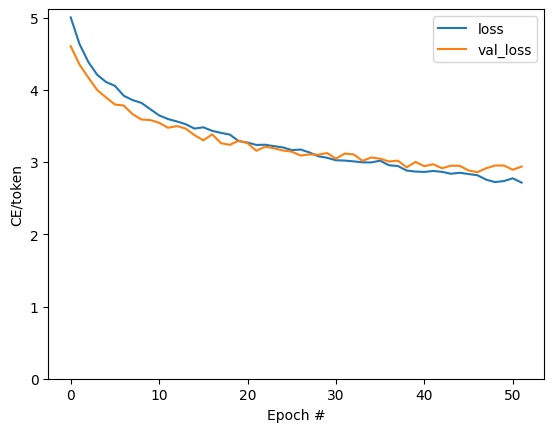

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

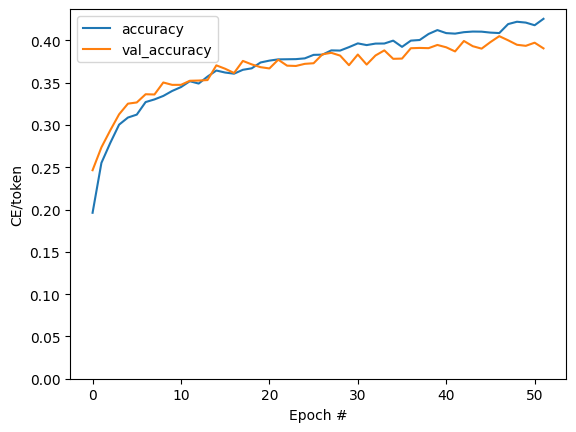

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a yellow shirt is surfing'

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 9, 49]), TensorShape([1, 2, 9, 49])]

In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 0.99999994, 1.        ,
       0.99999994, 1.        , 1.        , 1.        ], dtype=float32)>

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

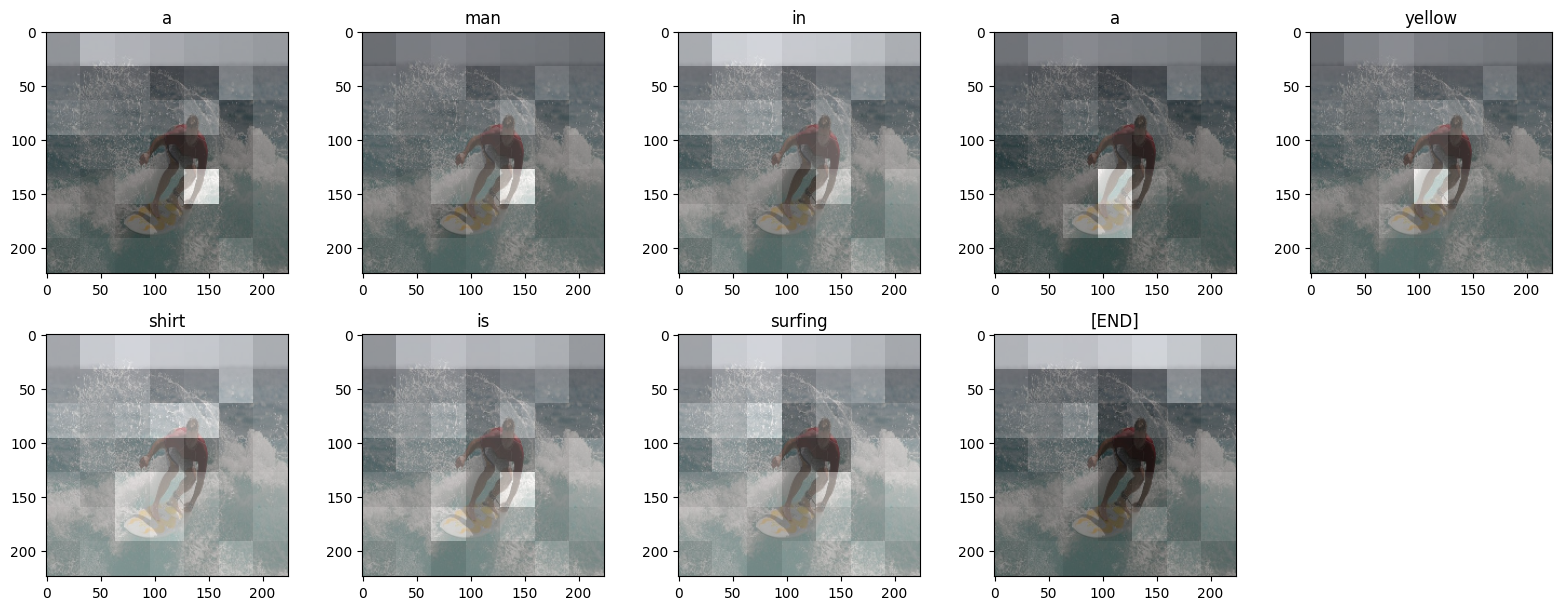

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


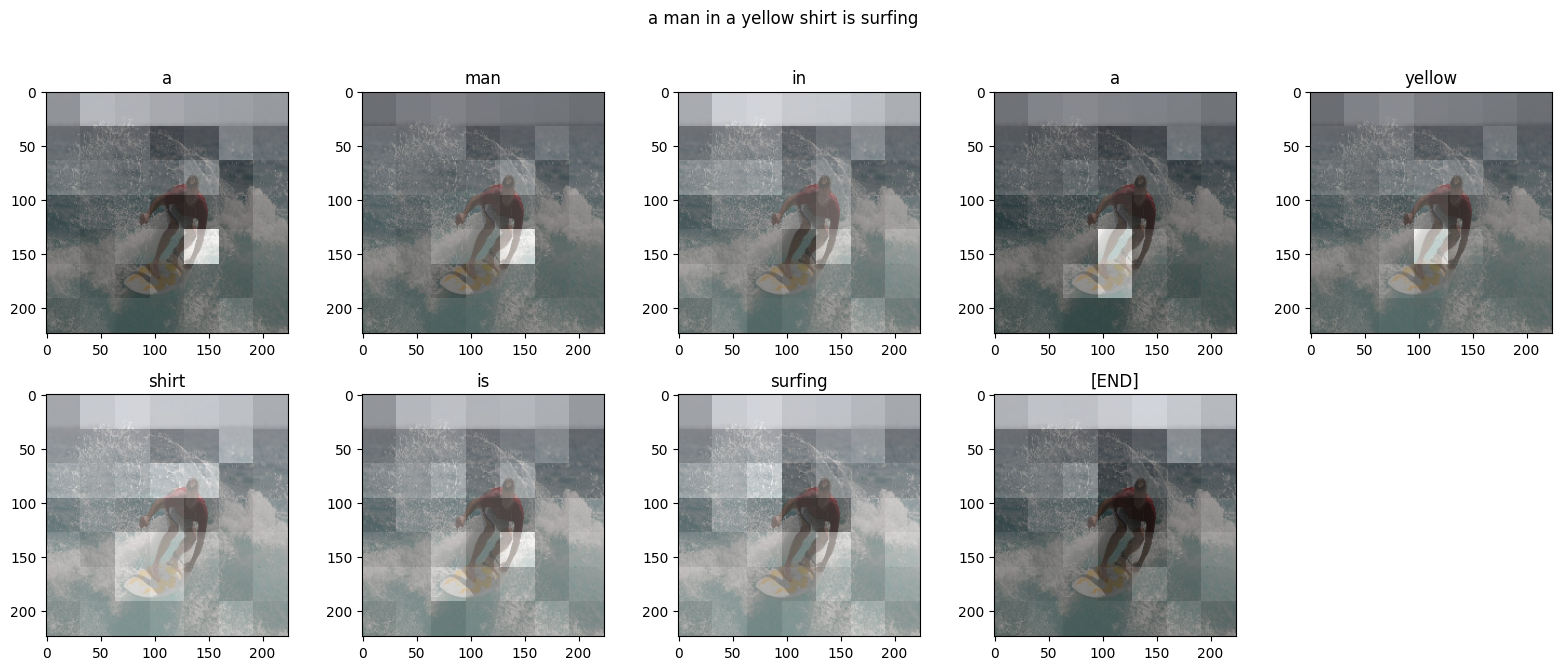

In [ ]:
run_and_show_attention(model, image)

 8192/67460 [==>...........................] - ETA: 0s

49152/67460 [====================>.........] - ETA: 0s

67460/67460 [==============================] - 0s 1us/step


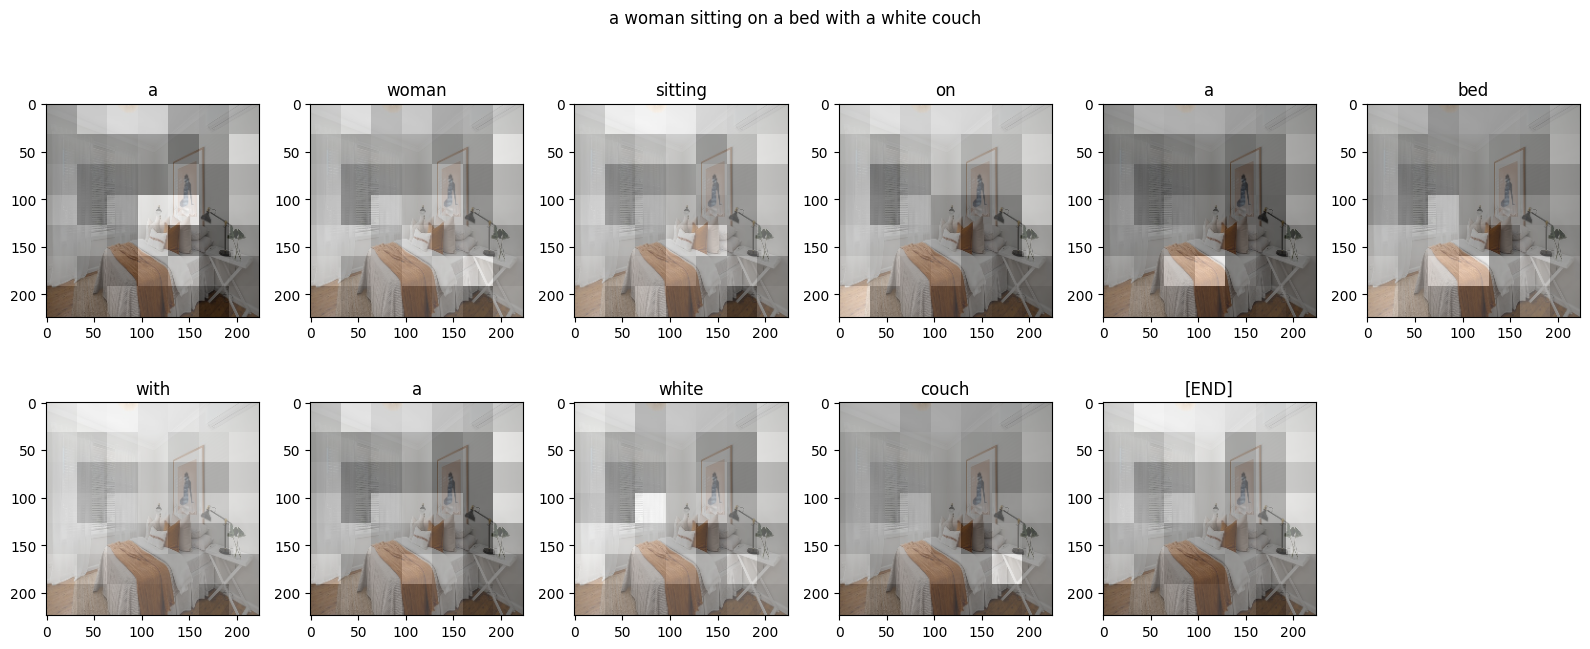

In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)